In [5]:
# Using genetic algorithm to optimize the area of truss using deap library

In [6]:
# importing necessary libraries

import jax
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 1200

import random
np.random.seed(69)
random.seed(69)

2023-01-24 15:21:12.382977: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-24 15:21:12.479295: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-24 15:21:12.480574: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


# Truss

In [7]:
# defining the geometery of truss

E = 1e7 #68947572.93178 # KN/m^2 (10e7 psi) modulus_of_elasticity
p = 0.1  #27.1447138 # KN/m^3 (0.1 lb/in^3) weight_density
s_lim = 25000 #172368.93233 #KN/m^2 (25000 psi) # allowable_stress_compression = 172368.93233 #KN/m^2 (25000 psi)
d_lim =  2 #0.0508 #m (2 inch) #displacemnt limit

In [8]:
area_avalival = [1.62, 1.80,2.38, 2.62, 2.88, 3.09, 3.13,
3.38,3.63,3.84,3.87,4.18,4.49,4.80,4.97,5.12, 5.74, 7.22,
7.97,11.5,13.5,13.9,14.2,15.5,16.0,18.8,19.9,22.0,22.9,
26.5, 30.0, 33.5]  ## sq inch

In [9]:
nodes, bars =[], []

nodes.append([100,460]) #node0
nodes.append([460,460]) #node1
nodes.append([820,460]) #node2
nodes.append([100,100]) #node3
nodes.append([460,100]) #node4
nodes.append([820,100]) #node5

bars.append([0,1]) #bar1  #dont forget python starts with 0
bars.append([1,2]) #bar2

bars.append([3,4]) #bar3
bars.append([4,5]) #bar4


bars.append([1,4]) #bar5
bars.append([2,5]) #bar6

bars.append([0,4]) #bar7
bars.append([1,3]) #bar8

bars.append([1,5]) #bar9
bars.append([2,4]) #bar10

nodes = np.array(nodes).astype(float)
bars = np.array(bars)
original_nodes = np.copy(nodes)

In [10]:
bars

array([[0, 1],
       [1, 2],
       [3, 4],
       [4, 5],
       [1, 4],
       [2, 5],
       [0, 4],
       [1, 3],
       [1, 5],
       [2, 4]])

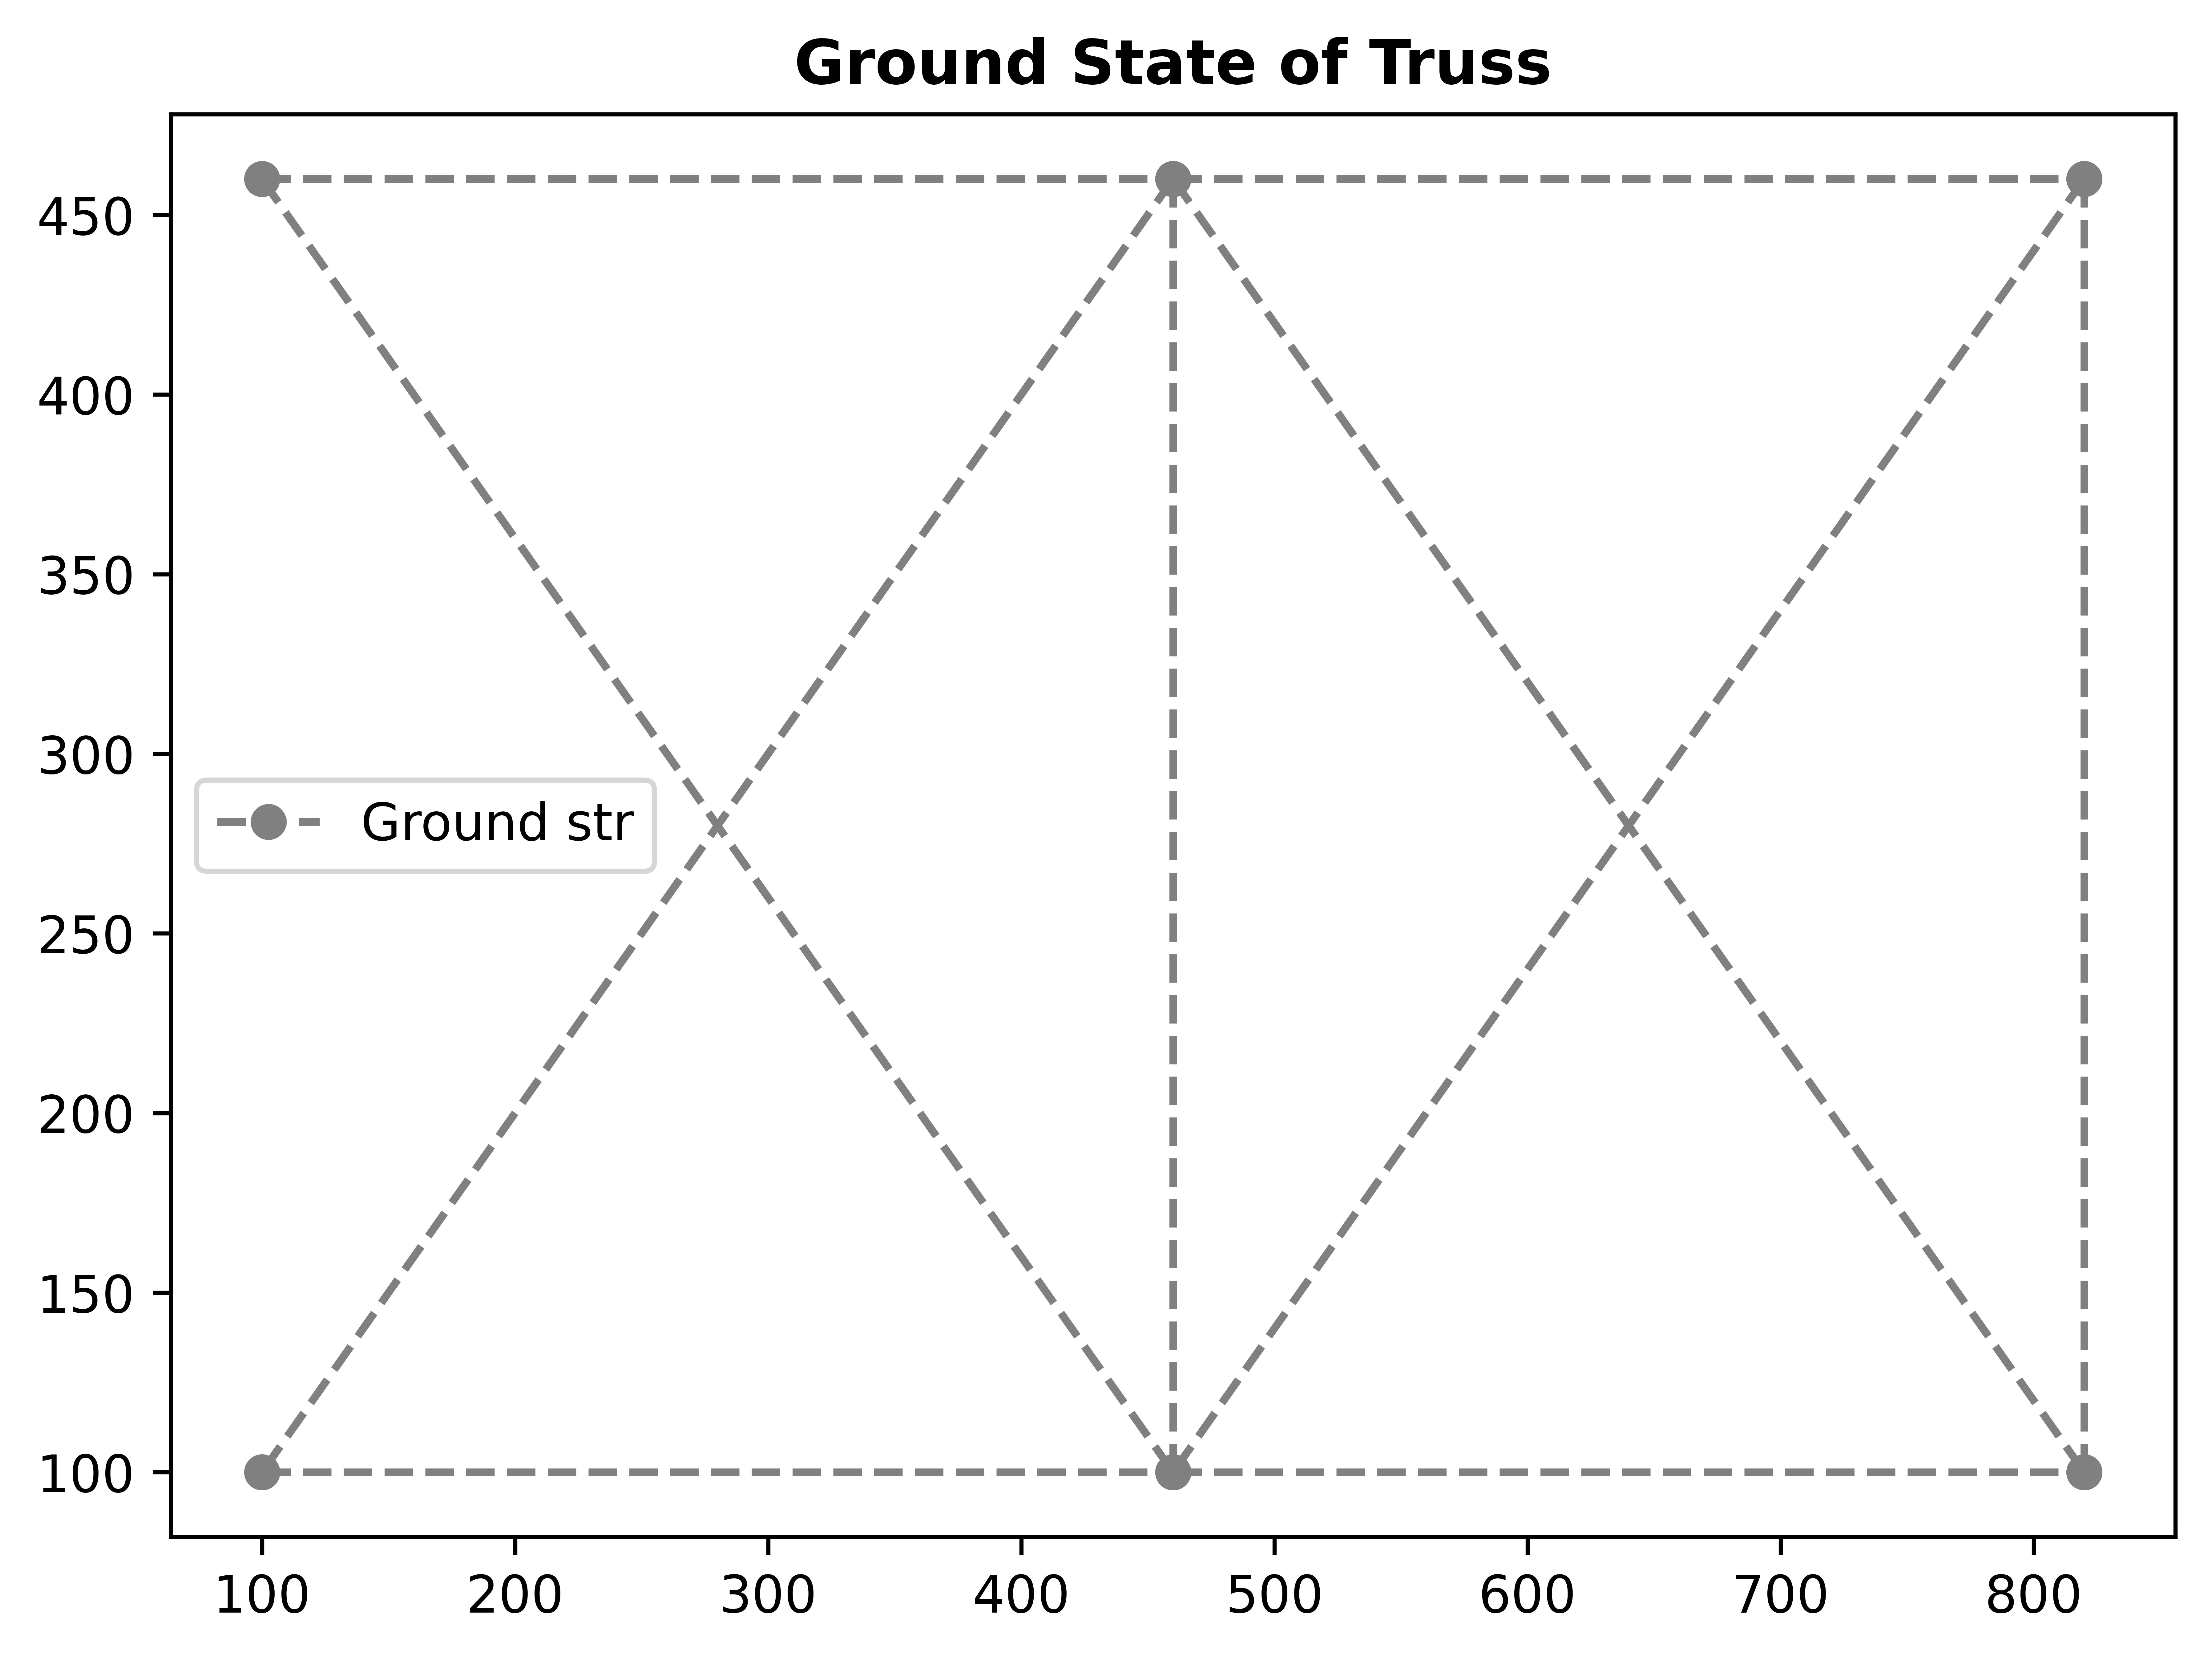

In [11]:
plt.figure(figsize=(7,5))
plt.title("Ground State of Truss", fontweight='bold')
for i in range(len(bars)):
    xi, xf = nodes[bars[i,0],0], nodes[bars[i, 1],0]
    yi, yf = nodes[bars[i, 0], 1], nodes[bars [i, 1],1]
    line, = plt.plot([xi, xf], [yi, yf], color='grey', linestyle='--', marker='o') 

line.set_label('Ground str')
plt.legend()
plt.show()

In [12]:
P = np.zeros_like(nodes) # 0 =nO LOAD # 1 == lOAD
P[4,1]= -100000
P[5,1]= -100000
print(P)

[[      0.       0.]
 [      0.       0.]
 [      0.       0.]
 [      0.       0.]
 [      0. -100000.]
 [      0. -100000.]]


In [13]:
Ur = [0,0,0,0]

In [14]:
# Defining the degrees of Freedoms
DOFCON = np.ones_like(nodes).astype(int)
DOFCON[0,:] = 0
DOFCON[3,:] = 0
print(DOFCON)

[[0 0]
 [1 1]
 [1 1]
 [0 0]
 [1 1]
 [1 1]]


In [15]:
# Truss Analysis
# Doing structural analysis of the truss for an constant area of 11.5 inch^2

In [16]:
@jax.jit
class basic(): 

    def min_area(area):
        computed_area =[]
        for i in area:
            if i<1:
                computed_area.append(1)
            else:
                computed_area.append(i)
        return np.array(computed_area)

    def area_gen(area):
        area_new = []
        for i in range(10):
            area_new.append(random.choice(area))
        return area_new

    def scaler(area):
        f=[]
        a = sum(area)
        for i in area:
            i=i*50
            f.append(i/a)
        return f

    def Plot(nodes, c, lt, area, lg):
        for i in range(len(bars)):
            xi, xf = nodes[bars[i,0],0], nodes[bars[i,1],0]
            yi, yf = nodes[bars[i,0],1], nodes[bars[i,1],1]
            a = np.round(basic.scaler(area), 3)
            line, = plt.plot([xi, xf], [yi,yf], color=c, linestyle=lt, linewidth=a[i],
                             label=f'\nArea : {area[i]} in^2\n', marker='o', solid_capstyle='round') #
        line, = plt.plot([xi, xf], [yi,yf], color=c, linestyle=lt, linewidth=0.001)
        line.set_label(lg)
        plt.legend(bbox_to_anchor=(1,1), loc="upper left", prop={'size':4})
    

    def check( STRESS, DEFLECTION):
        x=0
        y=0
        for i in STRESS:
            if np.abs(i) > s_lim:
                x +=1
                # print("Failed in Stress")
            else:
                pass
                #print("Pass in Stress")
        for i in range(6):
            ix = np.abs(DEFLECTION[i][0])
            iy = np.abs(DEFLECTION[i][1])
            if ix > d_lim:
                y+=1
                #print("Failed in Deflection along X")
            elif iy > d_lim:
                y +=1
                #print("Failed in Deflection along Y")
            else:
                pass
                #print("Pass in Deflection")
        if (x ==0) & (y==0):
            # print("Pass")
            return "Pass"
        else:
            # print(f'Failed in {x} ways for stress \n Failed in {y} ways for deflection ')
            return f'Failed in {x} ways for stress \n Failed in {y} ways for deflection '

@jax.jit
class Truss():
    # Truss Structural Analysis
    def TrussAnalysis(A, nodes, bars):
        NN = len(nodes) # number of nodes
        NE = len(bars) # number of deges
        # print(NE)

        DOF = 2 # defree of freedom
        NDOF = DOF*NN # total degree of freedom

        #structural analysis using direct stifness method

        # for bar no 3
        # takes info from node no 3 and substract it from infor of node no 2
        d = nodes[bars[:,1],:] - nodes[bars[:,0],:]
        
        L = np.sqrt((d**2).sum(axis=1)) #leangth of the bar
        # print(f"The Leangth is {L}")
        #computing the angle 
        angle = d.T/L
        # print(f"The angle is \n\n{angle}\n\n")
        #transformation vector {a ==Transformation vector}
        a = np.concatenate((-angle.T, angle.T), axis=1)
        # print(f"The transformation vector is \n\n{a}\n\n")

        #Global stifness matrix K
        K = np.zeros([NDOF,NDOF])
        
        
        for k in range(NE):
            aux = 2*bars[k,:]
            #gives you degree of freedom in each node
            index = np.r_[aux[0]:aux[0]+2, aux[1]:aux[1]+2]
            # print(f'a : {a.shape}, A: {A.shape}, L: {L.shape}')
            ES = np.dot(a[k][np.newaxis].T*E*A[k], a[k][np.newaxis])/L[k]
            # print(f"Stifness Matrix \n\n{ES}\n\n")
            K[np.ix_(index,index)] = K[np.ix_(index,index)] + ES

        freeDOF = DOFCON.flatten().nonzero()[0]
        supportDOF = (DOFCON.flatten()==0).nonzero()[0]

        Kff = K[np.ix_(freeDOF, freeDOF)]
        Kfr = K[np.ix_(freeDOF, supportDOF)]
        Krf = Kfr.T
        # print(f'{Kfr}, \n \n {Kff}, \n \n {Krf}')
        Krr = K[np.ix_(supportDOF, supportDOF)]
        
        Pf = P.flatten()[freeDOF]
        #Uf = np.linalg.solve(Kff, Pf) #.lstsq
        Uf = np.linalg.inv(Kff)@ Pf
        U  = DOFCON.astype(float).flatten()
        U[freeDOF] = Uf
        U[supportDOF] = Ur

        U = U.reshape(NN, DOF) #displacement of the truss members
        u = np.concatenate((U[bars[:,0]], U[bars[:,1]]), axis=1)
        # print(E)
        # print(A)
        N = E*A[:]/L[:]*(a[:]*u[:]).sum(axis=1)
        R = (Krf[:]*Uf).sum(axis=1) + (Krr[:]*Ur).sum(axis=1) #Reaction Force
        R = R.reshape(2,DOF)

        # Stress
        S = N/A

        #weight of str
        Volume = (1*A*L).sum() #for mass replace 1 by p

        #check
        c = basic.check(S, U)

        return S, Volume, U, c, R

basic = jax.jit(basic)
Truss = jax.jit(Truss)

In [17]:
x = np.array([20 for i in range(10)]).astype(float)
x

array([20., 20., 20., 20., 20., 20., 20., 20., 20., 20.])

In [18]:
Truss.TrussAnalysis(x, nodes, bars)

(array([  9768.24934844,   2006.23161277, -10231.75065156,  -2993.76838723,
          1774.48096122,   2006.23161277,   7398.81272639,  -6743.32289734,
          4233.82785582,  -2837.23995605]),
 83929.35059634515,
 array([[ 0.        ,  0.        ],
        [ 0.35165698, -0.83717623],
        [ 0.42388131, -1.89756315],
        [ 0.        ,  0.        ],
        [-0.36834302, -0.90105754],
        [-0.47611869, -1.96978749]]),
 'Pass',
 array([[-300000.        ,  104635.01303119],
        [ 300000.        ,   95364.98696881]]))

# Genetic Algorithm

In [33]:
import random
from deap import base, creator, tools, algorithms

# Define the truss structure and objective function
def evaluate_truss(individual):
    individual = np.array(individual)
    individual = np.where(individual < 1, 1, individual)
    ans = Truss.TrussAnalysis(individual, nodes, bars)
    if ans[3] == "Pass":
        return ans[1],
    else:
        return 9999999,


# Create the DEAP toolbox
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)
toolbox = base.Toolbox()

# Define the genetic operators
toolbox.register("attr_float", random.randint, 1, 32)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=10)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evaluate_truss)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

# Define the parameters of the genetic algorithm
NGEN = 100
MU = 50
LAMBDA = 100
CXPB = 0.7
MUTPB = 0.2

# Run the genetic algorithm
pop = toolbox.population(n=MU)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", min)
stats.register("max", max)


pop, log = algorithms.eaMuPlusLambda(pop, toolbox, MU, LAMBDA, CXPB, MUTPB, NGEN, stats, halloffame=hof)

gen	nevals	avg        	std        	min                 	max         
0  	50    	9.00822e+06	2.97533e+06	(71812.88306652788,)	(9999999.0,)
1  	94    	7.02542e+06	4.54374e+06	(71812.88306652788,)	(9999999.0,)
2  	91    	5.43881e+06	4.94192e+06	(70172.59735953042,)	(9999999.0,)
3  	90    	4.05027e+06	4.85793e+06	(74045.24671216747,)	(9999999.0,)
4  	93    	1.27168e+06	3.22315e+06	(70805.24671216747,)	(9999999.0,)
5  	88    	77000.5    	4235.77    	(70470.83112443905,)	(89463.48047707611,)
6  	84    	75387      	2689.5     	(70470.83112443905,)	(83616.12982971316,)
7  	92    	74042.3    	2496.72    	(66870.83112443905,)	(81038.7531857969,) 
8  	89    	72458.3    	2151.76    	(67616.41553671061,)	(77387.58436125377,)
9  	93    	269608     	1.39006e+06	(67863.48047707611,)	(9999999.0,)        
10 	90    	69709.6    	1786.65    	(65405.24671216748,)	(74343.4804770761,) 
11 	89    	68501.5    	1685.95    	(63965.24671216748,)	(71910.83112443905,)
12 	89    	67091.3    	1291.95    	(63965.24671

In [34]:
log[-1]

{'gen': 100,
 'nevals': 88,
 'avg': 63965.24671216747,
 'std': 7.275957614183426e-12,
 'min': (63965.24671216748,),
 'max': (63965.24671216748,)}

In [35]:
a = np.array(pop[-1])
a = np.where(a<1,1, a)
a

array([29,  6, 32, 16,  1,  6, 14, 22, 11, 15])

In [36]:
Truss.TrussAnalysis(a, nodes, bars)

(array([ 6465.89968602,  4023.10456977, -6640.27840955, -4741.33578634,
        11649.71831315,  4023.10456977, 11363.09577668, -5625.42598187,
         9753.10745135, -2275.81161817]),
 63965.24671216748,
 array([[ 0.        ,  0.        ],
        [ 0.23277239, -0.63780306],
        [ 0.37760415, -1.83770553],
        [ 0.        ,  0.        ],
        [-0.23905002, -1.05719292],
        [-0.40973811, -1.9825373 ]]),
 'Pass',
 array([[-300000.        ,  112488.90910548],
        [ 300000.        ,   87511.09089452]]))

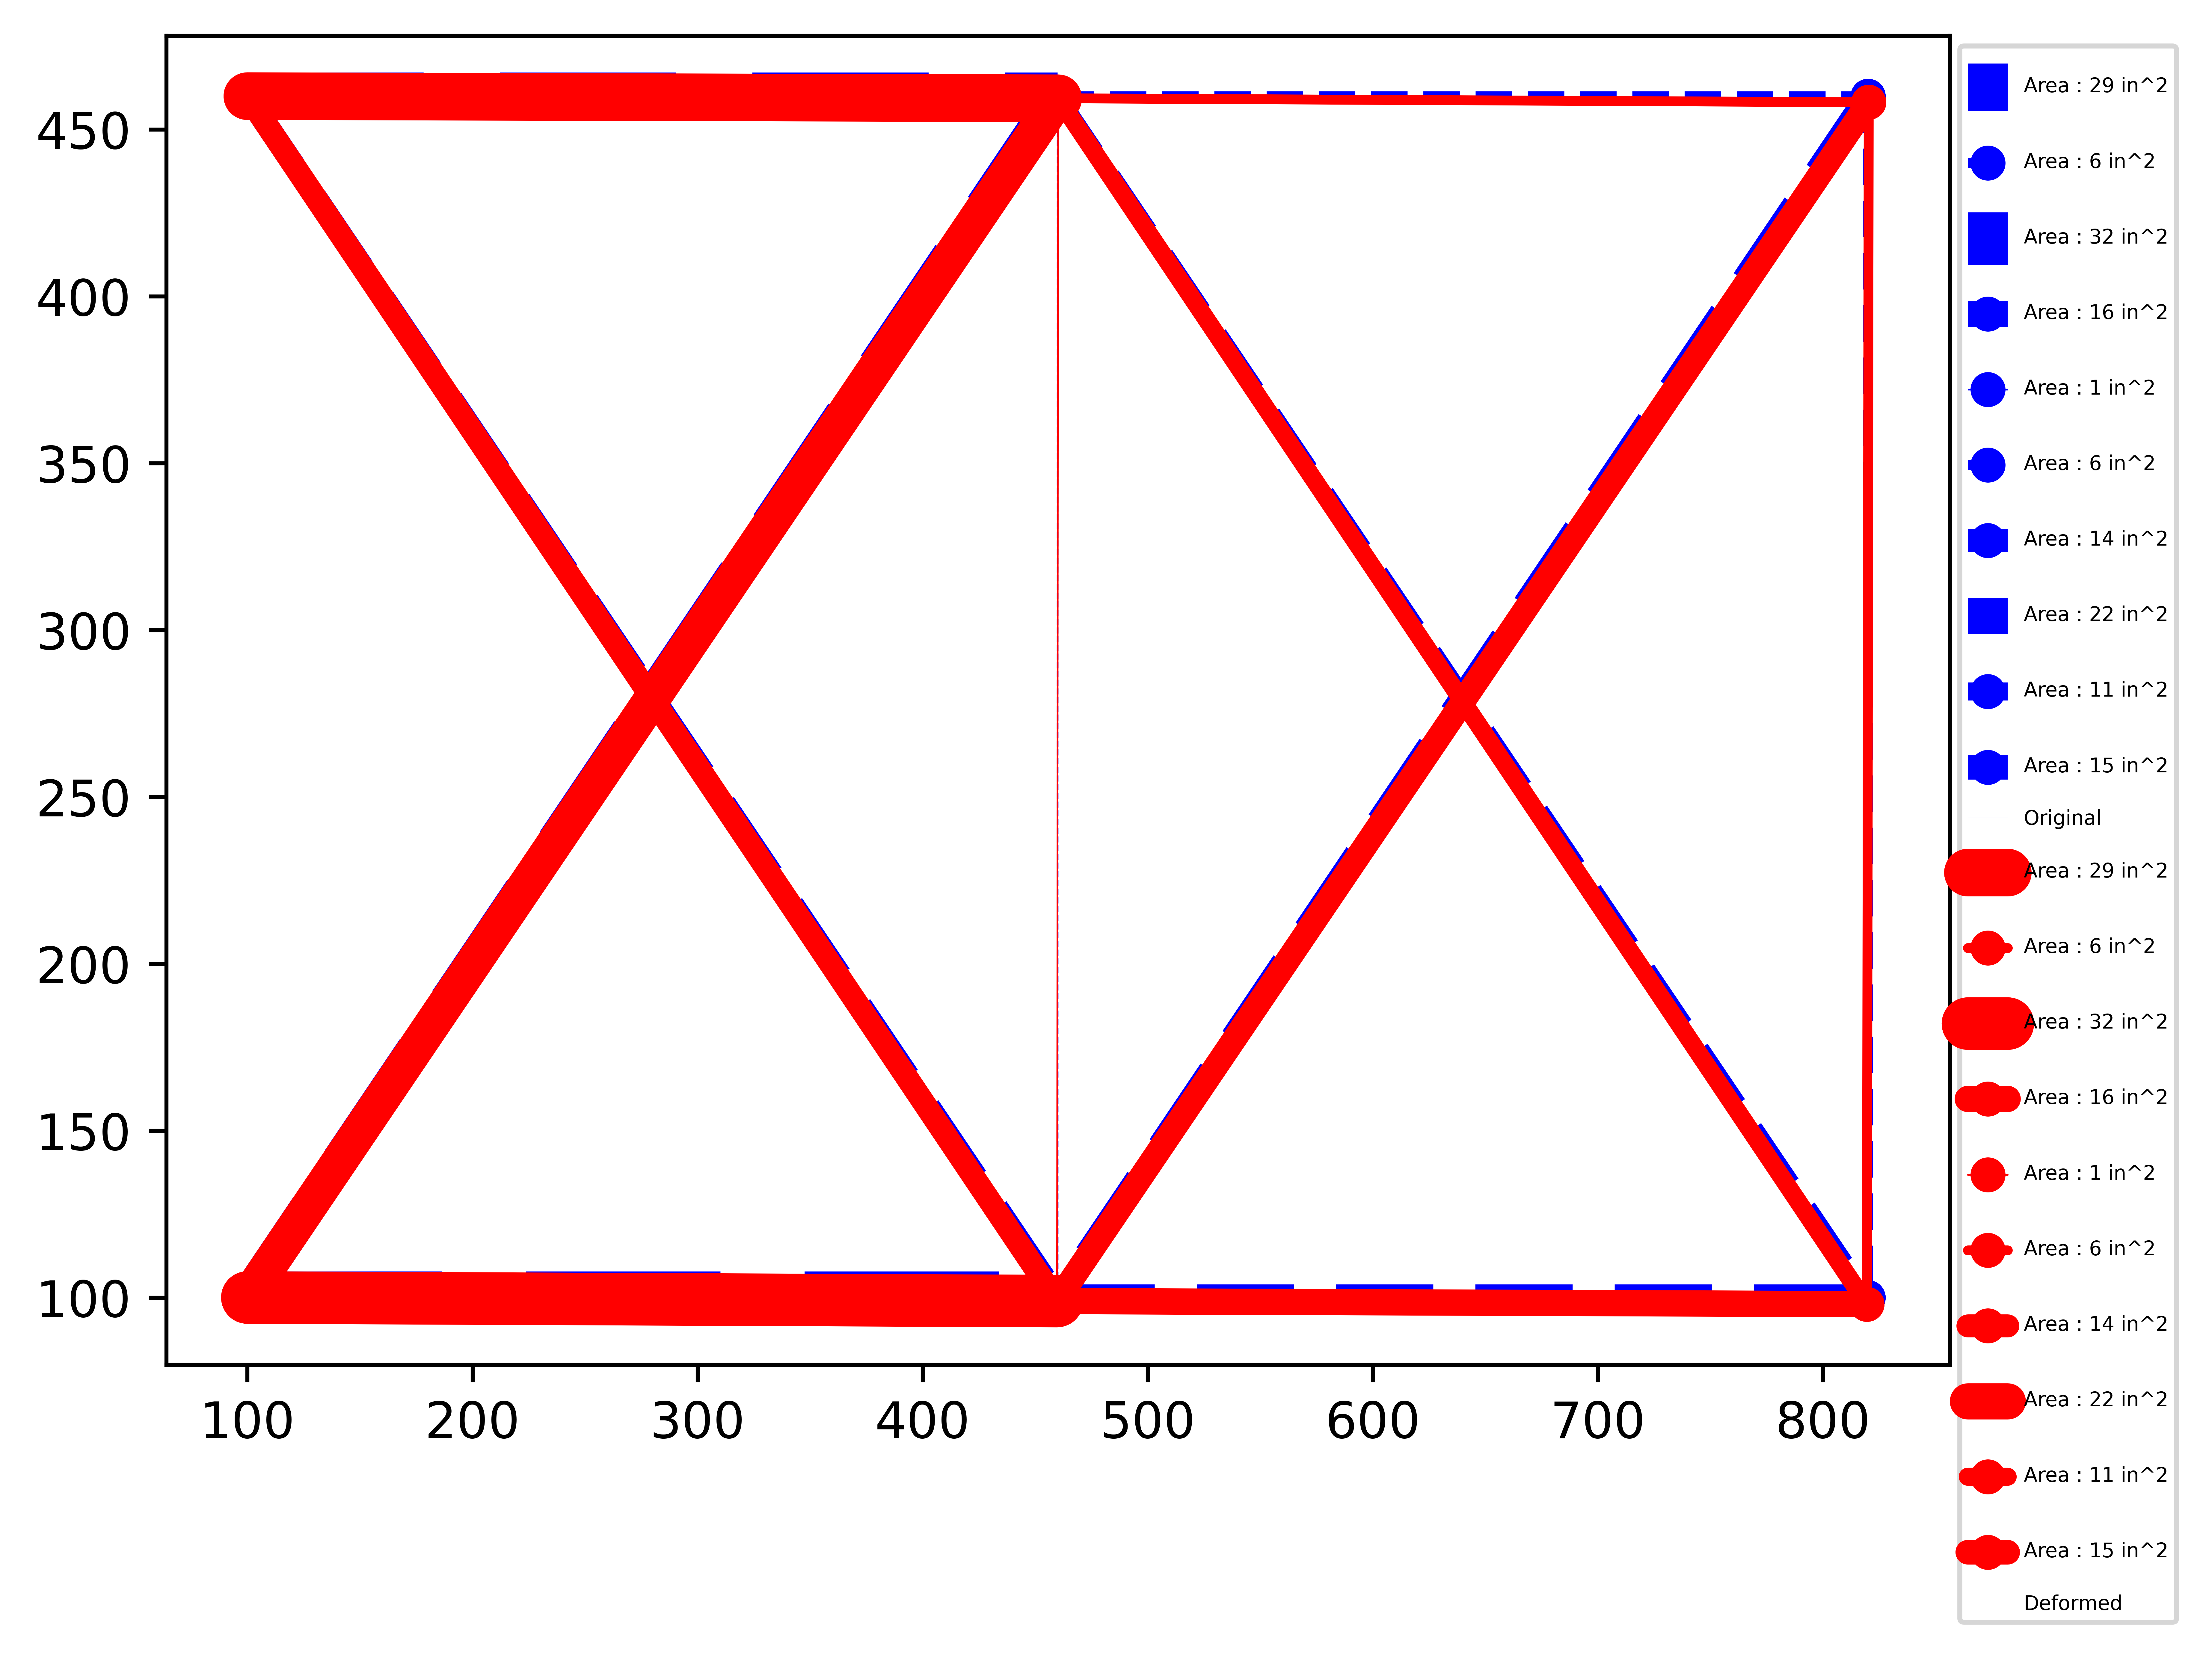

In [37]:
basic.Plot(nodes, 'b', '--',a, 'Original')
scale = 1
Dnodes=  Truss.TrussAnalysis(a, nodes, bars)[2]*scale + nodes
basic.Plot(Dnodes, 'r', '-',a, 'Deformed')

In [23]:
import optuna

In [24]:
def obj(trial):
    NGEN = trial.suggest_int('NGEN', 2, 100)
    MU = trial.suggest_int('MU', 2, 50)
    LAMBDA = trial.suggest_int('LAMBDA', 2, 100)
    CXPB = trial.suggest_float("CXPB", 0.0, 1.0)
    MUTPB = 1-CXPB

    # Run the genetic algorithm
    pop = toolbox.population(n=MU)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", min)
    stats.register("max", max)

    pop, log = algorithms.eaMuPlusLambda(pop, toolbox, MU, LAMBDA, CXPB, MUTPB, NGEN, stats, halloffame=hof)
    a = np.array(pop[-1])
    a = np.where(a<1,1, a)
    return Truss.TrussAnalysis(a, nodes, bars)[1]
    

In [25]:
study = optuna.create_study(direction='minimize')
study.optimize(obj, n_trials=100)

[I 2023-01-24 15:21:23,507] A new study created in memory with name: no-name-27936b5a-2436-4522-89bd-327e7ba29d09


gen	nevals	avg        	std        	min                 	max         
0  	11    	9.09767e+06	2.85342e+06	(74358.46747879946,)	(9999999.0,)
1  	55    	9.09847e+06	2.85089e+06	(83173.16877352534,)	(9999999.0,)
2  	55    	8.19694e+06	3.82487e+06	(83173.16877352534,)	(9999999.0,)
3  	55    	9.09883e+06	2.84975e+06	(87133.16877352534,)	(9999999.0,)
4  	55    	1e+07      	0          	(9999999.0,)        	(9999999.0,)
5  	55    	1e+07      	0          	(9999999.0,)        	(9999999.0,)
6  	55    	1e+07      	0          	(9999999.0,)        	(9999999.0,)
7  	55    	1e+07      	0          	(9999999.0,)        	(9999999.0,)
8  	55    	1e+07      	0          	(9999999.0,)        	(9999999.0,)
9  	55    	1e+07      	0          	(9999999.0,)        	(9999999.0,)
10 	55    	1e+07      	0          	(9999999.0,)        	(9999999.0,)
11 	55    	1e+07      	0          	(9999999.0,)        	(9999999.0,)
12 	55    	1e+07      	0          	(9999999.0,)        	(9999999.0,)
13 	55    	1e+07      	0          

[I 2023-01-24 15:21:26,029] Trial 0 finished with value: 21476.467529817255 and parameters: {'NGEN': 69, 'MU': 11, 'LAMBDA': 55, 'CXPB': 0.2772178916914797}. Best is trial 0 with value: 21476.467529817255.


66 	55    	1e+07      	0          	(9999999.0,)        	(9999999.0,)
67 	55    	1e+07      	0          	(9999999.0,)        	(9999999.0,)
68 	55    	1e+07      	0          	(9999999.0,)        	(9999999.0,)
69 	55    	1e+07      	0          	(9999999.0,)        	(9999999.0,)
gen	nevals	avg        	std        	min                	max         
0  	42    	9.05637e+06	2.90848e+06	(84885.8181261624,)	(9999999.0,)
1  	21    	7.8767e+06 	4.0658e+06 	(80227.01294725885,)	(9999999.0,)
2  	21    	5.98886e+06	4.86422e+06	(79867.01294725886,)	(9999999.0,)
3  	21    	1.507e+06  	3.46726e+06	(79867.01294725886,)	(9999999.0,)
4  	21    	85342.2    	6997.62    	(79867.01294725886,)	(103034.93500861671,)
5  	21    	82525.1    	4375.88    	(79867.01294725886,)	(93907.01294725886,) 
6  	21    	80107      	169.706    	(79867.01294725885,)	(80227.01294725885,) 
7  	21    	80012.7    	176.705    	(79867.01294725885,)	(80227.01294725885,) 
8  	21    	79884.2    	76.6652    	(79867.01294725885,)	(80227.012947

[I 2023-01-24 15:21:26,592] Trial 1 finished with value: 74467.01294725885 and parameters: {'NGEN': 37, 'MU': 42, 'LAMBDA': 21, 'CXPB': 0.9500447230643505}. Best is trial 0 with value: 21476.467529817255.


35 	21    	74467      	0          	(74467.01294725885,)	(74467.01294725885,) 
36 	21    	74467      	0          	(74467.01294725885,)	(74467.01294725885,) 
37 	21    	74467      	0          	(74467.01294725885,)	(74467.01294725885,) 
gen	nevals	avg        	std       	min                 	max         
0  	40    	8.51278e+06	3.5403e+06	(74158.18177180199,)	(9999999.0,)
1  	12    	6.03387e+06	4.8575e+06	(74158.18177180199,)	(9999999.0,)
2  	12    	2.31573e+06	4.14041e+06	(74158.18177180199,)	(9999999.0,)
3  	12    	577540     	2.16167e+06	(74158.18177180199,)	(9999999.0,)
4  	12    	76272.1    	4128.87    	(74158.18177180199,)	(87194.93500861671,)
5  	12    	74386.6    	1145.63    	(74158.18177180199,)	(81260.23371389082,)
6  	12    	74158.2    	0          	(74158.18177180199,)	(74158.18177180199,)
7  	12    	74158.2    	0          	(74158.18177180199,)	(74158.18177180199,)
8  	12    	74158.2    	0          	(74158.18177180199,)	(74158.18177180199,)
9  	12    	74158.2    	0          	(741

[I 2023-01-24 15:21:26,985] Trial 2 finished with value: 74158.18177180199 and parameters: {'NGEN': 44, 'MU': 40, 'LAMBDA': 12, 'CXPB': 0.30012742971376816}. Best is trial 0 with value: 21476.467529817255.


44 	12    	74158.2    	0          	(74158.18177180199,)	(74158.18177180199,)
gen	nevals	avg        	std        	min                 	max         
0  	45    	8.89884e+06	3.11454e+06	(84947.58436125377,)	(9999999.0,)
1  	36    	6.91668e+06	4.58812e+06	(84947.58436125377,)	(9999999.0,)
2  	36    	3.61334e+06	4.74389e+06	(84947.58436125377,)	(9999999.0,)
3  	36    	750082     	2.47215e+06	(84947.58436125377,)	(9999999.0,)
4  	36    	86120.5    	2279.78    	(81707.58436125377,)	(91864.33759806848,)
5  	36    	84616.2    	2213.71    	(81707.58436125377,)	(91761.99994898221,)
6  	36    	83756.5    	1548.39    	(81383.76618407358,)	(89369.92201034006,)
7  	36    	82050.2    	2754.07    	(70223.76618407358,)	(85641.9999489822,) 
8  	36    	79903.6    	3163.33    	(70223.76618407358,)	(83903.76618407358,)
9  	36    	77945.9    	3357.83    	(70223.76618407358,)	(81707.58436125377,)
10 	36    	75064.4    	3057.37    	(70223.76618407358,)	(81707.58436125377,)
11 	36    	72552.3    	2588.77    	(702

[I 2023-01-24 15:21:29,196] Trial 3 finished with value: 63358.181771802 and parameters: {'NGEN': 91, 'MU': 45, 'LAMBDA': 36, 'CXPB': 0.5279124715184585}. Best is trial 0 with value: 21476.467529817255.


89 	36    	63358.2    	2.18279e-11	(63358.181771802,)  	(63358.181771802,)  
90 	36    	63358.2    	2.18279e-11	(63358.181771802,)  	(63358.181771802,)  
91 	36    	63358.2    	2.18279e-11	(63358.181771802,)  	(63358.181771802,)  
gen	nevals	avg        	std       	min                 	max         
0  	11    	9.09853e+06	2.8507e+06	(83827.01294725886,)	(9999999.0,)
1  	31    	7.29707e+06	4.41386e+06	(83827.01294725886,)	(9999999.0,)
2  	31    	8.19921e+06	3.82005e+06	(90671.40253843396,)	(9999999.0,)
3  	31    	7.29813e+06	4.41213e+06	(86372.59735953042,)	(9999999.0,)
4  	31    	5.49528e+06	4.93467e+06	(86372.59735953042,)	(9999999.0,)
5  	31    	86382.3    	4974.37    	(79769.06488934768,)	(100056.98695070554,)
6  	31    	84033.5    	2416.42    	(79769.06488934768,)	(86372.59735953042,) 
7  	31    	83716.5    	3017.08    	(79769.06488934768,)	(89489.06488934768,) 
8  	31    	80746.2    	3260.25    	(77819.94800689336,)	(86372.59735953042,) 
9  	31    	78547.9    	2060.04    	(77459.948

[I 2023-01-24 15:21:29,706] Trial 4 finished with value: 62699.94800689337 and parameters: {'NGEN': 24, 'MU': 11, 'LAMBDA': 31, 'CXPB': 0.8550955757011001}. Best is trial 0 with value: 21476.467529817255.


18 	31    	73532.7    	1241.91    	(73139.94800689336,)	(77459.94800689336,) 
19 	31    	71241.8    	4026.65    	(62699.94800689337,)	(73139.94800689336,) 
20 	31    	68329      	5142.45    	(62699.94800689337,)	(73139.94800689336,) 
21 	31    	64598.1    	4026.65    	(62699.94800689337,)	(73139.94800689336,) 
22 	31    	64598.1    	4026.65    	(62699.94800689337,)	(73139.94800689336,) 
23 	31    	62699.9    	0          	(62699.94800689337,)	(62699.94800689337,) 
24 	31    	62634.5    	206.985    	(61979.94800689337,)	(62699.94800689337,) 
gen	nevals	avg  	std	min         	max         
0  	33    	1e+07	0  	(9999999.0,)	(9999999.0,)
1  	88    	1e+07	0  	(9999999.0,)	(9999999.0,)
2  	88    	1e+07	0  	(9999999.0,)	(9999999.0,)
3  	88    	1e+07	0  	(9999999.0,)	(9999999.0,)
4  	88    	1e+07	0  	(9999999.0,)	(9999999.0,)
5  	88    	1e+07	0  	(9999999.0,)	(9999999.0,)
6  	88    	1e+07	0  	(9999999.0,)	(9999999.0,)
7  	88    	1e+07	0  	(9999999.0,)	(9999999.0,)
8  	88    	1e+07	0  	(9999999.0

[I 2023-01-24 15:21:30,705] Trial 5 finished with value: 26665.584412271568 and parameters: {'NGEN': 17, 'MU': 33, 'LAMBDA': 88, 'CXPB': 0.23545732355104176}. Best is trial 0 with value: 21476.467529817255.


17 	88    	1e+07	0  	(9999999.0,)	(9999999.0,)
gen	nevals	avg        	std        	min                 	max         
0  	28    	9.29212e+06	2.55231e+06	(81995.22071561417,)	(9999999.0,)
1  	14    	7.87526e+06	4.06857e+06	(81995.22071561417,)	(9999999.0,)
2  	14    	6.10321e+06	4.84434e+06	(79588.15577524867,)	(9999999.0,)
3  	14    	2.56064e+06	4.29512e+06	(79588.15577524867,)	(9999999.0,)
4  	14    	80275.9    	1087.4     	(79588.15577524867,)	(81995.22071561417,)
5  	14    	79588.2    	0          	(79588.15577524867,)	(79588.15577524867,)
6  	14    	79588.2    	0          	(79588.15577524867,)	(79588.15577524867,)
7  	14    	79588.2    	0          	(79588.15577524867,)	(79588.15577524867,)
8  	14    	79588.2    	0          	(79588.15577524867,)	(79588.15577524867,)
9  	14    	79588.2    	0          	(79588.15577524867,)	(79588.15577524867,)
10 	14    	79588.2    	0          	(79588.15577524867,)	(79588.15577524867,)
11 	14    	433721     	1.84103e+06	(74908.15577524867,)	(9999999.0,) 

[I 2023-01-24 15:21:31,439] Trial 6 finished with value: 74908.15577524867 and parameters: {'NGEN': 76, 'MU': 28, 'LAMBDA': 14, 'CXPB': 0.16243622169515148}. Best is trial 0 with value: 21476.467529817255.


64 	14    	74908.2    	1.45519e-11	(74908.15577524867,)	(74908.15577524867,)
65 	14    	74908.2    	1.45519e-11	(74908.15577524867,)	(74908.15577524867,)
66 	14    	74908.2    	1.45519e-11	(74908.15577524867,)	(74908.15577524867,)
67 	14    	74908.2    	1.45519e-11	(74908.15577524867,)	(74908.15577524867,)
68 	14    	74908.2    	1.45519e-11	(74908.15577524867,)	(74908.15577524867,)
69 	14    	74908.2    	1.45519e-11	(74908.15577524867,)	(74908.15577524867,)
70 	14    	74908.2    	1.45519e-11	(74908.15577524867,)	(74908.15577524867,)
71 	14    	74908.2    	1.45519e-11	(74908.15577524867,)	(74908.15577524867,)
72 	14    	74908.2    	1.45519e-11	(74908.15577524867,)	(74908.15577524867,)
73 	14    	74908.2    	1.45519e-11	(74908.15577524867,)	(74908.15577524867,)
74 	14    	74908.2    	1.45519e-11	(74908.15577524867,)	(74908.15577524867,)
75 	14    	74908.2    	1.45519e-11	(74908.15577524867,)	(74908.15577524867,)
76 	14    	74908.2    	1.45519e-11	(74908.15577524867,)	(74908.15577524867,)

[I 2023-01-24 15:21:31,704] Trial 7 finished with value: 69205.53241916493 and parameters: {'NGEN': 42, 'MU': 39, 'LAMBDA': 8, 'CXPB': 0.9622350749341508}. Best is trial 0 with value: 21476.467529817255.


12 	8     	74965.5    	4.36557e-11	(74965.53241916493,)	(74965.53241916493,)
13 	8     	74965.5    	4.36557e-11	(74965.53241916493,)	(74965.53241916493,)
14 	8     	74965.5    	4.36557e-11	(74965.53241916493,)	(74965.53241916493,)
15 	8     	74965.5    	4.36557e-11	(74965.53241916493,)	(74965.53241916493,)
16 	8     	74965.5    	4.36557e-11	(74965.53241916493,)	(74965.53241916493,)
17 	8     	74965.5    	4.36557e-11	(74965.53241916493,)	(74965.53241916493,)
18 	8     	74522.5    	1534.86    	(69205.53241916493,)	(74965.53241916493,)
19 	8     	73636.3    	2426.83    	(69205.53241916493,)	(74965.53241916493,)
20 	8     	71568.6    	2833.23    	(69205.53241916493,)	(74965.53241916493,)
21 	8     	69353.2    	910.437    	(69205.53241916493,)	(74965.53241916493,)
22 	8     	69205.5    	4.36557e-11	(69205.53241916493,)	(69205.53241916493,)
23 	8     	69205.5    	4.36557e-11	(69205.53241916493,)	(69205.53241916493,)
24 	8     	69205.5    	4.36557e-11	(69205.53241916493,)	(69205.53241916493,)

[I 2023-01-24 15:21:33,011] Trial 8 finished with value: 4196.467529817257 and parameters: {'NGEN': 82, 'MU': 2, 'LAMBDA': 24, 'CXPB': 0.3390615337600875}. Best is trial 8 with value: 4196.467529817257.


81 	24    	1e+07	0  	(9999999.0,)	(9999999.0,)
82 	24    	1e+07	0  	(9999999.0,)	(9999999.0,)
gen	nevals	avg        	std       	min                 	max         
0  	42    	9.52779e+06	2.1118e+06	(82987.87006825123,)	(9999999.0,)
1  	11    	8.81896e+06	3.21278e+06	(76369.35059634515,)	(9999999.0,)
2  	11    	6.92906e+06	4.58668e+06	(76369.35059634515,)	(9999999.0,)
3  	11    	4.33009e+06	4.91029e+06	(76369.35059634515,)	(9999999.0,)
4  	11    	785382     	2.55568e+06	(76369.35059634515,)	(9999999.0,)
5  	11    	76443.1    	329.776    	(76369.35059634515,)	(77917.89606480455,)
6  	11    	76369.4    	0          	(76369.35059634515,)	(76369.35059634515,)
7  	11    	76369.4    	0          	(76369.35059634515,)	(76369.35059634515,)
8  	11    	76266.5    	459.991    	(74209.35059634515,)	(76369.35059634515,)
9  	11    	76163.6    	634.054    	(74209.35059634515,)	(76369.35059634515,)
10 	11    	75855.1    	919.982    	(74209.35059634515,)	(76369.35059634515,)
11 	11    	75032.2    	1048.94  

[I 2023-01-24 15:21:33,532] Trial 9 finished with value: 74209.35059634515 and parameters: {'NGEN': 65, 'MU': 42, 'LAMBDA': 11, 'CXPB': 0.708158440340047}. Best is trial 8 with value: 4196.467529817257.


48 	11    	74209.4    	0          	(74209.35059634515,)	(74209.35059634515,)
49 	11    	74209.4    	0          	(74209.35059634515,)	(74209.35059634515,)
50 	11    	74209.4    	0          	(74209.35059634515,)	(74209.35059634515,)
51 	11    	74209.4    	0          	(74209.35059634515,)	(74209.35059634515,)
52 	11    	74209.4    	0          	(74209.35059634515,)	(74209.35059634515,)
53 	11    	74209.4    	0          	(74209.35059634515,)	(74209.35059634515,)
54 	11    	74209.4    	0          	(74209.35059634515,)	(74209.35059634515,)
55 	11    	74209.4    	0          	(74209.35059634515,)	(74209.35059634515,)
56 	11    	74209.4    	0          	(74209.35059634515,)	(74209.35059634515,)
57 	11    	74209.4    	0          	(74209.35059634515,)	(74209.35059634515,)
58 	11    	74209.4    	0          	(74209.35059634515,)	(74209.35059634515,)
59 	11    	74209.4    	0          	(74209.35059634515,)	(74209.35059634515,)
60 	11    	74209.4    	0          	(74209.35059634515,)	(74209.35059634515,)

[I 2023-01-24 15:21:37,452] Trial 10 finished with value: 14636.467529817259 and parameters: {'NGEN': 100, 'MU': 3, 'LAMBDA': 60, 'CXPB': 0.024330608196052594}. Best is trial 8 with value: 4196.467529817257.


98 	60    	1e+07	0  	(9999999.0,)	(9999999.0,)
99 	60    	1e+07	0  	(9999999.0,)	(9999999.0,)
100	60    	1e+07	0  	(9999999.0,)	(9999999.0,)
gen	nevals	avg  	std	min         	max         
0  	2     	1e+07	0  	(9999999.0,)	(9999999.0,)
1  	63    	1e+07	0  	(9999999.0,)	(9999999.0,)
2  	63    	1e+07	0  	(9999999.0,)	(9999999.0,)
3  	63    	1e+07	0  	(9999999.0,)	(9999999.0,)
4  	63    	1e+07	0  	(9999999.0,)	(9999999.0,)
5  	63    	1e+07	0  	(9999999.0,)	(9999999.0,)
6  	63    	1e+07	0  	(9999999.0,)	(9999999.0,)
7  	63    	1e+07	0  	(9999999.0,)	(9999999.0,)
8  	63    	1e+07	0  	(9999999.0,)	(9999999.0,)
9  	63    	1e+07	0  	(9999999.0,)	(9999999.0,)
10 	63    	1e+07	0  	(9999999.0,)	(9999999.0,)
11 	63    	1e+07	0  	(9999999.0,)	(9999999.0,)
12 	63    	1e+07	0  	(9999999.0,)	(9999999.0,)
13 	63    	1e+07	0  	(9999999.0,)	(9999999.0,)
14 	63    	1e+07	0  	(9999999.0,)	(9999999.0,)
15 	63    	1e+07	0  	(9999999.0,)	(9999999.0,)
16 	63    	1e+07	0  	(9999999.0,)	(9999999.0,)
17 	63    	1e

[I 2023-01-24 15:21:41,535] Trial 11 finished with value: 4196.467529817257 and parameters: {'NGEN': 99, 'MU': 2, 'LAMBDA': 63, 'CXPB': 0.05986487760873865}. Best is trial 8 with value: 4196.467529817257.


99 	63    	1e+07	0  	(9999999.0,)	(9999999.0,)
gen	nevals	avg        	std        	min                 	max         
0  	2     	5.03937e+06	4.96063e+06	(78740.23371389083,)	(9999999.0,)
1  	75    	1e+07      	0          	(9999999.0,)        	(9999999.0,)
2  	75    	1e+07      	0          	(9999999.0,)        	(9999999.0,)
3  	75    	1e+07      	0          	(9999999.0,)        	(9999999.0,)
4  	75    	1e+07      	0          	(9999999.0,)        	(9999999.0,)
5  	75    	1e+07      	0          	(9999999.0,)        	(9999999.0,)
6  	75    	1e+07      	0          	(9999999.0,)        	(9999999.0,)
7  	75    	1e+07      	0          	(9999999.0,)        	(9999999.0,)
8  	75    	1e+07      	0          	(9999999.0,)        	(9999999.0,)
9  	75    	1e+07      	0          	(9999999.0,)        	(9999999.0,)
10 	75    	1e+07      	0          	(9999999.0,)        	(9999999.0,)
11 	75    	1e+07      	0          	(9999999.0,)        	(9999999.0,)
12 	75    	1e+07      	0          	(9999999.0,)        	

[I 2023-01-24 15:21:45,648] Trial 12 finished with value: 4196.467529817257 and parameters: {'NGEN': 84, 'MU': 2, 'LAMBDA': 75, 'CXPB': 0.0025272857791792114}. Best is trial 8 with value: 4196.467529817257.


84 	75    	1e+07      	0          	(9999999.0,)        	(9999999.0,)
gen	nevals	avg        	std        	min                 	max         
0  	16    	8.76121e+06	3.27753e+06	(85518.46747879944,)	(9999999.0,)
1  	41    	5.66266e+06	4.91808e+06	(72096.12982971317,)	(9999999.0,)
2  	41    	3.80278e+06	4.80035e+06	(72096.12982971317,)	(9999999.0,)
3  	41    	1.93907e+06	3.87235e+06	(69576.12982971317,)	(9999999.0,)
4  	41    	74866.2    	5637.08    	(69576.12982971317,)	(91849.35059634513,)
5  	41    	73251.4    	3695.44    	(69576.12982971317,)	(82685.2467121675,) 
6  	41    	692017     	2.40331e+06	(69576.12982971317,)	(9999999.0,)        
7  	41    	691173     	2.40353e+06	(69576.12982971317,)	(9999999.0,)        
8  	41    	69576.1    	0          	(69576.12982971317,)	(69576.12982971317,)
9  	41    	69081.1    	1309.65    	(65616.12982971317,)	(69576.12982971317,)
10 	41    	68091.1    	1917.13    	(65616.12982971317,)	(69576.12982971317,)
11 	41    	66606.1    	1714.73    	(65616.12982

[I 2023-01-24 15:21:48,330] Trial 13 finished with value: 65616.12982971317 and parameters: {'NGEN': 98, 'MU': 16, 'LAMBDA': 41, 'CXPB': 0.45085405084022934}. Best is trial 8 with value: 4196.467529817257.


95 	41    	65616.1    	0          	(65616.12982971317,)	(65616.12982971317,)
96 	41    	65616.1    	0          	(65616.12982971317,)	(65616.12982971317,)
97 	41    	65616.1    	0          	(65616.12982971317,)	(65616.12982971317,)
98 	41    	65616.1    	0          	(65616.12982971317,)	(65616.12982971317,)
gen	nevals	avg  	std	min         	max         
0  	19    	1e+07	0  	(9999999.0,)	(9999999.0,)
1  	66    	9.47893e+06	2.21072e+06	(99635.22071561417,)	(9999999.0,)
2  	66    	6.86853e+06	4.6094e+06 	(75896.41553671063,)	(9999999.0,)
3  	66    	3.21357e+06	4.61048e+06	(75896.41553671063,)	(9999999.0,)
4  	66    	1.12176e+06	3.04521e+06	(75387.2986542563,) 	(9999999.0,)
5  	66    	1.12168e+06	3.04524e+06	(75387.2986542563,) 	(9999999.0,)
6  	66    	596942     	2.21632e+06	(65307.29865425631,)	(9999999.0,)
7  	66    	73983.3    	3617.59    	(65307.29865425631,)	(75896.41553671063,)
8  	66    	69155      	4764.2     	(65307.29865425631,)	(75387.2986542563,) 
9  	66    	65918.2    	2239.51

[I 2023-01-24 15:21:50,947] Trial 14 finished with value: 65307.29865425631 and parameters: {'NGEN': 60, 'MU': 19, 'LAMBDA': 66, 'CXPB': 0.14892110770099565}. Best is trial 8 with value: 4196.467529817257.


58 	66    	1.11106e+06	3.04888e+06	(65307.29865425631,)	(9999999.0,)        
59 	66    	588186     	2.21839e+06	(65307.29865425631,)	(9999999.0,)        
60 	66    	65307.3    	7.27596e-12	(65307.29865425631,)	(65307.29865425631,)
gen	nevals	avg        	std        	min                	max         
0  	8     	8.76074e+06	3.27878e+06	(85893.4544805228,)	(9999999.0,)
1  	97    	7.52417e+06	4.28826e+06	(96693.45448052279,)	(9999999.0,)
2  	97    	7.52417e+06	4.28826e+06	(96693.45448052279,)	(9999999.0,)
3  	97    	5.04765e+06	4.95235e+06	(91093.16877352535,)	(9999999.0,)
4  	97    	2.5694e+06 	4.29006e+06	(91093.16877352535,)	(9999999.0,)
5  	97    	89565      	5023.67    	(81733.16877352534,)	(96693.45448052279,)
6  	97    	87073.3    	4973.08    	(81733.16877352534,)	(96693.45448052279,)
7  	97    	84933.2    	3249.67    	(81733.16877352534,)	(88933.16877352534,)
8  	97    	80113.2    	2805.92    	(73093.16877352534,)	(81733.16877352534,)
9  	97    	79573.2    	3415.26    	(70933.1687735

[I 2023-01-24 15:21:56,170] Trial 15 finished with value: 62278.181771801996 and parameters: {'NGEN': 82, 'MU': 8, 'LAMBDA': 97, 'CXPB': 0.3888445015584298}. Best is trial 8 with value: 4196.467529817257.
[I 2023-01-24 15:21:56,287] Trial 16 finished with value: 77289.6363033426 and parameters: {'NGEN': 3, 'MU': 16, 'LAMBDA': 46, 'CXPB': 0.12234076732405197}. Best is trial 8 with value: 4196.467529817257.


82 	97    	62278.2    	0          	(62278.181771801996,)	(62278.181771801996,)
gen	nevals	avg        	std        	min                 	max         
0  	16    	9.38122e+06	2.39653e+06	(99501.09083488319,)	(9999999.0,)
1  	46    	8.76244e+06	3.27428e+06	(99501.09083488319,)	(9999999.0,)
2  	46    	7.52487e+06	4.28704e+06	(99501.09083488319,)	(9999999.0,)
3  	46    	3.19314e+06	4.58919e+06	(95181.09083488319,)	(9999999.0,)
gen	nevals	avg        	std        	min                	max         
0  	23    	8.70628e+06	3.34038e+06	(73474.3635946218,)	(9999999.0,)
1  	75    	6.98137e+06	4.56374e+06	(73474.3635946218,)	(9999999.0,)
2  	75    	3.96332e+06	4.84012e+06	(73474.3635946218,)	(9999999.0,)
3  	75    	1.37263e+06	3.34137e+06	(73474.3635946218,)	(9999999.0,)
4  	75    	76339.6    	4139.71    	(71674.3635946218,)	(87467.58436125379,)
5  	75    	72441.2    	3119.78    	(62314.36359462179,)	(81388.15577524868,)
6  	75    	70973.5    	2177.41    	(66423.48047707611,)	(74729.06488934769,)
7  	75

[I 2023-01-24 15:21:59,088] Trial 17 finished with value: 58354.3635946218 and parameters: {'NGEN': 56, 'MU': 23, 'LAMBDA': 75, 'CXPB': 0.5381534177445213}. Best is trial 8 with value: 4196.467529817257.


52 	75    	58354.4    	1.45519e-11	(58354.3635946218,)  	(58354.3635946218,)  
53 	75    	58354.4    	1.45519e-11	(58354.3635946218,)  	(58354.3635946218,)  
54 	75    	58354.4    	1.45519e-11	(58354.3635946218,)  	(58354.3635946218,)  
55 	75    	58354.4    	1.45519e-11	(58354.3635946218,)  	(58354.3635946218,)  
56 	75    	58354.4    	1.45519e-11	(58354.3635946218,)  	(58354.3635946218,)  
gen	nevals	avg        	std        	min                 	max         
0  	6     	6.69606e+06	4.67247e+06	(85441.71424198474,)	(9999999.0,)
1  	27    	1.73737e+06	3.69517e+06	(71489.06488934769,)	(9999999.0,)
2  	27    	1.73505e+06	3.69621e+06	(71489.06488934769,)	(9999999.0,)
3  	27    	74369.1    	7447.74    	(69329.06488934769,)	(90929.06488934769,)
4  	27    	70349.1    	1027.03    	(69329.06488934769,)	(71489.06488934769,)
5  	27    	68249.1    	2414.95    	(62849.06488934768,)	(69329.06488934769,)
6  	27    	65009.1    	3054.7     	(62849.06488934768,)	(69329.06488934769,)
7  	27    	65309.1   

[I 2023-01-24 15:22:00,700] Trial 18 finished with value: 62849.06488934768 and parameters: {'NGEN': 89, 'MU': 6, 'LAMBDA': 27, 'CXPB': 0.35860573083051556}. Best is trial 8 with value: 4196.467529817257.


84 	27    	62849.1    	0          	(62849.06488934768,)	(62849.06488934768,)
85 	27    	62849.1    	0          	(62849.06488934768,)	(62849.06488934768,)
86 	27    	62849.1    	0          	(62849.06488934768,)	(62849.06488934768,)
87 	27    	62849.1    	0          	(62849.06488934768,)	(62849.06488934768,)
88 	27    	62849.1    	0          	(62849.06488934768,)	(62849.06488934768,)
89 	27    	62849.1    	0          	(62849.06488934768,)	(62849.06488934768,)
gen	nevals	avg  	std	min         	max         
0  	10    	1e+07	0  	(9999999.0,)	(9999999.0,)
1  	52    	1e+07	0  	(9999999.0,)	(9999999.0,)
2  	52    	1e+07	0  	(9999999.0,)	(9999999.0,)
3  	52    	9.00862e+06	2.97414e+06	(86202.28565597965,)	(9999999.0,)
4  	52    	9.00884e+06	2.97347e+06	(88434.64930161925,)	(9999999.0,)
5  	52    	9.00884e+06	2.97347e+06	(88434.64930161925,)	(9999999.0,)
6  	52    	9.00869e+06	2.97391e+06	(86958.46747879944,)	(9999999.0,)
7  	52    	4.04893e+06	4.85903e+06	(76158.46747879944,)	(9999999.0,)
8  	5

[I 2023-01-24 15:22:03,249] Trial 19 finished with value: 62998.18177180199 and parameters: {'NGEN': 74, 'MU': 10, 'LAMBDA': 52, 'CXPB': 0.24945822582295335}. Best is trial 8 with value: 4196.467529817257.


gen	nevals	avg        	std       	min                 	max         
0  	29    	9.31692e+06	2.5098e+06	(94867.87006825123,)	(9999999.0,)
1  	70    	8.97391e+06	3.02074e+06	(74405.24671216749,)	(9999999.0,)
2  	70    	7.94871e+06	4.0162e+06 	(74405.24671216749,)	(9999999.0,)
3  	70    	6.922e+06  	4.58841e+06	(70805.24671216749,)	(9999999.0,)
4  	70    	3.84645e+06	4.81046e+06	(70805.24671216749,)	(9999999.0,)
5  	70    	1.10457e+06	3.02164e+06	(66485.24671216749,)	(9999999.0,)
6  	70    	415168     	1.81137e+06	(66485.24671216749,)	(9999999.0,)
7  	70    	410978     	1.81216e+06	(66485.24671216749,)	(9999999.0,)
8  	70    	66134.6    	1574.17    	(62165.24671216748,)	(70805.24671216749,)
9  	70    	750407     	2.51742e+06	(62165.24671216748,)	(9999999.0,)        
10 	70    	63978.9    	2019.24    	(62165.24671216748,)	(66485.24671216749,)
11 	70    	63146.3    	1797.57    	(61656.129829713165,)	(66485.24671216749,)
12 	70    	405462     	1.8132e+06 	(61656.129829713165,)	(9999999.0,)   

[I 2023-01-24 15:22:07,501] Trial 20 finished with value: 61656.129829713165 and parameters: {'NGEN': 92, 'MU': 29, 'LAMBDA': 70, 'CXPB': 0.08685516020349135}. Best is trial 8 with value: 4196.467529817257.


90 	70    	61656.1    	7.27596e-12	(61656.129829713165,)	(61656.129829713165,)
91 	70    	61656.1    	7.27596e-12	(61656.129829713165,)	(61656.129829713165,)
92 	70    	61656.1    	7.27596e-12	(61656.129829713165,)	(61656.129829713165,)
gen	nevals	avg        	std        	min                 	max         
0  	2     	5.04602e+06	4.95397e+06	(92049.63630334259,)	(9999999.0,)
1  	84    	92049.6    	0          	(92049.63630334259,)	(92049.63630334259,)
2  	84    	92049.6    	0          	(92049.63630334259,)	(92049.63630334259,)
3  	84    	5.04602e+06	4.95397e+06	(92049.63630334259,)	(9999999.0,)        
4  	84    	92049.6    	0          	(92049.63630334259,)	(92049.63630334259,)
5  	84    	92049.6    	0          	(92049.63630334259,)	(92049.63630334259,)
6  	84    	92049.6    	0          	(92049.63630334259,)	(92049.63630334259,)
7  	84    	92049.6    	0          	(92049.63630334259,)	(92049.63630334259,)
8  	84    	92049.6    	0          	(92049.63630334259,)	(92049.63630334259,)
9  	84   

[I 2023-01-24 15:22:12,032] Trial 21 finished with value: 4196.467529817257 and parameters: {'NGEN': 82, 'MU': 2, 'LAMBDA': 84, 'CXPB': 0.04882377953072974}. Best is trial 8 with value: 4196.467529817257.


82 	84    	1e+07      	0          	(9999999.0,)        	(9999999.0,)        
gen	nevals	avg  	std	min         	max         
0  	2     	1e+07	0  	(9999999.0,)	(9999999.0,)
1  	77    	1e+07	0  	(9999999.0,)	(9999999.0,)
2  	77    	1e+07	0  	(9999999.0,)	(9999999.0,)
3  	77    	1e+07	0  	(9999999.0,)	(9999999.0,)
4  	77    	1e+07	0  	(9999999.0,)	(9999999.0,)
5  	77    	1e+07	0  	(9999999.0,)	(9999999.0,)
6  	77    	1e+07	0  	(9999999.0,)	(9999999.0,)
7  	77    	1e+07	0  	(9999999.0,)	(9999999.0,)
8  	77    	1e+07	0  	(9999999.0,)	(9999999.0,)
9  	77    	1e+07	0  	(9999999.0,)	(9999999.0,)
10 	77    	1e+07	0  	(9999999.0,)	(9999999.0,)
11 	77    	1e+07	0  	(9999999.0,)	(9999999.0,)
12 	77    	1e+07	0  	(9999999.0,)	(9999999.0,)
13 	77    	1e+07	0  	(9999999.0,)	(9999999.0,)
14 	77    	1e+07	0  	(9999999.0,)	(9999999.0,)
15 	77    	1e+07	0  	(9999999.0,)	(9999999.0,)
16 	77    	1e+07	0  	(9999999.0,)	(9999999.0,)
17 	77    	1e+07	0  	(9999999.0,)	(9999999.0,)
18 	77    	1e+07	0  	(9999999.

[I 2023-01-24 15:22:16,248] Trial 22 finished with value: 4196.467529817257 and parameters: {'NGEN': 83, 'MU': 2, 'LAMBDA': 77, 'CXPB': 0.00989224446870507}. Best is trial 8 with value: 4196.467529817257.


79 	77    	1e+07	0  	(9999999.0,)	(9999999.0,)
80 	77    	1e+07	0  	(9999999.0,)	(9999999.0,)
81 	77    	1e+07	0  	(9999999.0,)	(9999999.0,)
82 	77    	1e+07	0  	(9999999.0,)	(9999999.0,)
83 	77    	1e+07	0  	(9999999.0,)	(9999999.0,)
gen	nevals	avg  	std	min         	max         
0  	6     	1e+07	0  	(9999999.0,)	(9999999.0,)
1  	62    	1e+07	0  	(9999999.0,)	(9999999.0,)
2  	62    	1e+07	0  	(9999999.0,)	(9999999.0,)
3  	62    	1e+07	0  	(9999999.0,)	(9999999.0,)
4  	62    	1e+07	0  	(9999999.0,)	(9999999.0,)
5  	62    	1e+07	0  	(9999999.0,)	(9999999.0,)
6  	62    	1e+07	0  	(9999999.0,)	(9999999.0,)
7  	62    	1e+07	0  	(9999999.0,)	(9999999.0,)
8  	62    	1e+07	0  	(9999999.0,)	(9999999.0,)
9  	62    	1e+07	0  	(9999999.0,)	(9999999.0,)
10 	62    	1e+07	0  	(9999999.0,)	(9999999.0,)
11 	62    	1e+07	0  	(9999999.0,)	(9999999.0,)
12 	62    	1e+07	0  	(9999999.0,)	(9999999.0,)
13 	62    	1e+07	0  	(9999999.0,)	(9999999.0,)
14 	62    	1e+07	0  	(9999999.0,)	(9999999.0,)
15 	62    	1e

[I 2023-01-24 15:22:20,262] Trial 23 finished with value: 4196.467529817257 and parameters: {'NGEN': 98, 'MU': 6, 'LAMBDA': 62, 'CXPB': 0.16441774830454936}. Best is trial 8 with value: 4196.467529817257.


96 	62    	1e+07	0  	(9999999.0,)	(9999999.0,)
97 	62    	1e+07	0  	(9999999.0,)	(9999999.0,)
98 	62    	1e+07	0  	(9999999.0,)	(9999999.0,)
gen	nevals	avg        	std        	min                	max         
0  	14    	8.58339e+06	3.46998e+06	(78231.1168314365,)	(9999999.0,)
1  	84    	7.16624e+06	4.48057e+06	(78231.1168314365,)	(9999999.0,)
2  	84    	4.33193e+06	4.90869e+06	(78231.1168314365,)	(9999999.0,)
3  	84    	4.33139e+06	4.90916e+06	(78231.1168314365,)	(9999999.0,)
4  	84    	3.62184e+06	4.754e+06  	(76554.64930161924,)	(9999999.0,)
5  	84    	1.49551e+06	3.47194e+06	(76554.64930161924,)	(9999999.0,)
6  	84    	77854.2    	992.18     	(74631.1168314365,) 	(78231.1168314365,)
7  	84    	76055      	2515.12    	(68994.64930161924,)	(78231.1168314365,)
8  	84    	73133.1    	3796.6     	(68994.64930161924,)	(78231.1168314365,)
9  	84    	70862.2    	3365.41    	(67194.64930161924,)	(78231.1168314365,)
10 	84    	69671.3    	2494.87    	(67194.64930161924,)	(76431.1168314365,)
1

[I 2023-01-24 15:22:24,288] Trial 24 finished with value: 67194.64930161924 and parameters: {'NGEN': 73, 'MU': 14, 'LAMBDA': 84, 'CXPB': 0.08375197385516632}. Best is trial 8 with value: 4196.467529817257.


70 	84    	776681     	2.55809e+06	(67194.64930161924,)	(9999999.0,)        
71 	84    	776681     	2.55809e+06	(67194.64930161924,)	(9999999.0,)        
72 	84    	67194.6    	1.45519e-11	(67194.64930161924,)	(67194.64930161924,)
73 	84    	67194.6    	1.45519e-11	(67194.64930161924,)	(67194.64930161924,)
gen	nevals	avg        	std        	min                 	max         
0  	21    	9.05615e+06	2.90915e+06	(86027.58436125377,)	(9999999.0,)
1  	99    	8.58439e+06	3.46752e+06	(86027.58436125377,)	(9999999.0,)
2  	99    	8.11263e+06	3.89091e+06	(86027.58436125377,)	(9999999.0,)
3  	99    	4.80874e+06	4.94967e+06	(82787.58436125377,)	(9999999.0,)
4  	99    	1.5057e+06 	3.46779e+06	(84078.46747879946,)	(9999999.0,)
5  	99    	558985     	2.11108e+06	(81445.53241916493,)	(9999999.0,)
6  	99    	82901.8    	2708.91    	(79161.9999489822,) 	(89005.53241916494,)
7  	99    	80926.2    	2106.09    	(79161.9999489822,) 	(84078.46747879946,)
8  	99    	552279     	2.11257e+06	(79161.9999489822,) 

[I 2023-01-24 15:22:29,815] Trial 25 finished with value: 79161.9999489822 and parameters: {'NGEN': 85, 'MU': 21, 'LAMBDA': 99, 'CXPB': 0.20455190868879433}. Best is trial 8 with value: 4196.467529817257.


85 	99    	79162      	1.45519e-11	(79161.9999489822,) 	(79161.9999489822,) 
gen	nevals	avg  	std	min         	max         
0  	6     	1e+07	0  	(9999999.0,)	(9999999.0,)
1  	47    	1e+07	0  	(9999999.0,)	(9999999.0,)
2  	47    	1e+07	0  	(9999999.0,)	(9999999.0,)
3  	47    	1e+07	0  	(9999999.0,)	(9999999.0,)
4  	47    	1e+07	0  	(9999999.0,)	(9999999.0,)
5  	47    	1e+07	0  	(9999999.0,)	(9999999.0,)
6  	47    	1e+07	0  	(9999999.0,)	(9999999.0,)
7  	47    	1e+07	0  	(9999999.0,)	(9999999.0,)
8  	47    	1e+07	0  	(9999999.0,)	(9999999.0,)
9  	47    	1e+07	0  	(9999999.0,)	(9999999.0,)
10 	47    	1e+07	0  	(9999999.0,)	(9999999.0,)
11 	47    	1e+07	0  	(9999999.0,)	(9999999.0,)
12 	47    	1e+07	0  	(9999999.0,)	(9999999.0,)
13 	47    	1e+07	0  	(9999999.0,)	(9999999.0,)
14 	47    	1e+07	0  	(9999999.0,)	(9999999.0,)
15 	47    	1e+07	0  	(9999999.0,)	(9999999.0,)
16 	47    	1e+07	0  	(9999999.0,)	(9999999.0,)
17 	47    	1e+07	0  	(9999999.0,)	(9999999.0,)
18 	47    	1e+07	0  	(9999999.

[I 2023-01-24 15:22:31,774] Trial 26 finished with value: 14996.467529817259 and parameters: {'NGEN': 63, 'MU': 6, 'LAMBDA': 47, 'CXPB': 0.00255526546216827}. Best is trial 8 with value: 4196.467529817257.


62 	47    	1e+07	0  	(9999999.0,)	(9999999.0,)
63 	47    	1e+07	0  	(9999999.0,)	(9999999.0,)
gen	nevals	avg        	std        	min                 	max         
0  	13    	9.23759e+06	2.64105e+06	(88732.88306652788,)	(9999999.0,)
1  	73    	8.47728e+06	3.57108e+06	(102355.50642261162,)	(9999999.0,)
2  	73    	8.47728e+06	3.57108e+06	(102355.50642261162,)	(9999999.0,)
3  	73    	9.23864e+06	2.63742e+06	(102355.50642261162,)	(9999999.0,)
4  	73    	9.23812e+06	2.63924e+06	(95515.50642261162,) 	(9999999.0,)
5  	73    	1e+07      	0          	(9999999.0,)         	(9999999.0,)
6  	73    	1e+07      	0          	(9999999.0,)         	(9999999.0,)
7  	73    	1e+07      	0          	(9999999.0,)         	(9999999.0,)
8  	73    	1e+07      	0          	(9999999.0,)         	(9999999.0,)
9  	73    	1e+07      	0          	(9999999.0,)         	(9999999.0,)
10 	73    	1e+07      	0          	(9999999.0,)         	(9999999.0,)
11 	73    	1e+07      	0          	(9999999.0,)         	(9999999.0,

[I 2023-01-24 15:22:35,571] Trial 27 finished with value: 4196.467529817257 and parameters: {'NGEN': 79, 'MU': 13, 'LAMBDA': 73, 'CXPB': 0.09656438099952311}. Best is trial 8 with value: 4196.467529817257.


79 	73    	1e+07      	0          	(9999999.0,)         	(9999999.0,)
gen	nevals	avg        	std        	min                	max         
0  	5     	8.01503e+06	3.96993e+06	(75165.8181261624,)	(9999999.0,)
1  	56    	6.02973e+06	4.86257e+06	(70223.76618407357,)	(9999999.0,)
2  	56    	4.04625e+06	4.86122e+06	(74445.8181261624,) 	(9999999.0,)
3  	56    	73313.4    	1968.59    	(69405.8181261624,) 	(74445.8181261624,)
4  	56    	73241.4    	1932.1     	(69405.8181261624,) 	(74445.8181261624,)
5  	56    	70237      	1941.37    	(68783.76618407357,)	(74085.8181261624,)
6  	56    	69013      	228.717    	(68783.76618407357,)	(69405.8181261624,)
7  	56    	67304.6    	2027.84    	(64823.76618407357,)	(69045.8181261624,)
8  	56    	64535.8    	144        	(64463.76618407357,)	(64823.76618407357,)
9  	56    	64463.8    	0          	(64463.76618407357,)	(64463.76618407357,)
10 	56    	64463.8    	0          	(64463.76618407357,)	(64463.76618407357,)
11 	56    	64463.8    	0          	(64463.766

[I 2023-01-24 15:22:38,970] Trial 28 finished with value: 64463.76618407357 and parameters: {'NGEN': 92, 'MU': 5, 'LAMBDA': 56, 'CXPB': 0.21352279971638663}. Best is trial 8 with value: 4196.467529817257.


89 	56    	64463.8    	0          	(64463.76618407357,)	(64463.76618407357,)
90 	56    	64463.8    	0          	(64463.76618407357,)	(64463.76618407357,)
91 	56    	64463.8    	0          	(64463.76618407357,)	(64463.76618407357,)
92 	56    	64463.8    	0          	(64463.76618407357,)	(64463.76618407357,)
gen	nevals	avg        	std        	min                 	max         
0  	50    	8.41408e+06	3.63381e+06	(78740.23371389083,)	(9999999.0,)
1  	23    	5.04429e+06	4.95571e+06	(78740.23371389083,)	(9999999.0,)
2  	23    	1.67363e+06	3.63393e+06	(78740.23371389083,)	(9999999.0,)
3  	23    	83179      	4699.55    	(76184.05189107102,)	(91478.75318579692,)
4  	23    	80408.6    	3609.72    	(76184.05189107102,)	(90635.22071561417,)
5  	23    	276090     	1.38913e+06	(75140.23371389083,)	(9999999.0,)        
6  	23    	76751.5    	1424.91    	(75140.23371389083,)	(78740.23371389083,)
7  	23    	75680.9    	800.08     	(75140.23371389083,)	(78740.23371389083,)
8  	23    	75198.5    	872.911 

[I 2023-01-24 15:22:40,089] Trial 29 finished with value: 66140.23371389083 and parameters: {'NGEN': 69, 'MU': 50, 'LAMBDA': 23, 'CXPB': 0.31981474314734004}. Best is trial 8 with value: 4196.467529817257.


59 	23    	264817     	1.39074e+06	(66140.23371389083,)	(9999999.0,)        
60 	23    	66140.2    	0          	(66140.23371389083,)	(66140.23371389083,)
61 	23    	66140.2    	0          	(66140.23371389083,)	(66140.23371389083,)
62 	23    	66140.2    	0          	(66140.23371389083,)	(66140.23371389083,)
63 	23    	66140.2    	0          	(66140.23371389083,)	(66140.23371389083,)
64 	23    	66140.2    	0          	(66140.23371389083,)	(66140.23371389083,)
65 	23    	66140.2    	0          	(66140.23371389083,)	(66140.23371389083,)
66 	23    	66140.2    	0          	(66140.23371389083,)	(66140.23371389083,)
67 	23    	66140.2    	0          	(66140.23371389083,)	(66140.23371389083,)
68 	23    	66140.2    	0          	(66140.23371389083,)	(66140.23371389083,)
69 	23    	66140.2    	0          	(66140.23371389083,)	(66140.23371389083,)
gen	nevals	avg        	std        	min                 	max         
0  	9     	8.89751e+06	3.11831e+06	(77598.46747879946,)	(9999999.0,)
1  	2     	6.69

[I 2023-01-24 15:22:40,191] Trial 30 finished with value: 72507.29865425632 and parameters: {'NGEN': 49, 'MU': 9, 'LAMBDA': 2, 'CXPB': 0.2646840616566103}. Best is trial 8 with value: 4196.467529817257.


21 	2     	74204.4    	2400       	(72507.29865425632,)	(77598.46747879946,)
22 	2     	73073      	1600       	(72507.29865425632,)	(77598.46747879946,)
23 	2     	72507.3    	0          	(72507.29865425632,)	(72507.29865425632,)
24 	2     	72507.3    	0          	(72507.29865425632,)	(72507.29865425632,)
25 	2     	72507.3    	0          	(72507.29865425632,)	(72507.29865425632,)
26 	2     	72507.3    	0          	(72507.29865425632,)	(72507.29865425632,)
27 	2     	72507.3    	0          	(72507.29865425632,)	(72507.29865425632,)
28 	2     	72507.3    	0          	(72507.29865425632,)	(72507.29865425632,)
29 	2     	72507.3    	0          	(72507.29865425632,)	(72507.29865425632,)
30 	2     	72507.3    	0          	(72507.29865425632,)	(72507.29865425632,)
31 	2     	72507.3    	0          	(72507.29865425632,)	(72507.29865425632,)
32 	2     	72507.3    	0          	(72507.29865425632,)	(72507.29865425632,)
33 	2     	72507.3    	0          	(72507.29865425632,)	(72507.29865425632,)

[I 2023-01-24 15:22:44,969] Trial 31 finished with value: 4196.467529817257 and parameters: {'NGEN': 86, 'MU': 2, 'LAMBDA': 85, 'CXPB': 0.06931031853769111}. Best is trial 8 with value: 4196.467529817257.


83 	85    	1e+07	0  	(9999999.0,)	(9999999.0,)
84 	85    	1e+07	0  	(9999999.0,)	(9999999.0,)
85 	85    	1e+07	0  	(9999999.0,)	(9999999.0,)
86 	85    	1e+07	0  	(9999999.0,)	(9999999.0,)
gen	nevals	avg  	std	min         	max         
0  	2     	1e+07	0  	(9999999.0,)	(9999999.0,)
1  	91    	1e+07	0  	(9999999.0,)	(9999999.0,)
2  	91    	1e+07	0  	(9999999.0,)	(9999999.0,)
3  	91    	1e+07	0  	(9999999.0,)	(9999999.0,)
4  	91    	1e+07	0  	(9999999.0,)	(9999999.0,)
5  	91    	1e+07	0  	(9999999.0,)	(9999999.0,)
6  	91    	1e+07	0  	(9999999.0,)	(9999999.0,)
7  	91    	1e+07	0  	(9999999.0,)	(9999999.0,)
8  	91    	1e+07	0  	(9999999.0,)	(9999999.0,)
9  	91    	1e+07	0  	(9999999.0,)	(9999999.0,)
10 	91    	1e+07	0  	(9999999.0,)	(9999999.0,)
11 	91    	1e+07	0  	(9999999.0,)	(9999999.0,)
12 	91    	1e+07	0  	(9999999.0,)	(9999999.0,)
13 	91    	1e+07	0  	(9999999.0,)	(9999999.0,)
14 	91    	1e+07	0  	(9999999.0,)	(9999999.0,)
15 	91    	1e+07	0  	(9999999.0,)	(9999999.0,)
16 	91    	1e

[I 2023-01-24 15:22:49,189] Trial 32 finished with value: 4196.467529817257 and parameters: {'NGEN': 71, 'MU': 2, 'LAMBDA': 91, 'CXPB': 0.04696808970665215}. Best is trial 8 with value: 4196.467529817257.


69 	91    	1e+07	0  	(9999999.0,)	(9999999.0,)
70 	91    	1e+07	0  	(9999999.0,)	(9999999.0,)
71 	91    	1e+07	0  	(9999999.0,)	(9999999.0,)
gen	nevals	avg  	std	min         	max         
0  	8     	1e+07	0  	(9999999.0,)	(9999999.0,)
1  	80    	1e+07	0  	(9999999.0,)	(9999999.0,)
2  	80    	1e+07	0  	(9999999.0,)	(9999999.0,)
3  	80    	1e+07	0  	(9999999.0,)	(9999999.0,)
4  	80    	1e+07	0  	(9999999.0,)	(9999999.0,)
5  	80    	1e+07	0  	(9999999.0,)	(9999999.0,)
6  	80    	1e+07	0  	(9999999.0,)	(9999999.0,)
7  	80    	1e+07	0  	(9999999.0,)	(9999999.0,)
8  	80    	1e+07	0  	(9999999.0,)	(9999999.0,)
9  	80    	1e+07	0  	(9999999.0,)	(9999999.0,)
10 	80    	1e+07	0  	(9999999.0,)	(9999999.0,)
11 	80    	1e+07	0  	(9999999.0,)	(9999999.0,)
12 	80    	1e+07	0  	(9999999.0,)	(9999999.0,)
13 	80    	1e+07	0  	(9999999.0,)	(9999999.0,)
14 	80    	1e+07	0  	(9999999.0,)	(9999999.0,)
15 	80    	1e+07	0  	(9999999.0,)	(9999999.0,)
16 	80    	1e+07	0  	(9999999.0,)	(9999999.0,)
17 	80    	1e

[I 2023-01-24 15:22:54,138] Trial 33 finished with value: 4196.467529817257 and parameters: {'NGEN': 94, 'MU': 8, 'LAMBDA': 80, 'CXPB': 0.13211145661146434}. Best is trial 8 with value: 4196.467529817257.


gen	nevals	avg       	std      	min                  	max         
0  	5     	8.0225e+06	3.955e+06	(112486.67524715478,)	(9999999.0,)
1  	92    	4.0624e+06	4.84803e+06	(99758.75318579692,) 	(9999999.0,)
2  	92    	104850    	6235.38    	(99758.75318579692,) 	(112486.67524715478,)
3  	92    	98195.2   	7978.18    	(90758.75318579692,) 	(112486.67524715478,)
4  	92    	90758.8   	0          	(90758.75318579692,) 	(90758.75318579692,) 
5  	92    	90758.8   	0          	(90758.75318579692,) 	(90758.75318579692,) 
6  	92    	90758.8   	0          	(90758.75318579692,) 	(90758.75318579692,) 
7  	92    	90758.8   	0          	(90758.75318579692,) 	(90758.75318579692,) 
8  	92    	88526.8   	4464       	(79598.75318579692,) 	(90758.75318579692,) 
9  	92    	84062.8   	5467.26    	(79598.75318579692,) 	(90758.75318579692,) 
10 	92    	79022.8   	1152       	(76718.75318579692,) 	(79598.75318579692,) 
11 	92    	2.06253e+06	3.96874e+06	(76718.75318579692,) 	(9999999.0,)         
12 	92    	76718

[I 2023-01-24 15:22:58,827] Trial 34 finished with value: 65918.75318579692 and parameters: {'NGEN': 78, 'MU': 5, 'LAMBDA': 92, 'CXPB': 0.054026971646229945}. Best is trial 8 with value: 4196.467529817257.


76 	92    	76718.8    	0          	(76718.75318579692,) 	(76718.75318579692,) 
77 	92    	2.06137e+06	3.96931e+06	(76718.75318579692,) 	(9999999.0,)         
78 	92    	2.06137e+06	3.96931e+06	(76718.75318579692,) 	(9999999.0,)         
gen	nevals	avg        	std        	min                 	max         
0  	11    	8.19743e+06	3.82383e+06	(80129.06488934769,)	(9999999.0,)
1  	67    	3.69336e+06	4.76737e+06	(79892.59735953042,)	(9999999.0,)
2  	67    	1.89137e+06	3.82245e+06	(79892.59735953042,)	(9999999.0,)
3  	67    	87251.7    	4627.41    	(79892.59735953042,)	(91602.28565597965,)
4  	67    	83539.1    	5323.73    	(74492.59735953042,)	(91602.28565597965,)
5  	67    	79335.7    	4641.91    	(74492.59735953042,)	(89056.70124370808,)
6  	67    	74198.1    	931.435    	(71252.59735953042,)	(74492.59735953042,)
7  	67    	73609      	1442.97    	(71252.59735953042,)	(74492.59735953042,)
8  	67    	975044     	2.85394e+06	(71252.59735953042,)	(9999999.0,)        
9  	67    	72430.8    	15

[I 2023-01-24 15:23:02,685] Trial 35 finished with value: 71252.59735953042 and parameters: {'NGEN': 88, 'MU': 11, 'LAMBDA': 67, 'CXPB': 0.002073748623684808}. Best is trial 8 with value: 4196.467529817257.


87 	67    	71252.6    	1.45519e-11	(71252.59735953042,)	(71252.59735953042,)
88 	67    	71252.6    	1.45519e-11	(71252.59735953042,)	(71252.59735953042,)
gen	nevals	avg  	std	min         	max         
0  	5     	1e+07	0  	(9999999.0,)	(9999999.0,)
1  	37    	1e+07	0  	(9999999.0,)	(9999999.0,)
2  	37    	1e+07	0  	(9999999.0,)	(9999999.0,)
3  	37    	1e+07	0  	(9999999.0,)	(9999999.0,)
4  	37    	1e+07	0  	(9999999.0,)	(9999999.0,)
5  	37    	1e+07	0  	(9999999.0,)	(9999999.0,)
6  	37    	1e+07	0  	(9999999.0,)	(9999999.0,)
7  	37    	1e+07	0  	(9999999.0,)	(9999999.0,)
8  	37    	1e+07	0  	(9999999.0,)	(9999999.0,)
9  	37    	1e+07	0  	(9999999.0,)	(9999999.0,)
10 	37    	1e+07	0  	(9999999.0,)	(9999999.0,)
11 	37    	1e+07	0  	(9999999.0,)	(9999999.0,)
12 	37    	1e+07	0  	(9999999.0,)	(9999999.0,)
13 	37    	1e+07	0  	(9999999.0,)	(9999999.0,)
14 	37    	1e+07	0  	(9999999.0,)	(9999999.0,)
15 	37    	1e+07	0  	(9999999.0,)	(9999999.0,)
16 	37    	1e+07	0  	(9999999.0,)	(9999999.0,)


[I 2023-01-24 15:23:04,050] Trial 36 finished with value: 4196.467529817257 and parameters: {'NGEN': 55, 'MU': 5, 'LAMBDA': 37, 'CXPB': 0.1908676127344937}. Best is trial 8 with value: 4196.467529817257.


51 	37    	1e+07	0  	(9999999.0,)	(9999999.0,)
52 	37    	1e+07	0  	(9999999.0,)	(9999999.0,)
53 	37    	1e+07	0  	(9999999.0,)	(9999999.0,)
54 	37    	1e+07	0  	(9999999.0,)	(9999999.0,)
55 	37    	1e+07	0  	(9999999.0,)	(9999999.0,)
gen	nevals	avg        	std       	min                 	max         
0  	12    	9.17341e+06	2.7415e+06	(80885.24671216749,)	(9999999.0,)
1  	58    	8.34681e+06	3.69664e+06	(80885.24671216749,)	(9999999.0,)
2  	58    	6.69255e+06	4.67744e+06	(67950.83112443905,)	(9999999.0,)
3  	58    	5.86488e+06	4.89274e+06	(67950.83112443905,)	(9999999.0,)
4  	58    	2.55851e+06	4.29635e+06	(67950.83112443905,)	(9999999.0,)
5  	58    	902089     	2.74313e+06	(67950.83112443905,)	(9999999.0,)
6  	58    	70615.7    	5018.59    	(66870.83112443905,)	(80885.24671216749,)
7  	58    	70136.9    	4227.81    	(66870.83112443905,)	(80885.24671216749,)
8  	58    	67661.1    	2277.38    	(64350.83112443905,)	(73710.83112443905,)
9  	58    	66001.7    	1230.67    	(64350.83112443905

[I 2023-01-24 15:23:05,063] Trial 37 finished with value: 62314.36359462179 and parameters: {'NGEN': 26, 'MU': 12, 'LAMBDA': 58, 'CXPB': 0.12352218192867587}. Best is trial 8 with value: 4196.467529817257.


21 	58    	62314.4    	0          	(62314.36359462179,)	(62314.36359462179,)
22 	58    	62314.4    	0          	(62314.36359462179,)	(62314.36359462179,)
23 	58    	62314.4    	0          	(62314.36359462179,)	(62314.36359462179,)
24 	58    	62314.4    	0          	(62314.36359462179,)	(62314.36359462179,)
25 	58    	62314.4    	0          	(62314.36359462179,)	(62314.36359462179,)
26 	58    	890455     	2.74663e+06	(62314.36359462179,)	(9999999.0,)        
gen	nevals	avg        	std        	min                 	max         
0  	35    	9.71645e+06	1.65336e+06	(75762.28565597965,)	(9999999.0,)
1  	83    	9.43366e+06	2.30049e+06	(75762.28565597965,)	(9999999.0,)
2  	83    	9.4329e+06 	2.30357e+06	(75762.28565597965,)	(9999999.0,)
3  	83    	8.86656e+06	3.15536e+06	(75762.28565597965,)	(9999999.0,)
4  	83    	6.88308e+06	4.604e+06  	(75063.48047707611,)	(9999999.0,)
5  	83    	4.04849e+06	4.85939e+06	(76122.28565597965,)	(9999999.0,)
6  	83    	1.49626e+06	3.47164e+06	(67143.48047707611,)

[I 2023-01-24 15:23:10,272] Trial 38 finished with value: 62103.48047707611 and parameters: {'NGEN': 95, 'MU': 35, 'LAMBDA': 83, 'CXPB': 0.28251344207934725}. Best is trial 8 with value: 4196.467529817257.


92 	83    	62103.5    	7.27596e-12	(62103.48047707611,)	(62103.48047707611,)
93 	83    	62103.5    	7.27596e-12	(62103.48047707611,)	(62103.48047707611,)
94 	83    	62103.5    	7.27596e-12	(62103.48047707611,)	(62103.48047707611,)
95 	83    	62103.5    	7.27596e-12	(62103.48047707611,)	(62103.48047707611,)
gen	nevals	avg  	std	min         	max         
0  	4     	1e+07	0  	(9999999.0,)	(9999999.0,)
1  	64    	1e+07	0  	(9999999.0,)	(9999999.0,)
2  	64    	1e+07	0  	(9999999.0,)	(9999999.0,)
3  	64    	1e+07	0  	(9999999.0,)	(9999999.0,)
4  	64    	1e+07	0  	(9999999.0,)	(9999999.0,)
5  	64    	1e+07	0  	(9999999.0,)	(9999999.0,)
6  	64    	1e+07	0  	(9999999.0,)	(9999999.0,)
7  	64    	1e+07	0  	(9999999.0,)	(9999999.0,)
8  	64    	1e+07	0  	(9999999.0,)	(9999999.0,)
9  	64    	1e+07	0  	(9999999.0,)	(9999999.0,)
10 	64    	1e+07	0  	(9999999.0,)	(9999999.0,)
11 	64    	1e+07	0  	(9999999.0,)	(9999999.0,)
12 	64    	1e+07	0  	(9999999.0,)	(9999999.0,)
13 	64    	1e+07	0  	(9999999.0,)	

[I 2023-01-24 15:23:13,111] Trial 39 finished with value: 19316.467529817255 and parameters: {'NGEN': 67, 'MU': 4, 'LAMBDA': 64, 'CXPB': 0.18855013480632743}. Best is trial 8 with value: 4196.467529817257.


66 	64    	1e+07	0  	(9999999.0,)	(9999999.0,)
67 	64    	1e+07	0  	(9999999.0,)	(9999999.0,)
gen	nevals	avg  	std	min         	max         
0  	8     	1e+07	0  	(9999999.0,)	(9999999.0,)
1  	70    	1e+07	0  	(9999999.0,)	(9999999.0,)
2  	70    	1e+07	0  	(9999999.0,)	(9999999.0,)
3  	70    	1e+07	0  	(9999999.0,)	(9999999.0,)
4  	70    	1e+07	0  	(9999999.0,)	(9999999.0,)
5  	70    	1e+07	0  	(9999999.0,)	(9999999.0,)
6  	70    	1e+07	0  	(9999999.0,)	(9999999.0,)
7  	70    	1e+07	0  	(9999999.0,)	(9999999.0,)
8  	70    	1e+07	0  	(9999999.0,)	(9999999.0,)
9  	70    	1e+07	0  	(9999999.0,)	(9999999.0,)
10 	70    	1e+07	0  	(9999999.0,)	(9999999.0,)
11 	70    	1e+07	0  	(9999999.0,)	(9999999.0,)
12 	70    	1e+07	0  	(9999999.0,)	(9999999.0,)
13 	70    	1e+07	0  	(9999999.0,)	(9999999.0,)
14 	70    	1e+07	0  	(9999999.0,)	(9999999.0,)
15 	70    	1e+07	0  	(9999999.0,)	(9999999.0,)
16 	70    	1e+07	0  	(9999999.0,)	(9999999.0,)
17 	70    	1e+07	0  	(9999999.0,)	(9999999.0,)
18 	70    	1e

[I 2023-01-24 15:23:16,797] Trial 40 finished with value: 11396.467529817259 and parameters: {'NGEN': 80, 'MU': 8, 'LAMBDA': 70, 'CXPB': 0.05389127869635749}. Best is trial 8 with value: 4196.467529817257.


79 	70    	1e+07	0  	(9999999.0,)	(9999999.0,)
80 	70    	1e+07	0  	(9999999.0,)	(9999999.0,)
gen	nevals	avg  	std	min         	max         
0  	2     	1e+07	0  	(9999999.0,)	(9999999.0,)
1  	78    	1e+07	0  	(9999999.0,)	(9999999.0,)
2  	78    	1e+07	0  	(9999999.0,)	(9999999.0,)
3  	78    	1e+07	0  	(9999999.0,)	(9999999.0,)
4  	78    	1e+07	0  	(9999999.0,)	(9999999.0,)
5  	78    	1e+07	0  	(9999999.0,)	(9999999.0,)
6  	78    	1e+07	0  	(9999999.0,)	(9999999.0,)
7  	78    	1e+07	0  	(9999999.0,)	(9999999.0,)
8  	78    	1e+07	0  	(9999999.0,)	(9999999.0,)
9  	78    	1e+07	0  	(9999999.0,)	(9999999.0,)
10 	78    	1e+07	0  	(9999999.0,)	(9999999.0,)
11 	78    	1e+07	0  	(9999999.0,)	(9999999.0,)
12 	78    	1e+07	0  	(9999999.0,)	(9999999.0,)
13 	78    	1e+07	0  	(9999999.0,)	(9999999.0,)
14 	78    	1e+07	0  	(9999999.0,)	(9999999.0,)
15 	78    	1e+07	0  	(9999999.0,)	(9999999.0,)
16 	78    	1e+07	0  	(9999999.0,)	(9999999.0,)
17 	78    	1e+07	0  	(9999999.0,)	(9999999.0,)
18 	78    	1e

[I 2023-01-24 15:23:21,036] Trial 41 finished with value: 4196.467529817257 and parameters: {'NGEN': 83, 'MU': 2, 'LAMBDA': 78, 'CXPB': 0.0044746915944245845}. Best is trial 8 with value: 4196.467529817257.


81 	78    	1e+07	0  	(9999999.0,)	(9999999.0,)
82 	78    	1e+07	0  	(9999999.0,)	(9999999.0,)
83 	78    	1e+07	0  	(9999999.0,)	(9999999.0,)
gen	nevals	avg  	std	min         	max         
0  	2     	1e+07	0  	(9999999.0,)	(9999999.0,)
1  	76    	1e+07	0  	(9999999.0,)	(9999999.0,)
2  	76    	1e+07	0  	(9999999.0,)	(9999999.0,)
3  	76    	1e+07	0  	(9999999.0,)	(9999999.0,)
4  	76    	1e+07	0  	(9999999.0,)	(9999999.0,)
5  	76    	1e+07	0  	(9999999.0,)	(9999999.0,)
6  	76    	1e+07	0  	(9999999.0,)	(9999999.0,)
7  	76    	1e+07	0  	(9999999.0,)	(9999999.0,)
8  	76    	1e+07	0  	(9999999.0,)	(9999999.0,)
9  	76    	1e+07	0  	(9999999.0,)	(9999999.0,)
10 	76    	1e+07	0  	(9999999.0,)	(9999999.0,)
11 	76    	1e+07	0  	(9999999.0,)	(9999999.0,)
12 	76    	1e+07	0  	(9999999.0,)	(9999999.0,)
13 	76    	1e+07	0  	(9999999.0,)	(9999999.0,)
14 	76    	1e+07	0  	(9999999.0,)	(9999999.0,)
15 	76    	1e+07	0  	(9999999.0,)	(9999999.0,)
16 	76    	1e+07	0  	(9999999.0,)	(9999999.0,)
17 	76    	1e

[I 2023-01-24 15:23:25,429] Trial 42 finished with value: 4196.467529817257 and parameters: {'NGEN': 88, 'MU': 2, 'LAMBDA': 76, 'CXPB': 0.09316785612219167}. Best is trial 8 with value: 4196.467529817257.


87 	76    	1e+07	0  	(9999999.0,)	(9999999.0,)
88 	76    	1e+07	0  	(9999999.0,)	(9999999.0,)
gen	nevals	avg  	std	min         	max         
0  	7     	1e+07	0  	(9999999.0,)	(9999999.0,)
1  	89    	1e+07	0  	(9999999.0,)	(9999999.0,)
2  	89    	1e+07	0  	(9999999.0,)	(9999999.0,)
3  	89    	1e+07	0  	(9999999.0,)	(9999999.0,)
4  	89    	1e+07	0  	(9999999.0,)	(9999999.0,)
5  	89    	1e+07	0  	(9999999.0,)	(9999999.0,)
6  	89    	1e+07	0  	(9999999.0,)	(9999999.0,)
7  	89    	1e+07	0  	(9999999.0,)	(9999999.0,)
8  	89    	1e+07	0  	(9999999.0,)	(9999999.0,)
9  	89    	1e+07	0  	(9999999.0,)	(9999999.0,)
10 	89    	1e+07	0  	(9999999.0,)	(9999999.0,)
11 	89    	1e+07	0  	(9999999.0,)	(9999999.0,)
12 	89    	1e+07	0  	(9999999.0,)	(9999999.0,)
13 	89    	1e+07	0  	(9999999.0,)	(9999999.0,)
14 	89    	1e+07	0  	(9999999.0,)	(9999999.0,)
15 	89    	1e+07	0  	(9999999.0,)	(9999999.0,)
16 	89    	1e+07	0  	(9999999.0,)	(9999999.0,)
17 	89    	1e+07	0  	(9999999.0,)	(9999999.0,)
18 	89    	1e

[I 2023-01-24 15:23:29,967] Trial 43 finished with value: 4196.467529817257 and parameters: {'NGEN': 78, 'MU': 7, 'LAMBDA': 89, 'CXPB': 0.05343388894706395}. Best is trial 8 with value: 4196.467529817257.


75 	89    	1e+07	0  	(9999999.0,)	(9999999.0,)
76 	89    	1e+07	0  	(9999999.0,)	(9999999.0,)
77 	89    	1e+07	0  	(9999999.0,)	(9999999.0,)
78 	89    	1e+07	0  	(9999999.0,)	(9999999.0,)
gen	nevals	avg  	std	min         	max         
0  	4     	1e+07	0  	(9999999.0,)	(9999999.0,)
1  	79    	1e+07	0  	(9999999.0,)	(9999999.0,)
2  	79    	1e+07	0  	(9999999.0,)	(9999999.0,)
3  	79    	1e+07	0  	(9999999.0,)	(9999999.0,)
4  	79    	1e+07	0  	(9999999.0,)	(9999999.0,)
5  	79    	1e+07	0  	(9999999.0,)	(9999999.0,)
6  	79    	1e+07	0  	(9999999.0,)	(9999999.0,)
7  	79    	1e+07	0  	(9999999.0,)	(9999999.0,)
8  	79    	1e+07	0  	(9999999.0,)	(9999999.0,)
9  	79    	1e+07	0  	(9999999.0,)	(9999999.0,)
10 	79    	1e+07	0  	(9999999.0,)	(9999999.0,)
11 	79    	1e+07	0  	(9999999.0,)	(9999999.0,)
12 	79    	1e+07	0  	(9999999.0,)	(9999999.0,)
13 	79    	1e+07	0  	(9999999.0,)	(9999999.0,)
14 	79    	1e+07	0  	(9999999.0,)	(9999999.0,)
15 	79    	1e+07	0  	(9999999.0,)	(9999999.0,)
16 	79    	1e

[I 2023-01-24 15:23:35,088] Trial 44 finished with value: 4196.467529817257 and parameters: {'NGEN': 99, 'MU': 4, 'LAMBDA': 79, 'CXPB': 0.1446169445254728}. Best is trial 8 with value: 4196.467529817257.


99 	79    	1e+07	0  	(9999999.0,)	(9999999.0,)
gen	nevals	avg        	std        	min                	max         
0  	15    	9.33997e+06	2.46959e+06	(99609.6363033426,)	(9999999.0,)
1  	71    	6.03879e+06	4.85147e+06	(83827.01294725886,)	(9999999.0,)
2  	71    	4.71509e+06	4.94358e+06	(74107.01294725886,)	(9999999.0,)
3  	71    	2.06932e+06	3.96535e+06	(74107.01294725886,)	(9999999.0,)
4  	71    	83970.4    	10110.4    	(74107.01294725886,)	(99609.6363033426,)
5  	71    	77100.1    	7711.92    	(74107.01294725886,)	(99609.6363033426,)
6  	71    	73699      	1526.6     	(67987.01294725886,)	(74107.01294725886,)
7  	71    	72883      	2448       	(67987.01294725886,)	(74107.01294725886,)
8  	71    	70867      	2843.77    	(67987.01294725886,)	(74107.01294725886,)
9  	71    	68203      	808.198    	(67987.01294725886,)	(71227.01294725886,)
10 	71    	67603      	979.012    	(65107.01294725885,)	(67987.01294725886,)
11 	71    	67027      	1357.65    	(65107.01294725885,)	(67987.0129472588

[I 2023-01-24 15:23:36,829] Trial 45 finished with value: 65107.01294725885 and parameters: {'NGEN': 37, 'MU': 15, 'LAMBDA': 71, 'CXPB': 0.03600482958558018}. Best is trial 8 with value: 4196.467529817257.


34 	71    	65107      	1.45519e-11	(65107.01294725885,)	(65107.01294725885,)
35 	71    	65107      	1.45519e-11	(65107.01294725885,)	(65107.01294725885,)
36 	71    	65107      	1.45519e-11	(65107.01294725885,)	(65107.01294725885,)
37 	71    	65107      	1.45519e-11	(65107.01294725885,)	(65107.01294725885,)
gen	nevals	avg  	std	min         	max         
0  	10    	1e+07	0  	(9999999.0,)	(9999999.0,)
1  	52    	1e+07	0  	(9999999.0,)	(9999999.0,)
2  	52    	1e+07	0  	(9999999.0,)	(9999999.0,)
3  	52    	9.0091e+06	2.97269e+06	(91041.99994898221,)	(9999999.0,)
4  	52    	1e+07     	0          	(9999999.0,)        	(9999999.0,)
5  	52    	1e+07     	0          	(9999999.0,)        	(9999999.0,)
6  	52    	1e+07     	0          	(9999999.0,)        	(9999999.0,)
7  	52    	1e+07     	0          	(9999999.0,)        	(9999999.0,)
8  	52    	1e+07     	0          	(9999999.0,)        	(9999999.0,)
9  	52    	1e+07     	0          	(9999999.0,)        	(9999999.0,)
10 	52    	1e+07     	0     

[I 2023-01-24 15:23:39,708] Trial 46 finished with value: 4196.467529817257 and parameters: {'NGEN': 84, 'MU': 10, 'LAMBDA': 52, 'CXPB': 0.10987748818611162}. Best is trial 8 with value: 4196.467529817257.


gen	nevals	avg        	std        	min                 	max         
0  	4     	7.52173e+06	4.29248e+06	(86932.88306652788,)	(9999999.0,)
1  	17    	2.5652e+06 	4.29248e+06	(86932.88306652788,)	(9999999.0,)
2  	17    	86932.9    	0          	(86932.88306652788,)	(86932.88306652788,)
3  	17    	86932.9    	0          	(86932.88306652788,)	(86932.88306652788,)
4  	17    	86932.9    	0          	(86932.88306652788,)	(86932.88306652788,)
5  	17    	86932.9    	0          	(86932.88306652788,)	(86932.88306652788,)
6  	17    	86392.9    	935.307    	(84772.88306652788,)	(86932.88306652788,)
7  	17    	86392.9    	935.307    	(84772.88306652788,)	(86932.88306652788,)
8  	17    	84772.9    	0          	(84772.88306652788,)	(84772.88306652788,)
9  	17    	84772.9    	0          	(84772.88306652788,)	(84772.88306652788,)
10 	17    	84772.9    	0          	(84772.88306652788,)	(84772.88306652788,)
11 	17    	84772.9    	0          	(84772.88306652788,)	(84772.88306652788,)
12 	17    	84772.9    	

[I 2023-01-24 15:23:40,580] Trial 47 finished with value: 84772.88306652788 and parameters: {'NGEN': 75, 'MU': 4, 'LAMBDA': 17, 'CXPB': 0.22960878897804146}. Best is trial 8 with value: 4196.467529817257.


75 	17    	84772.9    	0          	(84772.88306652788,)	(84772.88306652788,)
gen	nevals	avg        	std       	min                 	max         
0  	19    	9.47893e+06	2.2107e+06	(99733.16877352534,)	(9999999.0,)
1  	94    	6.8736e+06 	4.60194e+06	(99733.16877352534,)	(9999999.0,)
2  	94    	4.26827e+06	4.88804e+06	(99733.16877352534,)	(9999999.0,)
3  	94    	619792     	2.21094e+06	(89293.16877352534,)	(9999999.0,)
4  	94    	619020     	2.21112e+06	(88933.16877352534,)	(9999999.0,)
5  	94    	94292.1    	6776.01    	(75696.12982971317,)	(99733.16877352534,)
6  	94    	85633.2    	8004.35    	(75696.12982971317,)	(99733.16877352534,)
7  	94    	79822.3    	5434.98    	(75696.12982971317,)	(89293.16877352534,)
8  	94    	76075.1    	2584.08    	(72096.12982971317,)	(86496.12982971317,)
9  	94    	74748.8    	1585.25    	(72096.12982971317,)	(75696.12982971317,)
10 	94    	73990.9    	1797.51    	(72096.12982971317,)	(75696.12982971317,)
11 	94    	72664.6    	1312.71    	(72096.1298297

[I 2023-01-24 15:23:46,493] Trial 48 finished with value: 72096.12982971317 and parameters: {'NGEN': 96, 'MU': 19, 'LAMBDA': 94, 'CXPB': 0.16893130808090373}. Best is trial 8 with value: 4196.467529817257.


95 	94    	72096.1    	0          	(72096.12982971317,)	(72096.12982971317,)
96 	94    	72096.1    	0          	(72096.12982971317,)	(72096.12982971317,)
gen	nevals	avg  	std	min         	max         
0  	2     	1e+07	0  	(9999999.0,)	(9999999.0,)
1  	44    	1e+07	0  	(9999999.0,)	(9999999.0,)
2  	44    	1e+07	0  	(9999999.0,)	(9999999.0,)
3  	44    	1e+07	0  	(9999999.0,)	(9999999.0,)
4  	44    	1e+07	0  	(9999999.0,)	(9999999.0,)
5  	44    	1e+07	0  	(9999999.0,)	(9999999.0,)
6  	44    	1e+07	0  	(9999999.0,)	(9999999.0,)
7  	44    	1e+07	0  	(9999999.0,)	(9999999.0,)
8  	44    	1e+07	0  	(9999999.0,)	(9999999.0,)
9  	44    	1e+07	0  	(9999999.0,)	(9999999.0,)
10 	44    	1e+07	0  	(9999999.0,)	(9999999.0,)
11 	44    	1e+07	0  	(9999999.0,)	(9999999.0,)
12 	44    	1e+07	0  	(9999999.0,)	(9999999.0,)
13 	44    	1e+07	0  	(9999999.0,)	(9999999.0,)
14 	44    	1e+07	0  	(9999999.0,)	(9999999.0,)
15 	44    	1e+07	0  	(9999999.0,)	(9999999.0,)
16 	44    	1e+07	0  	(9999999.0,)	(9999999.0,)


[I 2023-01-24 15:23:48,324] Trial 49 finished with value: 4196.467529817257 and parameters: {'NGEN': 63, 'MU': 2, 'LAMBDA': 44, 'CXPB': 0.0034327013400775657}. Best is trial 8 with value: 4196.467529817257.


61 	44    	1e+07	0  	(9999999.0,)	(9999999.0,)
62 	44    	1e+07	0  	(9999999.0,)	(9999999.0,)
63 	44    	1e+07	0  	(9999999.0,)	(9999999.0,)
gen	nevals	avg  	std	min         	max         
0  	8     	1e+07	0  	(9999999.0,)	(9999999.0,)
1  	67    	1e+07	0  	(9999999.0,)	(9999999.0,)
2  	67    	1e+07	0  	(9999999.0,)	(9999999.0,)
3  	67    	1e+07	0  	(9999999.0,)	(9999999.0,)
4  	67    	1e+07	0  	(9999999.0,)	(9999999.0,)
5  	67    	1e+07	0  	(9999999.0,)	(9999999.0,)
6  	67    	1e+07	0  	(9999999.0,)	(9999999.0,)
7  	67    	1e+07	0  	(9999999.0,)	(9999999.0,)
8  	67    	1e+07	0  	(9999999.0,)	(9999999.0,)
9  	67    	1e+07	0  	(9999999.0,)	(9999999.0,)
10 	67    	1e+07	0  	(9999999.0,)	(9999999.0,)
11 	67    	1e+07	0  	(9999999.0,)	(9999999.0,)
12 	67    	1e+07	0  	(9999999.0,)	(9999999.0,)
13 	67    	1e+07	0  	(9999999.0,)	(9999999.0,)
14 	67    	1e+07	0  	(9999999.0,)	(9999999.0,)
15 	67    	1e+07	0  	(9999999.0,)	(9999999.0,)
16 	67    	1e+07	0  	(9999999.0,)	(9999999.0,)
17 	67    	1e

[I 2023-01-24 15:23:52,322] Trial 50 finished with value: 7796.467529817257 and parameters: {'NGEN': 91, 'MU': 8, 'LAMBDA': 67, 'CXPB': 0.14491240496692062}. Best is trial 8 with value: 4196.467529817257.


88 	67    	1e+07	0  	(9999999.0,)	(9999999.0,)
89 	67    	1e+07	0  	(9999999.0,)	(9999999.0,)
90 	67    	1e+07	0  	(9999999.0,)	(9999999.0,)
91 	67    	1e+07	0  	(9999999.0,)	(9999999.0,)
gen	nevals	avg  	std	min         	max         
0  	6     	1e+07	0  	(9999999.0,)	(9999999.0,)
1  	64    	1e+07	0  	(9999999.0,)	(9999999.0,)
2  	64    	1e+07	0  	(9999999.0,)	(9999999.0,)
3  	64    	1e+07	0  	(9999999.0,)	(9999999.0,)
4  	64    	1e+07	0  	(9999999.0,)	(9999999.0,)
5  	64    	1e+07	0  	(9999999.0,)	(9999999.0,)
6  	64    	1e+07	0  	(9999999.0,)	(9999999.0,)
7  	64    	1e+07	0  	(9999999.0,)	(9999999.0,)
8  	64    	1e+07	0  	(9999999.0,)	(9999999.0,)
9  	64    	1e+07	0  	(9999999.0,)	(9999999.0,)
10 	64    	1e+07	0  	(9999999.0,)	(9999999.0,)
11 	64    	1e+07	0  	(9999999.0,)	(9999999.0,)
12 	64    	1e+07	0  	(9999999.0,)	(9999999.0,)
13 	64    	1e+07	0  	(9999999.0,)	(9999999.0,)
14 	64    	1e+07	0  	(9999999.0,)	(9999999.0,)
15 	64    	1e+07	0  	(9999999.0,)	(9999999.0,)
16 	64    	1e

[I 2023-01-24 15:23:56,532] Trial 51 finished with value: 4196.467529817257 and parameters: {'NGEN': 100, 'MU': 6, 'LAMBDA': 64, 'CXPB': 0.16758426404204907}. Best is trial 8 with value: 4196.467529817257.


97 	64    	1e+07	0  	(9999999.0,)	(9999999.0,)
98 	64    	1e+07	0  	(9999999.0,)	(9999999.0,)
99 	64    	1e+07	0  	(9999999.0,)	(9999999.0,)
100	64    	1e+07	0  	(9999999.0,)	(9999999.0,)
gen	nevals	avg  	std	min         	max         
0  	4     	1e+07	0  	(9999999.0,)	(9999999.0,)
1  	58    	1e+07	0  	(9999999.0,)	(9999999.0,)
2  	58    	1e+07	0  	(9999999.0,)	(9999999.0,)
3  	58    	1e+07	0  	(9999999.0,)	(9999999.0,)
4  	58    	1e+07	0  	(9999999.0,)	(9999999.0,)
5  	58    	1e+07	0  	(9999999.0,)	(9999999.0,)
6  	58    	1e+07	0  	(9999999.0,)	(9999999.0,)
7  	58    	1e+07	0  	(9999999.0,)	(9999999.0,)
8  	58    	1e+07	0  	(9999999.0,)	(9999999.0,)
9  	58    	1e+07	0  	(9999999.0,)	(9999999.0,)
10 	58    	1e+07	0  	(9999999.0,)	(9999999.0,)
11 	58    	1e+07	0  	(9999999.0,)	(9999999.0,)
12 	58    	1e+07	0  	(9999999.0,)	(9999999.0,)
13 	58    	1e+07	0  	(9999999.0,)	(9999999.0,)
14 	58    	1e+07	0  	(9999999.0,)	(9999999.0,)
15 	58    	1e+07	0  	(9999999.0,)	(9999999.0,)
16 	58    	1e

[I 2023-01-24 15:24:00,183] Trial 52 finished with value: 17433.506473629426 and parameters: {'NGEN': 96, 'MU': 4, 'LAMBDA': 58, 'CXPB': 0.07608420527211637}. Best is trial 8 with value: 4196.467529817257.


92 	58    	1e+07	0  	(9999999.0,)	(9999999.0,)
93 	58    	1e+07	0  	(9999999.0,)	(9999999.0,)
94 	58    	1e+07	0  	(9999999.0,)	(9999999.0,)
95 	58    	1e+07	0  	(9999999.0,)	(9999999.0,)
96 	58    	1e+07	0  	(9999999.0,)	(9999999.0,)
gen	nevals	avg  	std	min         	max         
0  	7     	1e+07	0  	(9999999.0,)	(9999999.0,)
1  	61    	8.58527e+06	3.46535e+06	(96929.92201034006,)	(9999999.0,)
2  	61    	5.75583e+06	4.90075e+06	(96929.92201034006,)	(9999999.0,)
3  	61    	2.92638e+06	4.47375e+06	(96929.92201034006,)	(9999999.0,)
4  	61    	4.3411e+06 	4.90075e+06	(96929.92201034006,)	(9999999.0,)
5  	61    	1.51165e+06	3.46535e+06	(96929.92201034006,)	(9999999.0,)
6  	61    	1.51165e+06	3.46535e+06	(96929.92201034006,)	(9999999.0,)
7  	61    	1.51165e+06	3.46535e+06	(96929.92201034006,)	(9999999.0,)
8  	61    	96672.8    	629.869    	(95129.92201034006,)	(96929.92201034006,)
9  	61    	1.51114e+06	3.46556e+06	(95129.92201034006,)	(9999999.0,)        
10 	61    	1.51114e+06	3.46556e+06

[I 2023-01-24 15:24:03,467] Trial 53 finished with value: 95129.92201034006 and parameters: {'NGEN': 82, 'MU': 7, 'LAMBDA': 61, 'CXPB': 0.03841402453678541}. Best is trial 8 with value: 4196.467529817257.


79 	61    	95129.9    	1.45519e-11	(95129.92201034006,)	(95129.92201034006,)
80 	61    	1.51011e+06	3.46598e+06	(95129.92201034006,)	(9999999.0,)        
81 	61    	95129.9    	1.45519e-11	(95129.92201034006,)	(95129.92201034006,)
82 	61    	95129.9    	1.45519e-11	(95129.92201034006,)	(95129.92201034006,)
gen	nevals	avg  	std	min         	max         
0  	3     	1e+07	0  	(9999999.0,)	(9999999.0,)
1  	81    	1e+07	0  	(9999999.0,)	(9999999.0,)
2  	81    	1e+07	0  	(9999999.0,)	(9999999.0,)
3  	81    	1e+07	0  	(9999999.0,)	(9999999.0,)
4  	81    	1e+07	0  	(9999999.0,)	(9999999.0,)
5  	81    	1e+07	0  	(9999999.0,)	(9999999.0,)
6  	81    	1e+07	0  	(9999999.0,)	(9999999.0,)
7  	81    	1e+07	0  	(9999999.0,)	(9999999.0,)
8  	81    	1e+07	0  	(9999999.0,)	(9999999.0,)
9  	81    	1e+07	0  	(9999999.0,)	(9999999.0,)
10 	81    	1e+07	0  	(9999999.0,)	(9999999.0,)
11 	81    	1e+07	0  	(9999999.0,)	(9999999.0,)
12 	81    	1e+07	0  	(9999999.0,)	(9999999.0,)
13 	81    	1e+07	0  	(9999999.0,)	

[I 2023-01-24 15:24:08,123] Trial 54 finished with value: 4196.467529817257 and parameters: {'NGEN': 88, 'MU': 3, 'LAMBDA': 81, 'CXPB': 0.10636458098600995}. Best is trial 8 with value: 4196.467529817257.


86 	81    	1e+07	0  	(9999999.0,)	(9999999.0,)
87 	81    	1e+07	0  	(9999999.0,)	(9999999.0,)
88 	81    	1e+07	0  	(9999999.0,)	(9999999.0,)
gen	nevals	avg  	std	min         	max         
0  	6     	1e+07	0  	(9999999.0,)	(9999999.0,)
1  	74    	8.34801e+06	3.69397e+06	(88049.06488934768,)	(9999999.0,)
2  	74    	6.69602e+06	4.67254e+06	(88049.06488934768,)	(9999999.0,)
3  	74    	5.04402e+06	4.95597e+06	(88049.06488934768,)	(9999999.0,)
4  	74    	5.04402e+06	4.95597e+06	(88049.06488934768,)	(9999999.0,)
5  	74    	5.04402e+06	4.95597e+06	(88049.06488934768,)	(9999999.0,)
6  	74    	3.39203e+06	4.67254e+06	(88049.06488934768,)	(9999999.0,)
7  	74    	84089.1    	3960       	(80129.06488934768,)	(88049.06488934768,)
8  	74    	81449.1    	2951.61    	(80129.06488934768,)	(88049.06488934768,)
9  	74    	80129.1    	1.45519e-11	(80129.06488934768,)	(80129.06488934768,)
10 	74    	80129.1    	1.45519e-11	(80129.06488934768,)	(80129.06488934768,)
11 	74    	80129.1    	1.45519e-11	(80129.0

[I 2023-01-24 15:24:12,603] Trial 55 finished with value: 80129.06488934768 and parameters: {'NGEN': 92, 'MU': 6, 'LAMBDA': 74, 'CXPB': 0.22963850992724527}. Best is trial 8 with value: 4196.467529817257.


92 	74    	80129.1    	1.45519e-11	(80129.06488934768,)	(80129.06488934768,)
gen	nevals	avg        	std        	min               	max         
0  	10    	9.00945e+06	2.97165e+06	(94497.272657703,)	(9999999.0,)
1  	32    	8.0189e+06 	3.9622e+06 	(94497.272657703,)	(9999999.0,)
2  	32    	3.06518e+06	4.53991e+06	(84824.05189107104,)	(9999999.0,)
3  	32    	90726.6    	3857.13    	(84824.05189107104,)	(94497.272657703,)
4  	32    	89147.3    	3533.69    	(84824.05189107104,)	(94497.272657703,)
5  	32    	85612.7    	3755.71    	(79671.1168314365,) 	(93417.272657703,)
6  	32    	83506.8    	3063.22    	(79671.1168314365,) 	(87297.272657703,)
7  	32    	80445      	1650.81    	(79671.1168314365,) 	(84824.05189107104,)
8  	32    	78951.1    	2160       	(72471.1168314365,) 	(79671.1168314365,) 
9  	32    	77511.1    	3299.45    	(72471.1168314365,) 	(79671.1168314365,) 
10 	32    	76791.1    	3527.27    	(72471.1168314365,) 	(79671.1168314365,) 
11 	32    	71967.1    	1512       	(67431.116

[I 2023-01-24 15:24:14,724] Trial 56 finished with value: 67431.1168314365 and parameters: {'NGEN': 100, 'MU': 10, 'LAMBDA': 32, 'CXPB': 0.027473023129477143}. Best is trial 8 with value: 4196.467529817257.


99 	32    	67431.1    	0          	(67431.1168314365,) 	(67431.1168314365,) 
100	32    	67431.1    	0          	(67431.1168314365,) 	(67431.1168314365,) 
gen	nevals	avg  	std	min         	max         
0  	31    	1e+07	0  	(9999999.0,)	(9999999.0,)
1  	85    	1e+07	0  	(9999999.0,)	(9999999.0,)
2  	85    	1e+07	0  	(9999999.0,)	(9999999.0,)
3  	85    	1e+07	0  	(9999999.0,)	(9999999.0,)
4  	85    	1e+07	0  	(9999999.0,)	(9999999.0,)
5  	85    	1e+07	0  	(9999999.0,)	(9999999.0,)
6  	85    	1e+07	0  	(9999999.0,)	(9999999.0,)
7  	85    	1e+07	0  	(9999999.0,)	(9999999.0,)
8  	85    	1e+07	0  	(9999999.0,)	(9999999.0,)
9  	85    	1e+07	0  	(9999999.0,)	(9999999.0,)
10 	85    	1e+07	0  	(9999999.0,)	(9999999.0,)
11 	85    	1e+07	0  	(9999999.0,)	(9999999.0,)
12 	85    	1e+07	0  	(9999999.0,)	(9999999.0,)
13 	85    	1e+07	0  	(9999999.0,)	(9999999.0,)
14 	85    	1e+07	0  	(9999999.0,)	(9999999.0,)
15 	85    	1e+07	0  	(9999999.0,)	(9999999.0,)
16 	85    	1e+07	0  	(9999999.0,)	(9999999.0,)


[I 2023-01-24 15:24:18,751] Trial 57 finished with value: 4196.467529817257 and parameters: {'NGEN': 72, 'MU': 31, 'LAMBDA': 85, 'CXPB': 0.08947797950483652}. Best is trial 8 with value: 4196.467529817257.


71 	85    	1e+07	0  	(9999999.0,)	(9999999.0,)
72 	85    	1e+07	0  	(9999999.0,)	(9999999.0,)
gen	nevals	avg        	std        	min                 	max         
0  	4     	5.04241e+06	4.95759e+06	(84623.76618407357,)	(9999999.0,)
1  	62    	2.56522e+06	4.29247e+06	(84623.76618407357,)	(9999999.0,)
2  	62    	2.56577e+06	4.29216e+06	(83605.53241916494,)	(9999999.0,)
3  	62    	86927.6    	4597.04    	(83605.53241916494,)	(94857.272657703,)


[I 2023-01-24 15:24:19,057] Trial 58 finished with value: 83605.53241916494 and parameters: {'NGEN': 7, 'MU': 4, 'LAMBDA': 62, 'CXPB': 0.1310918847479296}. Best is trial 8 with value: 4196.467529817257.


4  	62    	2.56296e+06	4.29378e+06	(83605.53241916494,)	(9999999.0,)      
5  	62    	2.56296e+06	4.29378e+06	(83605.53241916494,)	(9999999.0,)      
6  	62    	83394.6    	1039.84    	(81743.76618407357,)	(84623.76618407357,)
7  	62    	83140.1    	806.168    	(81743.76618407357,)	(83605.53241916494,)
gen	nevals	avg        	std        	min                 	max         
0  	12    	9.17474e+06	2.73708e+06	(96868.15577524868,)	(9999999.0,)
1  	69    	8.34948e+06	3.69068e+06	(96868.15577524868,)	(9999999.0,)
2  	69    	4.22274e+06	4.88267e+06	(92733.45448052278,)	(9999999.0,)
3  	69    	919116     	2.73799e+06	(88588.15577524868,)	(9999999.0,)
4  	69    	92778.4    	3438.49    	(88588.15577524868,)	(99922.85706997456,)
5  	69    	915341     	2.73913e+06	(87148.15577524868,)	(9999999.0,)        
6  	69    	87504.8    	2116.65    	(83075.22071561417,)	(89668.15577524868,)
7  	69    	86291.1    	2330.67    	(83075.22071561417,)	(88588.15577524868,)
8  	69    	86171.1    	2452.89    	(83075.2

[I 2023-01-24 15:24:22,750] Trial 59 finished with value: 83075.22071561417 and parameters: {'NGEN': 81, 'MU': 12, 'LAMBDA': 69, 'CXPB': 0.318537029653946}. Best is trial 8 with value: 4196.467529817257.


77 	69    	83075.2    	0          	(83075.22071561417,)	(83075.22071561417,)
78 	69    	83075.2    	0          	(83075.22071561417,)	(83075.22071561417,)
79 	69    	909486     	2.74089e+06	(83075.22071561417,)	(9999999.0,)        
80 	69    	83075.2    	0          	(83075.22071561417,)	(83075.22071561417,)
81 	69    	83075.2    	0          	(83075.22071561417,)	(83075.22071561417,)
gen	nevals	avg        	std        	min                 	max         
0  	17    	8.83416e+06	3.19278e+06	(84387.29865425632,)	(9999999.0,)
1  	54    	8.25089e+06	3.77851e+06	(84387.29865425632,)	(9999999.0,)
2  	54    	7.08576e+06	4.51473e+06	(84387.29865425632,)	(9999999.0,)
3  	54    	4.17151e+06	4.87646e+06	(84387.29865425632,)	(9999999.0,)
4  	54    	2.42099e+06	4.20408e+06	(84387.29865425632,)	(9999999.0,)
5  	54    	85735.8    	3882.45    	(83878.181771802,)  	(96359.03889279436,)
6  	54    	84166.8    	764.275    	(81147.29865425632,)	(84387.29865425632,)
7  	54    	83243.8    	1548.35    	(81147.29865

[I 2023-01-24 15:24:25,787] Trial 60 finished with value: 81147.29865425632 and parameters: {'NGEN': 85, 'MU': 17, 'LAMBDA': 54, 'CXPB': 0.1689172121885883}. Best is trial 8 with value: 4196.467529817257.


84 	54    	81147.3    	0          	(81147.29865425632,)	(81147.29865425632,)
85 	54    	81147.3    	0          	(81147.29865425632,)	(81147.29865425632,)
gen	nevals	avg        	std        	min                 	max         
0  	24    	9.17443e+06	2.73811e+06	(78133.16877352534,)	(9999999.0,)
1  	75    	8.34761e+06	3.69486e+06	(78133.16877352534,)	(9999999.0,)
2  	75    	5.867e+06  	4.89024e+06	(78133.16877352534,)	(9999999.0,)
3  	75    	3.80048e+06	4.80213e+06	(78133.16877352534,)	(9999999.0,)
4  	75    	905994     	2.74195e+06	(75253.16877352534,)	(9999999.0,)
5  	75    	77773.2    	952.47     	(75253.16877352534,)	(78133.16877352534,)
6  	75    	1.31765e+06	3.28162e+06	(72373.16877352534,)	(9999999.0,)        
7  	75    	76273.2    	2440.9     	(70933.16877352534,)	(78133.16877352534,)
8  	75    	74593.2    	2561.8     	(70933.16877352534,)	(78133.16877352534,)
9  	75    	73393.2    	2179.08    	(70933.16877352534,)	(78133.16877352534,)
10 	75    	72373.2    	1993.59    	(70933.16877

[I 2023-01-24 15:24:29,582] Trial 61 finished with value: 70933.16877352534 and parameters: {'NGEN': 77, 'MU': 24, 'LAMBDA': 75, 'CXPB': 0.0751088269072367}. Best is trial 8 with value: 4196.467529817257.


73 	75    	70933.2    	0          	(70933.16877352534,)	(70933.16877352534,)
74 	75    	70933.2    	0          	(70933.16877352534,)	(70933.16877352534,)
75 	75    	70933.2    	0          	(70933.16877352534,)	(70933.16877352534,)
76 	75    	484644     	1.98409e+06	(70933.16877352534,)	(9999999.0,)        
77 	75    	70933.2    	0          	(70933.16877352534,)	(70933.16877352534,)
gen	nevals	avg  	std	min         	max         
0  	2     	1e+07	0  	(9999999.0,)	(9999999.0,)
1  	73    	1e+07	0  	(9999999.0,)	(9999999.0,)
2  	73    	1e+07	0  	(9999999.0,)	(9999999.0,)
3  	73    	1e+07	0  	(9999999.0,)	(9999999.0,)
4  	73    	1e+07	0  	(9999999.0,)	(9999999.0,)
5  	73    	1e+07	0  	(9999999.0,)	(9999999.0,)
6  	73    	1e+07	0  	(9999999.0,)	(9999999.0,)
7  	73    	1e+07	0  	(9999999.0,)	(9999999.0,)
8  	73    	1e+07	0  	(9999999.0,)	(9999999.0,)
9  	73    	1e+07	0  	(9999999.0,)	(9999999.0,)
10 	73    	1e+07	0  	(9999999.0,)	(9999999.0,)
11 	73    	1e+07	0  	(9999999.0,)	(9999999.0,)
12 	

[I 2023-01-24 15:24:33,844] Trial 62 finished with value: 4196.467529817257 and parameters: {'NGEN': 89, 'MU': 2, 'LAMBDA': 73, 'CXPB': 0.10459997477904359}. Best is trial 8 with value: 4196.467529817257.


85 	73    	1e+07	0  	(9999999.0,)	(9999999.0,)
86 	73    	1e+07	0  	(9999999.0,)	(9999999.0,)
87 	73    	1e+07	0  	(9999999.0,)	(9999999.0,)
88 	73    	1e+07	0  	(9999999.0,)	(9999999.0,)
89 	73    	1e+07	0  	(9999999.0,)	(9999999.0,)
gen	nevals	avg  	std	min         	max         
0  	6     	1e+07	0  	(9999999.0,)	(9999999.0,)
1  	88    	1e+07	0  	(9999999.0,)	(9999999.0,)
2  	88    	1e+07	0  	(9999999.0,)	(9999999.0,)
3  	88    	1e+07	0  	(9999999.0,)	(9999999.0,)
4  	88    	1e+07	0  	(9999999.0,)	(9999999.0,)
5  	88    	1e+07	0  	(9999999.0,)	(9999999.0,)
6  	88    	1e+07	0  	(9999999.0,)	(9999999.0,)
7  	88    	1e+07	0  	(9999999.0,)	(9999999.0,)
8  	88    	1e+07	0  	(9999999.0,)	(9999999.0,)
9  	88    	1e+07	0  	(9999999.0,)	(9999999.0,)
10 	88    	1e+07	0  	(9999999.0,)	(9999999.0,)
11 	88    	1e+07	0  	(9999999.0,)	(9999999.0,)
12 	88    	1e+07	0  	(9999999.0,)	(9999999.0,)
13 	88    	1e+07	0  	(9999999.0,)	(9999999.0,)
14 	88    	1e+07	0  	(9999999.0,)	(9999999.0,)
15 	88    	1e

[I 2023-01-24 15:24:38,385] Trial 63 finished with value: 4196.467529817257 and parameters: {'NGEN': 79, 'MU': 6, 'LAMBDA': 88, 'CXPB': 0.039055661705317934}. Best is trial 8 with value: 4196.467529817257.


76 	88    	1e+07	0  	(9999999.0,)	(9999999.0,)
77 	88    	1e+07	0  	(9999999.0,)	(9999999.0,)
78 	88    	1e+07	0  	(9999999.0,)	(9999999.0,)
79 	88    	1e+07	0  	(9999999.0,)	(9999999.0,)
gen	nevals	avg        	std        	min                 	max         
0  	14    	8.58462e+06	3.46695e+06	(86711.40253843398,)	(9999999.0,)
1  	77    	7.16856e+06	4.4769e+06 	(86711.40253843398,)	(9999999.0,)
2  	77    	6.45994e+06	4.74949e+06	(83471.40253843398,)	(9999999.0,)
3  	77    	2.91921e+06	4.47829e+06	(83471.40253843398,)	(9999999.0,)
4  	77    	2.21056e+06	4.0679e+06 	(83471.40253843398,)	(9999999.0,)
5  	77    	1.50098e+06	3.46971e+06	(83471.40253843398,)	(9999999.0,)
6  	77    	1.50006e+06	3.47009e+06	(82602.28565597965,)	(9999999.0,)
7  	77    	791671     	2.55393e+06	(82602.28565597965,)	(9999999.0,)
8  	77    	83079.4    	775.044    	(80591.40253843398,)	(83471.40253843398,)
9  	77    	791403     	2.55401e+06	(80591.40253843398,)	(9999999.0,)        
10 	77    	82524.4    	1257.34    	(8

[I 2023-01-24 15:24:41,864] Trial 64 finished with value: 71442.28565597965 and parameters: {'NGEN': 69, 'MU': 14, 'LAMBDA': 77, 'CXPB': 0.07140974071806688}. Best is trial 8 with value: 4196.467529817257.


66 	77    	71442.3    	0          	(71442.28565597965,)	(71442.28565597965,)
67 	77    	71442.3    	0          	(71442.28565597965,)	(71442.28565597965,)
68 	77    	780625     	2.55699e+06	(71442.28565597965,)	(9999999.0,)        
69 	77    	71442.3    	0          	(71442.28565597965,)	(71442.28565597965,)
gen	nevals	avg        	std        	min                  	max         
0  	9     	8.90137e+06	3.10739e+06	(112337.55836470047,)	(9999999.0,)
1  	72    	7.79956e+06	4.11665e+06	(94867.87006825121,) 	(9999999.0,)
2  	72    	3.39558e+06	4.67004e+06	(80467.87006825121,) 	(9999999.0,)
3  	72    	91939.6    	6776.21    	(80467.87006825121,) 	(101177.55836470047,)
4  	72    	87617.5    	5638.96    	(80467.87006825121,) 	(94867.87006825121,) 
5  	72    	79487.3    	5934.76    	(70027.87006825121,) 	(92177.55836470044,) 
6  	72    	1.17548e+06	3.11994e+06	(69667.87006825121,) 	(9999999.0,)         
7  	72    	1.17487e+06	3.12016e+06	(65991.1168314365,)  	(9999999.0,)         
8  	72    	68913.

[I 2023-01-24 15:24:46,256] Trial 65 finished with value: 65631.1168314365 and parameters: {'NGEN': 93, 'MU': 9, 'LAMBDA': 72, 'CXPB': 0.20582208644546132}. Best is trial 8 with value: 4196.467529817257.


91 	72    	65631.1    	0          	(65631.1168314365,)  	(65631.1168314365,)  
92 	72    	65631.1    	0          	(65631.1168314365,)  	(65631.1168314365,)  
93 	72    	65631.1    	0          	(65631.1168314365,)  	(65631.1168314365,)  
gen	nevals	avg        	std      	min                 	max         
0  	13    	9.23732e+06	2.642e+06	(85147.87006825123,)	(9999999.0,)
1  	82    	7.71245e+06	4.17647e+06	(85147.87006825123,)	(9999999.0,)
2  	82    	6.94977e+06	4.57534e+06	(85147.87006825123,)	(9999999.0,)
3  	82    	3.13592e+06	4.57605e+06	(79027.87006825123,)	(9999999.0,)
4  	82    	846440     	2.64241e+06	(79027.87006825123,)	(9999999.0,)
5  	82    	82347      	3937.28    	(79027.87006825123,)	(91576.70124370808,)
6  	82    	78806.3    	3540.07    	(72547.87006825123,)	(85147.87006825123,)
7  	82    	77837.1    	3059.22    	(72547.87006825123,)	(85147.87006825123,)
8  	82    	76867.9    	2075.26    	(72547.87006825123,)	(79027.87006825123,)
9  	82    	838358     	2.64474e+06	(72547.870

[I 2023-01-24 15:24:50,295] Trial 66 finished with value: 72547.87006825123 and parameters: {'NGEN': 75, 'MU': 13, 'LAMBDA': 82, 'CXPB': 0.11671727876612181}. Best is trial 8 with value: 4196.467529817257.


74 	82    	72547.9    	1.45519e-11	(72547.87006825123,)	(72547.87006825123,)
75 	82    	72547.9    	1.45519e-11	(72547.87006825123,)	(72547.87006825123,)
gen	nevals	avg  	std	min         	max         
0  	3     	1e+07	0  	(9999999.0,)	(9999999.0,)
1  	50    	1e+07	0  	(9999999.0,)	(9999999.0,)
2  	50    	1e+07	0  	(9999999.0,)	(9999999.0,)
3  	50    	1e+07	0  	(9999999.0,)	(9999999.0,)
4  	50    	1e+07	0  	(9999999.0,)	(9999999.0,)
5  	50    	1e+07	0  	(9999999.0,)	(9999999.0,)
6  	50    	1e+07	0  	(9999999.0,)	(9999999.0,)
7  	50    	1e+07	0  	(9999999.0,)	(9999999.0,)
8  	50    	1e+07	0  	(9999999.0,)	(9999999.0,)
9  	50    	1e+07	0  	(9999999.0,)	(9999999.0,)
10 	50    	1e+07	0  	(9999999.0,)	(9999999.0,)
11 	50    	1e+07	0  	(9999999.0,)	(9999999.0,)
12 	50    	1e+07	0  	(9999999.0,)	(9999999.0,)
13 	50    	1e+07	0  	(9999999.0,)	(9999999.0,)
14 	50    	1e+07	0  	(9999999.0,)	(9999999.0,)
15 	50    	1e+07	0  	(9999999.0,)	(9999999.0,)
16 	50    	1e+07	0  	(9999999.0,)	(9999999.0,)


[I 2023-01-24 15:24:53,444] Trial 67 finished with value: 4196.467529817257 and parameters: {'NGEN': 96, 'MU': 3, 'LAMBDA': 50, 'CXPB': 0.025975041579630966}. Best is trial 8 with value: 4196.467529817257.


96 	50    	1e+07	0  	(9999999.0,)	(9999999.0,)
gen	nevals	avg  	std	min         	max         
0  	5     	1e+07	0  	(9999999.0,)	(9999999.0,)
1  	66    	1e+07	0  	(9999999.0,)	(9999999.0,)
2  	66    	1e+07	0  	(9999999.0,)	(9999999.0,)
3  	66    	1e+07	0  	(9999999.0,)	(9999999.0,)
4  	66    	1e+07	0  	(9999999.0,)	(9999999.0,)
5  	66    	1e+07	0  	(9999999.0,)	(9999999.0,)
6  	66    	1e+07	0  	(9999999.0,)	(9999999.0,)
7  	66    	1e+07	0  	(9999999.0,)	(9999999.0,)
8  	66    	1e+07	0  	(9999999.0,)	(9999999.0,)
9  	66    	1e+07	0  	(9999999.0,)	(9999999.0,)
10 	66    	1e+07	0  	(9999999.0,)	(9999999.0,)
11 	66    	1e+07	0  	(9999999.0,)	(9999999.0,)
12 	66    	1e+07	0  	(9999999.0,)	(9999999.0,)
13 	66    	1e+07	0  	(9999999.0,)	(9999999.0,)
14 	66    	1e+07	0  	(9999999.0,)	(9999999.0,)
15 	66    	1e+07	0  	(9999999.0,)	(9999999.0,)
16 	66    	1e+07	0  	(9999999.0,)	(9999999.0,)
17 	66    	1e+07	0  	(9999999.0,)	(9999999.0,)
18 	66    	1e+07	0  	(9999999.0,)	(9999999.0,)
19 	66    	1e

[I 2023-01-24 15:24:57,174] Trial 68 finished with value: 4196.467529817257 and parameters: {'NGEN': 86, 'MU': 5, 'LAMBDA': 66, 'CXPB': 0.15165825757461723}. Best is trial 8 with value: 4196.467529817257.


85 	66    	1e+07	0  	(9999999.0,)	(9999999.0,)
86 	66    	1e+07	0  	(9999999.0,)	(9999999.0,)
gen	nevals	avg  	std	min         	max         
0  	7     	1e+07	0  	(9999999.0,)	(9999999.0,)
1  	59    	1e+07	0  	(9999999.0,)	(9999999.0,)
2  	59    	1e+07	0  	(9999999.0,)	(9999999.0,)
3  	59    	1e+07	0  	(9999999.0,)	(9999999.0,)
4  	59    	1e+07	0  	(9999999.0,)	(9999999.0,)
5  	59    	1e+07	0  	(9999999.0,)	(9999999.0,)
6  	59    	1e+07	0  	(9999999.0,)	(9999999.0,)
7  	59    	1e+07	0  	(9999999.0,)	(9999999.0,)
8  	59    	1e+07	0  	(9999999.0,)	(9999999.0,)
9  	59    	1e+07	0  	(9999999.0,)	(9999999.0,)
10 	59    	1e+07	0  	(9999999.0,)	(9999999.0,)
11 	59    	1e+07	0  	(9999999.0,)	(9999999.0,)
12 	59    	1e+07	0  	(9999999.0,)	(9999999.0,)
13 	59    	1e+07	0  	(9999999.0,)	(9999999.0,)
14 	59    	1e+07	0  	(9999999.0,)	(9999999.0,)
15 	59    	1e+07	0  	(9999999.0,)	(9999999.0,)
16 	59    	1e+07	0  	(9999999.0,)	(9999999.0,)
17 	59    	1e+07	0  	(9999999.0,)	(9999999.0,)
18 	59    	1e

[I 2023-01-24 15:24:59,472] Trial 69 finished with value: 19979.090885900994 and parameters: {'NGEN': 59, 'MU': 7, 'LAMBDA': 59, 'CXPB': 0.24497029908816484}. Best is trial 8 with value: 4196.467529817257.


58 	59    	1e+07	0  	(9999999.0,)	(9999999.0,)
59 	59    	1e+07	0  	(9999999.0,)	(9999999.0,)
gen	nevals	avg        	std        	min                 	max         
0  	37    	8.92794e+06	3.07925e+06	(77300.23371389083,)	(9999999.0,)
1  	9     	7.3201e+06 	4.40353e+06	(77300.23371389083,)	(9999999.0,)
2  	9     	4.90808e+06	4.95611e+06	(77300.23371389083,)	(9999999.0,)
3  	9     	1.69194e+06	3.65506e+06	(77300.23371389083,)	(9999999.0,)
4  	9     	82717.6    	2791.15    	(77300.23371389083,)	(86721.99994898221,)
5  	9     	80598.3    	2371.87    	(77300.23371389083,)	(86707.01294725886,)
6  	9     	78731.3    	1944.39    	(77300.23371389083,)	(81373.16877352534,)
7  	9     	77474.8    	1240.46    	(75860.23371389083,)	(81373.16877352534,)
8  	9     	77144.6    	447.144    	(75860.23371389083,)	(77300.23371389083,)
9  	9     	76988.9    	592.795    	(75860.23371389083,)	(77300.23371389083,)
10 	9     	75609.8    	3227.23    	(62947.01294725886,)	(77300.23371389083,)
11 	9     	73182.4    

[I 2023-01-24 15:25:00,024] Trial 70 finished with value: 62227.01294725886 and parameters: {'NGEN': 82, 'MU': 37, 'LAMBDA': 9, 'CXPB': 0.07463666442014033}. Best is trial 8 with value: 4196.467529817257.


54 	9     	62227      	7.27596e-12	(62227.01294725886,)	(62227.01294725886,)
55 	9     	62227      	7.27596e-12	(62227.01294725886,)	(62227.01294725886,)
56 	9     	62227      	7.27596e-12	(62227.01294725886,)	(62227.01294725886,)
57 	9     	62227      	7.27596e-12	(62227.01294725886,)	(62227.01294725886,)
58 	9     	62227      	7.27596e-12	(62227.01294725886,)	(62227.01294725886,)
59 	9     	62227      	7.27596e-12	(62227.01294725886,)	(62227.01294725886,)
60 	9     	62227      	7.27596e-12	(62227.01294725886,)	(62227.01294725886,)
61 	9     	62227      	7.27596e-12	(62227.01294725886,)	(62227.01294725886,)
62 	9     	62227      	7.27596e-12	(62227.01294725886,)	(62227.01294725886,)
63 	9     	62227      	7.27596e-12	(62227.01294725886,)	(62227.01294725886,)
64 	9     	62227      	7.27596e-12	(62227.01294725886,)	(62227.01294725886,)
65 	9     	62227      	7.27596e-12	(62227.01294725886,)	(62227.01294725886,)
66 	9     	62227      	7.27596e-12	(62227.01294725886,)	(62227.01294725886,)

[I 2023-01-24 15:25:04,934] Trial 71 finished with value: 4196.467529817257 and parameters: {'NGEN': 87, 'MU': 2, 'LAMBDA': 86, 'CXPB': 0.06260904597538991}. Best is trial 8 with value: 4196.467529817257.


85 	86    	1e+07	0  	(9999999.0,)	(9999999.0,)
86 	86    	1e+07	0  	(9999999.0,)	(9999999.0,)
87 	86    	1e+07	0  	(9999999.0,)	(9999999.0,)
gen	nevals	avg  	std	min         	max         
0  	3     	1e+07	0  	(9999999.0,)	(9999999.0,)
1  	94    	1e+07	0  	(9999999.0,)	(9999999.0,)
2  	94    	1e+07	0  	(9999999.0,)	(9999999.0,)
3  	94    	1e+07	0  	(9999999.0,)	(9999999.0,)
4  	94    	1e+07	0  	(9999999.0,)	(9999999.0,)
5  	94    	1e+07	0  	(9999999.0,)	(9999999.0,)
6  	94    	1e+07	0  	(9999999.0,)	(9999999.0,)
7  	94    	1e+07	0  	(9999999.0,)	(9999999.0,)
8  	94    	1e+07	0  	(9999999.0,)	(9999999.0,)
9  	94    	1e+07	0  	(9999999.0,)	(9999999.0,)
10 	94    	1e+07	0  	(9999999.0,)	(9999999.0,)
11 	94    	1e+07	0  	(9999999.0,)	(9999999.0,)
12 	94    	1e+07	0  	(9999999.0,)	(9999999.0,)
13 	94    	1e+07	0  	(9999999.0,)	(9999999.0,)
14 	94    	1e+07	0  	(9999999.0,)	(9999999.0,)
15 	94    	1e+07	0  	(9999999.0,)	(9999999.0,)
16 	94    	1e+07	0  	(9999999.0,)	(9999999.0,)
17 	94    	1e

[I 2023-01-24 15:25:10,529] Trial 72 finished with value: 4196.467529817257 and parameters: {'NGEN': 91, 'MU': 3, 'LAMBDA': 94, 'CXPB': 0.014065461927561355}. Best is trial 8 with value: 4196.467529817257.


90 	94    	1e+07	0  	(9999999.0,)	(9999999.0,)
91 	94    	1e+07	0  	(9999999.0,)	(9999999.0,)
gen	nevals	avg        	std        	min                	max         
0  	5     	8.01489e+06	3.97022e+06	(74445.8181261624,)	(9999999.0,)
1  	79    	8.01489e+06	3.97022e+06	(74445.8181261624,)	(9999999.0,)
2  	79    	4.04467e+06	4.86251e+06	(74445.8181261624,)	(9999999.0,)
3  	79    	74445.8    	0          	(74445.8181261624,)	(74445.8181261624,)
4  	79    	74445.8    	0          	(74445.8181261624,)	(74445.8181261624,)
5  	79    	74445.8    	0          	(74445.8181261624,)	(74445.8181261624,)
6  	79    	2.05956e+06	3.97022e+06	(74445.8181261624,)	(9999999.0,)       
7  	79    	74445.8    	0          	(74445.8181261624,)	(74445.8181261624,)
8  	79    	2.05956e+06	3.97022e+06	(74445.8181261624,)	(9999999.0,)       
9  	79    	74445.8    	0          	(74445.8181261624,)	(74445.8181261624,)
10 	79    	2.05956e+06	3.97022e+06	(74445.8181261624,)	(9999999.0,)       
11 	79    	74445.8    	0          

[I 2023-01-24 15:25:14,665] Trial 73 finished with value: 74445.8181261624 and parameters: {'NGEN': 80, 'MU': 5, 'LAMBDA': 79, 'CXPB': 0.10043111667167147}. Best is trial 8 with value: 4196.467529817257.


77 	79    	74445.8    	0          	(74445.8181261624,)	(74445.8181261624,)
78 	79    	74445.8    	0          	(74445.8181261624,)	(74445.8181261624,)
79 	79    	74445.8    	0          	(74445.8181261624,)	(74445.8181261624,)
80 	79    	74445.8    	0          	(74445.8181261624,)	(74445.8181261624,)
gen	nevals	avg  	std	min         	max         
0  	3     	1e+07	0  	(9999999.0,)	(9999999.0,)
1  	64    	1e+07	0  	(9999999.0,)	(9999999.0,)
2  	64    	1e+07	0  	(9999999.0,)	(9999999.0,)
3  	64    	1e+07	0  	(9999999.0,)	(9999999.0,)
4  	64    	1e+07	0  	(9999999.0,)	(9999999.0,)
5  	64    	1e+07	0  	(9999999.0,)	(9999999.0,)
6  	64    	1e+07	0  	(9999999.0,)	(9999999.0,)
7  	64    	1e+07	0  	(9999999.0,)	(9999999.0,)
8  	64    	1e+07	0  	(9999999.0,)	(9999999.0,)
9  	64    	1e+07	0  	(9999999.0,)	(9999999.0,)
10 	64    	1e+07	0  	(9999999.0,)	(9999999.0,)
11 	64    	1e+07	0  	(9999999.0,)	(9999999.0,)
12 	64    	1e+07	0  	(9999999.0,)	(9999999.0,)
13 	64    	1e+07	0  	(9999999.0,)	(9999999

[I 2023-01-24 15:25:18,238] Trial 74 finished with value: 4196.467529817257 and parameters: {'NGEN': 85, 'MU': 3, 'LAMBDA': 64, 'CXPB': 0.054761335605338975}. Best is trial 8 with value: 4196.467529817257.


81 	64    	1e+07	0  	(9999999.0,)	(9999999.0,)
82 	64    	1e+07	0  	(9999999.0,)	(9999999.0,)
83 	64    	1e+07	0  	(9999999.0,)	(9999999.0,)
84 	64    	1e+07	0  	(9999999.0,)	(9999999.0,)
85 	64    	1e+07	0  	(9999999.0,)	(9999999.0,)
gen	nevals	avg  	std	min         	max         
0  	9     	1e+07	0  	(9999999.0,)	(9999999.0,)
1  	3     	1e+07	0  	(9999999.0,)	(9999999.0,)
2  	3     	1e+07	0  	(9999999.0,)	(9999999.0,)
3  	3     	1e+07	0  	(9999999.0,)	(9999999.0,)
4  	3     	1e+07	0  	(9999999.0,)	(9999999.0,)


[I 2023-01-24 15:25:18,367] Trial 75 finished with value: 27596.467529817255 and parameters: {'NGEN': 47, 'MU': 9, 'LAMBDA': 3, 'CXPB': 0.0023423901521294806}. Best is trial 8 with value: 4196.467529817257.


5  	3     	1e+07	0  	(9999999.0,)	(9999999.0,)
6  	3     	1e+07	0  	(9999999.0,)	(9999999.0,)
7  	3     	1e+07	0  	(9999999.0,)	(9999999.0,)
8  	3     	1e+07	0  	(9999999.0,)	(9999999.0,)
9  	3     	1e+07	0  	(9999999.0,)	(9999999.0,)
10 	3     	1e+07	0  	(9999999.0,)	(9999999.0,)
11 	3     	1e+07	0  	(9999999.0,)	(9999999.0,)
12 	3     	1e+07	0  	(9999999.0,)	(9999999.0,)
13 	3     	1e+07	0  	(9999999.0,)	(9999999.0,)
14 	3     	1e+07	0  	(9999999.0,)	(9999999.0,)
15 	3     	1e+07	0  	(9999999.0,)	(9999999.0,)
16 	3     	1e+07	0  	(9999999.0,)	(9999999.0,)
17 	3     	1e+07	0  	(9999999.0,)	(9999999.0,)
18 	3     	1e+07	0  	(9999999.0,)	(9999999.0,)
19 	3     	1e+07	0  	(9999999.0,)	(9999999.0,)
20 	3     	1e+07	0  	(9999999.0,)	(9999999.0,)
21 	3     	1e+07	0  	(9999999.0,)	(9999999.0,)
22 	3     	1e+07	0  	(9999999.0,)	(9999999.0,)
23 	3     	1e+07	0  	(9999999.0,)	(9999999.0,)
24 	3     	1e+07	0  	(9999999.0,)	(9999999.0,)
25 	3     	1e+07	0  	(9999999.0,)	(9999999.0,)
26 	3     	1e

[I 2023-01-24 15:25:22,463] Trial 76 finished with value: 18960.85712099237 and parameters: {'NGEN': 90, 'MU': 4, 'LAMBDA': 69, 'CXPB': 0.19161317892135074}. Best is trial 8 with value: 4196.467529817257.


87 	69    	1e+07	0  	(9999999.0,)	(9999999.0,)
88 	69    	1e+07	0  	(9999999.0,)	(9999999.0,)
89 	69    	1e+07	0  	(9999999.0,)	(9999999.0,)
90 	69    	1e+07	0  	(9999999.0,)	(9999999.0,)
gen	nevals	avg       	std        	min                 	max         
0  	7     	8.5838e+06	3.46897e+06	(86598.46747879946,)	(9999999.0,)
1  	84    	8.5838e+06	3.46897e+06	(86598.46747879946,)	(9999999.0,)
2  	84    	8.5838e+06	3.46897e+06	(86598.46747879946,)	(9999999.0,)
3  	84    	5.7514e+06	4.90586e+06	(86598.46747879946,)	(9999999.0,)
4  	84    	4.3352e+06	4.90586e+06	(86598.46747879946,)	(9999999.0,)
5  	84    	1.5028e+06	3.46897e+06	(86598.46747879946,)	(9999999.0,)
6  	84    	86598.5   	1.45519e-11	(86598.46747879946,)	(86598.46747879946,)
7  	84    	86238.5   	881.816    	(84078.46747879946,)	(86598.46747879946,)
8  	84    	84798.5   	1138.42    	(84078.46747879946,)	(86598.46747879946,)
9  	84    	84438.5   	881.816    	(84078.46747879946,)	(86598.46747879946,)
10 	84    	84078.5   	1.45519e-1

[I 2023-01-24 15:25:27,640] Trial 77 finished with value: 84078.46747879946 and parameters: {'NGEN': 94, 'MU': 7, 'LAMBDA': 84, 'CXPB': 0.12074252157054192}. Best is trial 8 with value: 4196.467529817257.


93 	84    	2.9172e+06 	4.47956e+06	(84078.46747879946,)	(9999999.0,)        
94 	84    	84078.5    	1.45519e-11	(84078.46747879946,)	(84078.46747879946,)
gen	nevals	avg        	std        	min                 	max         
0  	45    	9.11943e+06	2.81921e+06	(90336.98695070556,)	(9999999.0,)
1  	98    	7.57826e+06	4.25765e+06	(90336.98695070556,)	(9999999.0,)
2  	98    	7.35801e+06	4.38124e+06	(90336.98695070556,)	(9999999.0,)
3  	98    	6.03681e+06	4.85389e+06	(87554.93500861671,)	(9999999.0,)
4  	98    	4.05461e+06	4.85439e+06	(82154.93500861671,)	(9999999.0,)
5  	98    	2.07154e+06	3.96423e+06	(82154.93500861671,)	(9999999.0,)
6  	98    	87782.7    	4346.28    	(76034.93500861671,)	(97228.15577524868,)
7  	98    	304195     	1.4617e+06 	(76034.93500861671,)	(9999999.0,)        
8  	98    	520987     	2.0443e+06 	(72434.93500861671,)	(9999999.0,)        
9  	98    	297103     	1.46277e+06	(72434.93500861671,)	(9999999.0,)        
10 	98    	74250.9    	2135.81    	(72434.93500861671,)

[I 2023-01-24 15:25:33,937] Trial 78 finished with value: 72434.93500861671 and parameters: {'NGEN': 98, 'MU': 45, 'LAMBDA': 98, 'CXPB': 0.034770195808254474}. Best is trial 8 with value: 4196.467529817257.


98 	98    	72434.9    	0          	(72434.93500861671,)	(72434.93500861671,)
gen	nevals	avg  	std	min         	max         
0  	2     	1e+07	0  	(9999999.0,)	(9999999.0,)
1  	77    	1e+07	0  	(9999999.0,)	(9999999.0,)
2  	77    	1e+07	0  	(9999999.0,)	(9999999.0,)
3  	77    	1e+07	0  	(9999999.0,)	(9999999.0,)
4  	77    	1e+07	0  	(9999999.0,)	(9999999.0,)
5  	77    	1e+07	0  	(9999999.0,)	(9999999.0,)
6  	77    	1e+07	0  	(9999999.0,)	(9999999.0,)
7  	77    	1e+07	0  	(9999999.0,)	(9999999.0,)
8  	77    	1e+07	0  	(9999999.0,)	(9999999.0,)
9  	77    	1e+07	0  	(9999999.0,)	(9999999.0,)
10 	77    	1e+07	0  	(9999999.0,)	(9999999.0,)
11 	77    	1e+07	0  	(9999999.0,)	(9999999.0,)
12 	77    	1e+07	0  	(9999999.0,)	(9999999.0,)
13 	77    	1e+07	0  	(9999999.0,)	(9999999.0,)
14 	77    	1e+07	0  	(9999999.0,)	(9999999.0,)
15 	77    	1e+07	0  	(9999999.0,)	(9999999.0,)
16 	77    	1e+07	0  	(9999999.0,)	(9999999.0,)
17 	77    	1e+07	0  	(9999999.0,)	(9999999.0,)
18 	77    	1e+07	0  	(9999999.

[I 2023-01-24 15:25:37,531] Trial 79 finished with value: 8876.467529817257 and parameters: {'NGEN': 71, 'MU': 2, 'LAMBDA': 77, 'CXPB': 0.2691217333497929}. Best is trial 8 with value: 4196.467529817257.


69 	77    	1e+07	0  	(9999999.0,)	(9999999.0,)
70 	77    	1e+07	0  	(9999999.0,)	(9999999.0,)
71 	77    	1e+07	0  	(9999999.0,)	(9999999.0,)
gen	nevals	avg  	std	min         	max         
0  	5     	1e+07	0  	(9999999.0,)	(9999999.0,)
1  	22    	1e+07	0  	(9999999.0,)	(9999999.0,)
2  	22    	1e+07	0  	(9999999.0,)	(9999999.0,)
3  	22    	1e+07	0  	(9999999.0,)	(9999999.0,)
4  	22    	1e+07	0  	(9999999.0,)	(9999999.0,)
5  	22    	1e+07	0  	(9999999.0,)	(9999999.0,)
6  	22    	1e+07	0  	(9999999.0,)	(9999999.0,)
7  	22    	1e+07	0  	(9999999.0,)	(9999999.0,)
8  	22    	1e+07	0  	(9999999.0,)	(9999999.0,)
9  	22    	1e+07	0  	(9999999.0,)	(9999999.0,)
10 	22    	1e+07	0  	(9999999.0,)	(9999999.0,)
11 	22    	1e+07	0  	(9999999.0,)	(9999999.0,)
12 	22    	1e+07	0  	(9999999.0,)	(9999999.0,)
13 	22    	1e+07	0  	(9999999.0,)	(9999999.0,)
14 	22    	1e+07	0  	(9999999.0,)	(9999999.0,)
15 	22    	1e+07	0  	(9999999.0,)	(9999999.0,)
16 	22    	1e+07	0  	(9999999.0,)	(9999999.0,)
17 	22    	1e

[I 2023-01-24 15:25:38,657] Trial 80 finished with value: 8876.467529817257 and parameters: {'NGEN': 76, 'MU': 5, 'LAMBDA': 22, 'CXPB': 0.07655310721313541}. Best is trial 8 with value: 4196.467529817257.


65 	22    	1e+07	0  	(9999999.0,)	(9999999.0,)
66 	22    	1e+07	0  	(9999999.0,)	(9999999.0,)
67 	22    	1e+07	0  	(9999999.0,)	(9999999.0,)
68 	22    	1e+07	0  	(9999999.0,)	(9999999.0,)
69 	22    	1e+07	0  	(9999999.0,)	(9999999.0,)
70 	22    	1e+07	0  	(9999999.0,)	(9999999.0,)
71 	22    	1e+07	0  	(9999999.0,)	(9999999.0,)
72 	22    	1e+07	0  	(9999999.0,)	(9999999.0,)
73 	22    	1e+07	0  	(9999999.0,)	(9999999.0,)
74 	22    	1e+07	0  	(9999999.0,)	(9999999.0,)
75 	22    	1e+07	0  	(9999999.0,)	(9999999.0,)
76 	22    	1e+07	0  	(9999999.0,)	(9999999.0,)
gen	nevals	avg  	std	min         	max         
0  	2     	1e+07	0  	(9999999.0,)	(9999999.0,)
1  	89    	1e+07	0  	(9999999.0,)	(9999999.0,)
2  	89    	1e+07	0  	(9999999.0,)	(9999999.0,)
3  	89    	1e+07	0  	(9999999.0,)	(9999999.0,)
4  	89    	1e+07	0  	(9999999.0,)	(9999999.0,)
5  	89    	1e+07	0  	(9999999.0,)	(9999999.0,)
6  	89    	1e+07	0  	(9999999.0,)	(9999999.0,)
7  	89    	1e+07	0  	(9999999.0,)	(9999999.0,)
8  	89    	1e

[I 2023-01-24 15:25:43,525] Trial 81 finished with value: 4196.467529817257 and parameters: {'NGEN': 84, 'MU': 2, 'LAMBDA': 89, 'CXPB': 0.04688900026884345}. Best is trial 8 with value: 4196.467529817257.


81 	89    	1e+07	0  	(9999999.0,)	(9999999.0,)
82 	89    	1e+07	0  	(9999999.0,)	(9999999.0,)
83 	89    	1e+07	0  	(9999999.0,)	(9999999.0,)
84 	89    	1e+07	0  	(9999999.0,)	(9999999.0,)
gen	nevals	avg  	std	min         	max         
0  	4     	1e+07	0  	(9999999.0,)	(9999999.0,)
1  	91    	1e+07	0  	(9999999.0,)	(9999999.0,)
2  	91    	1e+07	0  	(9999999.0,)	(9999999.0,)
3  	91    	1e+07	0  	(9999999.0,)	(9999999.0,)
4  	91    	1e+07	0  	(9999999.0,)	(9999999.0,)
5  	91    	1e+07	0  	(9999999.0,)	(9999999.0,)
6  	91    	1e+07	0  	(9999999.0,)	(9999999.0,)
7  	91    	1e+07	0  	(9999999.0,)	(9999999.0,)
8  	91    	1e+07	0  	(9999999.0,)	(9999999.0,)
9  	91    	1e+07	0  	(9999999.0,)	(9999999.0,)
10 	91    	1e+07	0  	(9999999.0,)	(9999999.0,)
11 	91    	1e+07	0  	(9999999.0,)	(9999999.0,)
12 	91    	1e+07	0  	(9999999.0,)	(9999999.0,)
13 	91    	1e+07	0  	(9999999.0,)	(9999999.0,)
14 	91    	1e+07	0  	(9999999.0,)	(9999999.0,)
15 	91    	1e+07	0  	(9999999.0,)	(9999999.0,)
16 	91    	1e

[I 2023-01-24 15:25:47,382] Trial 82 finished with value: 14378.805178903543 and parameters: {'NGEN': 65, 'MU': 4, 'LAMBDA': 91, 'CXPB': 0.022939748569958056}. Best is trial 8 with value: 4196.467529817257.


65 	91    	1e+07	0  	(9999999.0,)	(9999999.0,)
gen	nevals	avg  	std	min         	max         
0  	6     	1e+07	0  	(9999999.0,)	(9999999.0,)
1  	86    	1e+07	0  	(9999999.0,)	(9999999.0,)
2  	86    	1e+07	0  	(9999999.0,)	(9999999.0,)
3  	86    	1e+07	0  	(9999999.0,)	(9999999.0,)
4  	86    	1e+07	0  	(9999999.0,)	(9999999.0,)
5  	86    	1e+07	0  	(9999999.0,)	(9999999.0,)
6  	86    	1e+07	0  	(9999999.0,)	(9999999.0,)
7  	86    	1e+07	0  	(9999999.0,)	(9999999.0,)
8  	86    	1e+07	0  	(9999999.0,)	(9999999.0,)
9  	86    	1e+07	0  	(9999999.0,)	(9999999.0,)
10 	86    	1e+07	0  	(9999999.0,)	(9999999.0,)
11 	86    	1e+07	0  	(9999999.0,)	(9999999.0,)
12 	86    	1e+07	0  	(9999999.0,)	(9999999.0,)
13 	86    	1e+07	0  	(9999999.0,)	(9999999.0,)
14 	86    	1e+07	0  	(9999999.0,)	(9999999.0,)
15 	86    	1e+07	0  	(9999999.0,)	(9999999.0,)
16 	86    	1e+07	0  	(9999999.0,)	(9999999.0,)
17 	86    	1e+07	0  	(9999999.0,)	(9999999.0,)
18 	86    	1e+07	0  	(9999999.0,)	(9999999.0,)
19 	86    	1e

[I 2023-01-24 15:25:51,891] Trial 83 finished with value: 4196.467529817257 and parameters: {'NGEN': 80, 'MU': 6, 'LAMBDA': 86, 'CXPB': 0.13317558233100668}. Best is trial 8 with value: 4196.467529817257.


80 	86    	1e+07	0  	(9999999.0,)	(9999999.0,)
gen	nevals	avg  	std	min         	max         
0  	3     	1e+07	0  	(9999999.0,)	(9999999.0,)
1  	95    	1e+07	0  	(9999999.0,)	(9999999.0,)
2  	95    	1e+07	0  	(9999999.0,)	(9999999.0,)
3  	95    	1e+07	0  	(9999999.0,)	(9999999.0,)
4  	95    	1e+07	0  	(9999999.0,)	(9999999.0,)
5  	95    	1e+07	0  	(9999999.0,)	(9999999.0,)
6  	95    	1e+07	0  	(9999999.0,)	(9999999.0,)
7  	95    	1e+07	0  	(9999999.0,)	(9999999.0,)
8  	95    	1e+07	0  	(9999999.0,)	(9999999.0,)
9  	95    	1e+07	0  	(9999999.0,)	(9999999.0,)
10 	95    	1e+07	0  	(9999999.0,)	(9999999.0,)
11 	95    	1e+07	0  	(9999999.0,)	(9999999.0,)
12 	95    	1e+07	0  	(9999999.0,)	(9999999.0,)
13 	95    	1e+07	0  	(9999999.0,)	(9999999.0,)
14 	95    	1e+07	0  	(9999999.0,)	(9999999.0,)
15 	95    	1e+07	0  	(9999999.0,)	(9999999.0,)
16 	95    	1e+07	0  	(9999999.0,)	(9999999.0,)
17 	95    	1e+07	0  	(9999999.0,)	(9999999.0,)
18 	95    	1e+07	0  	(9999999.0,)	(9999999.0,)
19 	95    	1e

[I 2023-01-24 15:25:56,299] Trial 84 finished with value: 9956.467529817259 and parameters: {'NGEN': 71, 'MU': 3, 'LAMBDA': 95, 'CXPB': 0.09137798412488415}. Best is trial 8 with value: 4196.467529817257.


71 	95    	1e+07	0  	(9999999.0,)	(9999999.0,)
gen	nevals	avg  	std	min         	max         
0  	2     	1e+07	0  	(9999999.0,)	(9999999.0,)
1  	81    	1e+07	0  	(9999999.0,)	(9999999.0,)
2  	81    	1e+07	0  	(9999999.0,)	(9999999.0,)
3  	81    	1e+07	0  	(9999999.0,)	(9999999.0,)
4  	81    	1e+07	0  	(9999999.0,)	(9999999.0,)
5  	81    	1e+07	0  	(9999999.0,)	(9999999.0,)
6  	81    	1e+07	0  	(9999999.0,)	(9999999.0,)
7  	81    	1e+07	0  	(9999999.0,)	(9999999.0,)
8  	81    	1e+07	0  	(9999999.0,)	(9999999.0,)
9  	81    	1e+07	0  	(9999999.0,)	(9999999.0,)
10 	81    	1e+07	0  	(9999999.0,)	(9999999.0,)
11 	81    	1e+07	0  	(9999999.0,)	(9999999.0,)
12 	81    	1e+07	0  	(9999999.0,)	(9999999.0,)
13 	81    	1e+07	0  	(9999999.0,)	(9999999.0,)
14 	81    	1e+07	0  	(9999999.0,)	(9999999.0,)
15 	81    	1e+07	0  	(9999999.0,)	(9999999.0,)
16 	81    	1e+07	0  	(9999999.0,)	(9999999.0,)
17 	81    	1e+07	0  	(9999999.0,)	(9999999.0,)
18 	81    	1e+07	0  	(9999999.0,)	(9999999.0,)
19 	81    	1e

[I 2023-01-24 15:26:00,222] Trial 85 finished with value: 4196.467529817257 and parameters: {'NGEN': 74, 'MU': 2, 'LAMBDA': 81, 'CXPB': 0.058965304517258336}. Best is trial 8 with value: 4196.467529817257.


72 	81    	1e+07	0  	(9999999.0,)	(9999999.0,)
73 	81    	1e+07	0  	(9999999.0,)	(9999999.0,)
74 	81    	1e+07	0  	(9999999.0,)	(9999999.0,)
gen	nevals	avg        	std        	min                 	max         
0  	8     	7.52248e+06	4.29119e+06	(89380.51942088827,)	(9999999.0,)
1  	92    	7.52248e+06	4.29119e+06	(89380.51942088827,)	(9999999.0,)
2  	92    	7.52144e+06	4.29298e+06	(85780.51942088829,)	(9999999.0,)
3  	92    	5.04289e+06	4.95711e+06	(85780.51942088829,)	(9999999.0,)
4  	92    	5.04289e+06	4.95711e+06	(85780.51942088829,)	(9999999.0,)
5  	92    	2.56434e+06	4.29298e+06	(85780.51942088829,)	(9999999.0,)
6  	92    	85780.5    	0          	(85780.51942088829,)	(85780.51942088829,)
7  	92    	85780.5    	0          	(85780.51942088829,)	(85780.51942088829,)
8  	92    	1.32506e+06	3.27882e+06	(85780.51942088829,)	(9999999.0,)        
9  	92    	1.32506e+06	3.27882e+06	(85780.51942088829,)	(9999999.0,)        
10 	92    	1.32506e+06	3.27882e+06	(85780.51942088829,)	(9999999.0,)

[I 2023-01-24 15:26:05,471] Trial 86 finished with value: 85780.51942088829 and parameters: {'NGEN': 87, 'MU': 8, 'LAMBDA': 92, 'CXPB': 0.02584177141621905}. Best is trial 8 with value: 4196.467529817257.


86 	92    	85780.5    	0          	(85780.51942088829,)	(85780.51942088829,)
87 	92    	85780.5    	0          	(85780.51942088829,)	(85780.51942088829,)
gen	nevals	avg        	std        	min                 	max         
0  	5     	8.01638e+06	3.96725e+06	(81882.28565597966,)	(9999999.0,)
1  	73    	4.04738e+06	4.8603e+06 	(73118.7531857969,) 	(9999999.0,)
2  	73    	2.062e+06  	3.969e+06  	(73118.7531857969,) 	(9999999.0,)
3  	73    	74871.5    	3505.41    	(73118.7531857969,) 	(81882.28565597966,)
4  	73    	73046.8    	144        	(72758.7531857969,) 	(73118.7531857969,) 
5  	73    	72902.8    	176.363    	(72758.7531857969,) 	(73118.7531857969,) 
6  	73    	72758.8    	0          	(72758.7531857969,) 	(72758.7531857969,) 
7  	73    	2.05821e+06	3.9709e+06 	(72758.7531857969,) 	(9999999.0,)        
8  	73    	72758.8    	0          	(72758.7531857969,) 	(72758.7531857969,) 
9  	73    	72758.8    	0          	(72758.7531857969,) 	(72758.7531857969,) 
10 	73    	72758.8    	0       

[I 2023-01-24 15:26:09,227] Trial 87 finished with value: 72758.7531857969 and parameters: {'NGEN': 78, 'MU': 5, 'LAMBDA': 73, 'CXPB': 0.1723568945028543}. Best is trial 8 with value: 4196.467529817257.


78 	73    	4.04365e+06	4.86333e+06	(72758.7531857969,) 	(9999999.0,)        
gen	nevals	avg        	std        	min                 	max         
0  	3     	6.69486e+06	4.67417e+06	(84587.58436125377,)	(9999999.0,)
1  	88    	1e+07      	0          	(9999999.0,)        	(9999999.0,)
2  	88    	1e+07      	0          	(9999999.0,)        	(9999999.0,)
3  	88    	1e+07      	0          	(9999999.0,)        	(9999999.0,)
4  	88    	1e+07      	0          	(9999999.0,)        	(9999999.0,)
5  	88    	1e+07      	0          	(9999999.0,)        	(9999999.0,)
6  	88    	1e+07      	0          	(9999999.0,)        	(9999999.0,)
7  	88    	1e+07      	0          	(9999999.0,)        	(9999999.0,)
8  	88    	1e+07      	0          	(9999999.0,)        	(9999999.0,)
9  	88    	1e+07      	0          	(9999999.0,)        	(9999999.0,)
10 	88    	1e+07      	0          	(9999999.0,)        	(9999999.0,)
11 	88    	1e+07      	0          	(9999999.0,)        	(9999999.0,)
12 	88    	1e+07      	0  

[I 2023-01-24 15:26:14,779] Trial 88 finished with value: 4196.467529817257 and parameters: {'NGEN': 96, 'MU': 3, 'LAMBDA': 88, 'CXPB': 0.14429734328445268}. Best is trial 8 with value: 4196.467529817257.


96 	88    	1e+07      	0          	(9999999.0,)        	(9999999.0,)
gen	nevals	avg        	std        	min                 	max         
0  	7     	7.16739e+06	4.47875e+06	(82813.16877352534,)	(9999999.0,)
1  	27    	4.33566e+06	4.90546e+06	(82813.16877352534,)	(9999999.0,)
2  	27    	83636      	4809.6     	(77053.16877352534,)	(88933.16877352534,)
3  	27    	80961.7    	4773.72    	(77053.16877352534,)	(87853.16877352534,)
4  	27    	75818.9    	5756.33    	(70573.16877352534,)	(87853.16877352534,)
5  	27    	73350.3    	3206.77    	(70573.16877352534,)	(77053.16877352534,)
6  	27    	70460.9    	6243.27    	(56827.01294725885,)	(77053.16877352534,)
7  	27    	66645.7    	6209.88    	(56827.01294725885,)	(70573.16877352534,)
8  	27    	60754.5    	6209.88    	(56827.01294725885,)	(70573.16877352534,)
9  	27    	58790.7    	4810.15    	(56827.01294725885,)	(70573.16877352534,)
10 	27    	58790.7    	4810.15    	(56827.01294725885,)	(70573.16877352534,)
11 	27    	56827      	7.27596e

[I 2023-01-24 15:26:16,282] Trial 89 finished with value: 56827.01294725885 and parameters: {'NGEN': 83, 'MU': 7, 'LAMBDA': 27, 'CXPB': 0.003968020721804633}. Best is trial 8 with value: 4196.467529817257.


82 	27    	56827      	7.27596e-12	(56827.01294725885,)	(56827.01294725885,)
83 	27    	56827      	7.27596e-12	(56827.01294725885,)	(56827.01294725885,)
gen	nevals	avg  	std	min         	max         
0  	10    	1e+07	0  	(9999999.0,)	(9999999.0,)
1  	17    	1e+07	0  	(9999999.0,)	(9999999.0,)
2  	17    	8.01865e+06	3.9627e+06	(93253.16877352534,)	(9999999.0,)
3  	17    	2.0741e+06 	3.96295e+06	(90733.16877352534,)	(9999999.0,)
4  	17    	91993.2    	1260       	(90733.16877352534,)	(93253.16877352534,)
5  	17    	91489.2    	1154.81    	(90733.16877352534,)	(93253.16877352534,)
6  	17    	90478.6    	763.675    	(88187.58436125376,)	(90733.16877352534,)
7  	17    	90224.1    	1018.23    	(88187.58436125376,)	(90733.16877352534,)
8  	17    	89714.9    	1247.08    	(88187.58436125376,)	(90733.16877352534,)
9  	17    	88696.7    	1018.23    	(88187.58436125376,)	(90733.16877352534,)
10 	17    	87542.1    	2886.42    	(79187.58436125377,)	(90733.16877352534,)
11 	17    	88187.6    	0     

[I 2023-01-24 15:26:16,627] Trial 90 finished with value: 69827.58436125377 and parameters: {'NGEN': 28, 'MU': 10, 'LAMBDA': 17, 'CXPB': 0.09902695934099467}. Best is trial 8 with value: 4196.467529817257.


14 	17    	71699.6    	3744       	(69827.58436125377,)	(79187.58436125377,)
15 	17    	69827.6    	0          	(69827.58436125377,)	(69827.58436125377,)
16 	17    	1.06284e+06	2.97905e+06	(69827.58436125377,)	(9999999.0,)        
17 	17    	69827.6    	0          	(69827.58436125377,)	(69827.58436125377,)
18 	17    	69827.6    	0          	(69827.58436125377,)	(69827.58436125377,)
19 	17    	69827.6    	0          	(69827.58436125377,)	(69827.58436125377,)
20 	17    	69827.6    	0          	(69827.58436125377,)	(69827.58436125377,)
21 	17    	69827.6    	0          	(69827.58436125377,)	(69827.58436125377,)
22 	17    	69827.6    	0          	(69827.58436125377,)	(69827.58436125377,)
23 	17    	69827.6    	0          	(69827.58436125377,)	(69827.58436125377,)
24 	17    	69827.6    	0          	(69827.58436125377,)	(69827.58436125377,)
25 	17    	69827.6    	0          	(69827.58436125377,)	(69827.58436125377,)
26 	17    	1.06284e+06	2.97905e+06	(69827.58436125377,)	(9999999.0,)        

[I 2023-01-24 15:26:21,703] Trial 91 finished with value: 4196.467529817257 and parameters: {'NGEN': 98, 'MU': 4, 'LAMBDA': 79, 'CXPB': 0.12637307645392384}. Best is trial 8 with value: 4196.467529817257.


96 	79    	1e+07	0  	(9999999.0,)	(9999999.0,)
97 	79    	1e+07	0  	(9999999.0,)	(9999999.0,)
98 	79    	1e+07	0  	(9999999.0,)	(9999999.0,)
gen	nevals	avg  	std	min         	max         
0  	6     	1e+07	0  	(9999999.0,)	(9999999.0,)
1  	81    	1e+07	0  	(9999999.0,)	(9999999.0,)
2  	81    	1e+07	0  	(9999999.0,)	(9999999.0,)
3  	81    	1e+07	0  	(9999999.0,)	(9999999.0,)
4  	81    	1e+07	0  	(9999999.0,)	(9999999.0,)
5  	81    	1e+07	0  	(9999999.0,)	(9999999.0,)
6  	81    	1e+07	0  	(9999999.0,)	(9999999.0,)
7  	81    	1e+07	0  	(9999999.0,)	(9999999.0,)
8  	81    	1e+07	0  	(9999999.0,)	(9999999.0,)
9  	81    	1e+07	0  	(9999999.0,)	(9999999.0,)
10 	81    	1e+07	0  	(9999999.0,)	(9999999.0,)
11 	81    	1e+07	0  	(9999999.0,)	(9999999.0,)
12 	81    	1e+07	0  	(9999999.0,)	(9999999.0,)
13 	81    	1e+07	0  	(9999999.0,)	(9999999.0,)
14 	81    	1e+07	0  	(9999999.0,)	(9999999.0,)
15 	81    	1e+07	0  	(9999999.0,)	(9999999.0,)
16 	81    	1e+07	0  	(9999999.0,)	(9999999.0,)
17 	81    	1e

[I 2023-01-24 15:26:26,698] Trial 92 finished with value: 4196.467529817257 and parameters: {'NGEN': 94, 'MU': 6, 'LAMBDA': 81, 'CXPB': 0.05867351731804643}. Best is trial 8 with value: 4196.467529817257.


94 	81    	1e+07	0  	(9999999.0,)	(9999999.0,)
gen	nevals	avg        	std        	min                 	max         
0  	8     	8.76268e+06	3.27365e+06	(101409.6363033426,)	(9999999.0,)
1  	55    	5.04905e+06	4.95095e+06	(88213.16877352534,)	(9999999.0,)
2  	55    	2.57214e+06	4.28848e+06	(88213.16877352534,)	(9999999.0,)
3  	55    	2.57111e+06	4.28908e+06	(88213.16877352534,)	(9999999.0,)
4  	55    	3.80843e+06	4.79597e+06	(88213.16877352534,)	(9999999.0,)
5  	55    	3.80678e+06	4.79725e+06	(88213.16877352534,)	(9999999.0,)
6  	55    	1.33378e+06	3.27553e+06	(88213.16877352534,)	(9999999.0,)
7  	55    	1.3325e+06 	3.27601e+06	(88213.16877352534,)	(9999999.0,)
8  	55    	90117.3    	4319.85    	(88213.16877352534,)	(101409.6363033426,)
9  	55    	88213.2    	0          	(88213.16877352534,)	(88213.16877352534,)
10 	55    	88213.2    	0          	(88213.16877352534,)	(88213.16877352534,)
11 	55    	88213.2    	0          	(88213.16877352534,)	(88213.16877352534,)
12 	55    	88213.2    	0

[I 2023-01-24 15:26:29,960] Trial 93 finished with value: 60179.94800689336 and parameters: {'NGEN': 90, 'MU': 8, 'LAMBDA': 55, 'CXPB': 0.08738938412212566}. Best is trial 8 with value: 4196.467529817257.


89 	55    	60179.9    	0          	(60179.94800689336,)	(60179.94800689336,)
90 	55    	60179.9    	0          	(60179.94800689336,)	(60179.94800689336,)
gen	nevals	avg        	std        	min                 	max         
0  	5     	8.01996e+06	3.96008e+06	(99809.92201034004,)	(9999999.0,)
1  	68    	6.03992e+06	4.85008e+06	(99809.92201034004,)	(9999999.0,)
2  	68    	2.0779e+06 	3.96105e+06	(90089.92201034006,)	(9999999.0,)
3  	68    	94769.9    	4361.8     	(90089.92201034006,)	(99809.92201034004,)
4  	68    	91457.9    	1709.91    	(90089.92201034006,)	(94049.92201034004,)
5  	68    	89513.9    	2821.81    	(84329.92201034006,)	(92969.92201034006,)
6  	68    	85883.2    	5966.17    	(74816.41553671063,)	(90089.92201034006,)
7  	68    	73664.4    	2304       	(69056.41553671063,)	(74816.41553671063,)
8  	68    	73664.4    	2304       	(69056.41553671063,)	(74816.41553671063,)
9  	68    	72512.4    	2821.81    	(69056.41553671063,)	(74816.41553671063,)
10 	68    	70784.4    	4938.17 

[I 2023-01-24 15:26:33,922] Trial 94 finished with value: 64736.41553671062 and parameters: {'NGEN': 89, 'MU': 5, 'LAMBDA': 68, 'CXPB': 0.043366456217501764}. Best is trial 8 with value: 4196.467529817257.


89 	68    	64736.4    	0          	(64736.41553671062,)	(64736.41553671062,)
gen	nevals	avg  	std	min         	max         
0  	2     	1e+07	0  	(9999999.0,)	(9999999.0,)
1  	76    	1e+07	0  	(9999999.0,)	(9999999.0,)
2  	76    	1e+07	0  	(9999999.0,)	(9999999.0,)
3  	76    	1e+07	0  	(9999999.0,)	(9999999.0,)
4  	76    	1e+07	0  	(9999999.0,)	(9999999.0,)
5  	76    	1e+07	0  	(9999999.0,)	(9999999.0,)
6  	76    	1e+07	0  	(9999999.0,)	(9999999.0,)
7  	76    	1e+07	0  	(9999999.0,)	(9999999.0,)
8  	76    	1e+07	0  	(9999999.0,)	(9999999.0,)
9  	76    	1e+07	0  	(9999999.0,)	(9999999.0,)
10 	76    	1e+07	0  	(9999999.0,)	(9999999.0,)
11 	76    	1e+07	0  	(9999999.0,)	(9999999.0,)
12 	76    	1e+07	0  	(9999999.0,)	(9999999.0,)
13 	76    	1e+07	0  	(9999999.0,)	(9999999.0,)
14 	76    	1e+07	0  	(9999999.0,)	(9999999.0,)
15 	76    	1e+07	0  	(9999999.0,)	(9999999.0,)
16 	76    	1e+07	0  	(9999999.0,)	(9999999.0,)
17 	76    	1e+07	0  	(9999999.0,)	(9999999.0,)
18 	76    	1e+07	0  	(9999999.

[I 2023-01-24 15:26:38,608] Trial 95 finished with value: 4196.467529817257 and parameters: {'NGEN': 94, 'MU': 2, 'LAMBDA': 76, 'CXPB': 0.16056082139056274}. Best is trial 8 with value: 4196.467529817257.


94 	76    	1e+07	0  	(9999999.0,)	(9999999.0,)
gen	nevals	avg  	std	min         	max         
0  	4     	1e+07	0  	(9999999.0,)	(9999999.0,)
1  	91    	1e+07	0  	(9999999.0,)	(9999999.0,)
2  	91    	1e+07	0  	(9999999.0,)	(9999999.0,)
3  	91    	1e+07	0  	(9999999.0,)	(9999999.0,)
4  	91    	1e+07	0  	(9999999.0,)	(9999999.0,)
5  	91    	1e+07	0  	(9999999.0,)	(9999999.0,)
6  	91    	1e+07	0  	(9999999.0,)	(9999999.0,)
7  	91    	1e+07	0  	(9999999.0,)	(9999999.0,)
8  	91    	1e+07	0  	(9999999.0,)	(9999999.0,)
9  	91    	1e+07	0  	(9999999.0,)	(9999999.0,)
10 	91    	1e+07	0  	(9999999.0,)	(9999999.0,)
11 	91    	1e+07	0  	(9999999.0,)	(9999999.0,)
12 	91    	1e+07	0  	(9999999.0,)	(9999999.0,)
13 	91    	1e+07	0  	(9999999.0,)	(9999999.0,)
14 	91    	1e+07	0  	(9999999.0,)	(9999999.0,)
15 	91    	1e+07	0  	(9999999.0,)	(9999999.0,)
16 	91    	1e+07	0  	(9999999.0,)	(9999999.0,)
17 	91    	1e+07	0  	(9999999.0,)	(9999999.0,)
18 	91    	1e+07	0  	(9999999.0,)	(9999999.0,)
19 	91    	1e

[I 2023-01-24 15:26:43,727] Trial 96 finished with value: 4196.467529817257 and parameters: {'NGEN': 86, 'MU': 4, 'LAMBDA': 91, 'CXPB': 0.10535765737804678}. Best is trial 8 with value: 4196.467529817257.


84 	91    	1e+07	0  	(9999999.0,)	(9999999.0,)
85 	91    	1e+07	0  	(9999999.0,)	(9999999.0,)
86 	91    	1e+07	0  	(9999999.0,)	(9999999.0,)
gen	nevals	avg        	std        	min                	max         
0  	3     	6.69099e+06	4.67965e+06	(72965.2467121675,)	(9999999.0,)
1  	71    	6.69099e+06	4.67965e+06	(72965.2467121675,)	(9999999.0,)
2  	71    	6.69099e+06	4.67965e+06	(72965.2467121675,)	(9999999.0,)
3  	71    	3.38198e+06	4.67965e+06	(72965.2467121675,)	(9999999.0,)
4  	71    	72965.2    	0          	(72965.2467121675,)	(72965.2467121675,)
5  	71    	72965.2    	0          	(72965.2467121675,)	(72965.2467121675,)
6  	71    	70445.2    	3563.82    	(65405.246712167485,)	(72965.2467121675,)
7  	71    	67925.2    	3563.82    	(65405.246712167485,)	(72965.2467121675,)
8  	71    	67925.2    	3563.82    	(65405.246712167485,)	(72965.2467121675,)
9  	71    	70445.2    	3563.82    	(65405.246712167485,)	(72965.2467121675,)
10 	71    	65405.2    	0          	(65405.246712167485,)	(654

[I 2023-01-24 15:26:47,541] Trial 97 finished with value: 65405.246712167485 and parameters: {'NGEN': 82, 'MU': 3, 'LAMBDA': 71, 'CXPB': 0.019852840302513636}. Best is trial 8 with value: 4196.467529817257.


82 	71    	65405.2    	0          	(65405.246712167485,)	(65405.246712167485,)
gen	nevals	avg       	std        	min                 	max         
0  	11    	9.0988e+06	2.84984e+06	(86824.33759806848,)	(9999999.0,)
1  	84    	1e+07     	0          	(9999999.0,)        	(9999999.0,)
2  	84    	1e+07     	0          	(9999999.0,)        	(9999999.0,)
3  	84    	1e+07     	0          	(9999999.0,)        	(9999999.0,)
4  	84    	1e+07     	0          	(9999999.0,)        	(9999999.0,)
5  	84    	1e+07     	0          	(9999999.0,)        	(9999999.0,)
6  	84    	1e+07     	0          	(9999999.0,)        	(9999999.0,)
7  	84    	1e+07     	0          	(9999999.0,)        	(9999999.0,)
8  	84    	1e+07     	0          	(9999999.0,)        	(9999999.0,)
9  	84    	1e+07     	0          	(9999999.0,)        	(9999999.0,)
10 	84    	1e+07     	0          	(9999999.0,)        	(9999999.0,)
11 	84    	1e+07     	0          	(9999999.0,)        	(9999999.0,)
12 	84    	1e+07     	0          	(99

[I 2023-01-24 15:26:52,934] Trial 98 finished with value: 11509.402589451773 and parameters: {'NGEN': 98, 'MU': 11, 'LAMBDA': 84, 'CXPB': 0.07921941936245809}. Best is trial 8 with value: 4196.467529817257.


96 	84    	1e+07     	0          	(9999999.0,)        	(9999999.0,)
97 	84    	1e+07     	0          	(9999999.0,)        	(9999999.0,)
98 	84    	1e+07     	0          	(9999999.0,)        	(9999999.0,)
gen	nevals	avg  	std	min         	max         
0  	27    	1e+07	0  	(9999999.0,)	(9999999.0,)
1  	40    	1e+07	0  	(9999999.0,)	(9999999.0,)
2  	40    	1e+07	0  	(9999999.0,)	(9999999.0,)
3  	40    	1e+07	0  	(9999999.0,)	(9999999.0,)
4  	40    	1e+07	0  	(9999999.0,)	(9999999.0,)
5  	40    	1e+07	0  	(9999999.0,)	(9999999.0,)
6  	40    	1e+07	0  	(9999999.0,)	(9999999.0,)
7  	40    	1e+07	0  	(9999999.0,)	(9999999.0,)
8  	40    	1e+07	0  	(9999999.0,)	(9999999.0,)
9  	40    	1e+07	0  	(9999999.0,)	(9999999.0,)
10 	40    	1e+07	0  	(9999999.0,)	(9999999.0,)
11 	40    	1e+07	0  	(9999999.0,)	(9999999.0,)
12 	40    	1e+07	0  	(9999999.0,)	(9999999.0,)
13 	40    	1e+07	0  	(9999999.0,)	(9999999.0,)
14 	40    	1e+07	0  	(9999999.0,)	(9999999.0,)
15 	40    	1e+07	0  	(9999999.0,)	(9999999.0

[I 2023-01-24 15:26:55,401] Trial 99 finished with value: 6742.051942088829 and parameters: {'NGEN': 92, 'MU': 27, 'LAMBDA': 40, 'CXPB': 0.13394737840277668}. Best is trial 8 with value: 4196.467529817257.


92 	40    	1e+07	0  	(9999999.0,)	(9999999.0,)


In [26]:
trial = study.best_trial
print('Accuracy: {}'.format(trial.value))

Accuracy: 4196.467529817257


In [27]:
print("Best hyperparameters: {}".format(trial.params))

Best hyperparameters: {'NGEN': 82, 'MU': 2, 'LAMBDA': 24, 'CXPB': 0.3390615337600875}


In [28]:
import random
from deap import base, creator, tools, algorithms

# Define the truss structure and objective function
def evaluate_truss(individual):
    individual = np.array(individual)
    individual = np.where(individual < 1, 1, individual)
    ans = Truss.TrussAnalysis(individual, nodes, bars)
    if ans[3] == "Pass":
        return ans[1],
    else:
        return 9999999,


# Create the DEAP toolbox
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)
toolbox = base.Toolbox()

# Define the genetic operators
toolbox.register("attr_float", random.randint, 1, 32)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=10)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evaluate_truss)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

# Define the parameters of the genetic algorithm
NGEN = 72
MU = 9
LAMBDA = 53
CXPB = 0.4041461641175231
MUTPB = 1 - CXPB

# Run the genetic algorithm
pop = toolbox.population(n=MU)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", min)
stats.register("max", max)


pop, log = algorithms.eaMuPlusLambda(pop, toolbox, MU, LAMBDA, CXPB, MUTPB, NGEN, stats, halloffame=hof)

/home/m3rg2000/anaconda3/envs/ap/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/m3rg2000/anaconda3/envs/ap/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals	avg  	std	min         	max         
0  	9     	1e+07	0  	(9999999.0,)	(9999999.0,)
1  	53    	1e+07	0  	(9999999.0,)	(9999999.0,)
2  	53    	1e+07	0  	(9999999.0,)	(9999999.0,)
3  	53    	1e+07	0  	(9999999.0,)	(9999999.0,)
4  	53    	1e+07	0  	(9999999.0,)	(9999999.0,)
5  	53    	1e+07	0  	(9999999.0,)	(9999999.0,)
6  	53    	1e+07	0  	(9999999.0,)	(9999999.0,)
7  	53    	1e+07	0  	(9999999.0,)	(9999999.0,)
8  	53    	1e+07	0  	(9999999.0,)	(9999999.0,)
9  	53    	1e+07	0  	(9999999.0,)	(9999999.0,)
10 	53    	1e+07	0  	(9999999.0,)	(9999999.0,)
11 	53    	1e+07	0  	(9999999.0,)	(9999999.0,)
12 	53    	1e+07	0  	(9999999.0,)	(9999999.0,)
13 	53    	1e+07	0  	(9999999.0,)	(9999999.0,)
14 	53    	1e+07	0  	(9999999.0,)	(9999999.0,)
15 	53    	1e+07	0  	(9999999.0,)	(9999999.0,)
16 	53    	1e+07	0  	(9999999.0,)	(9999999.0,)
17 	53    	1e+07	0  	(9999999.0,)	(9999999.0,)
18 	53    	1e+07	0  	(9999999.0,)	(9999999.0,)
19 	53    	1e+07	0  	(9999999.0,)	(9999999.0,)
20 	53    	1e

In [29]:
a = np.array(pop[-1])
print(a)
a = np.where(a<1,1, a)
a

[ 0  0  0  1  0 10 28  1  0  0]


array([ 1,  1,  1,  1,  1, 10, 28,  1,  1,  1])

In [30]:
Truss.TrussAnalysis(a, nodes, bars)

(array([ 145580.91158266,   49933.66207018, -254419.08841734,
         -50066.33792982,   -4485.42634716,    4993.36620702,
           7799.34175461,  -64461.14334553,   70804.49411871,
         -70616.8621186 ]),
 21182.62335608374,
 array([[  0.        ,   0.        ],
        [  5.24091282,  -9.88211514],
        [  7.03852465, -31.0026657 ],
        [  0.        ,   0.        ],
        [ -9.15908718,  -9.72063979],
        [-10.96147535, -31.18242688]]),
 'Failed in 7 ways for stress \n Failed in 4 ways for deflection ',
 array([[-300000.        ,  154419.08841734],
        [ 300000.        ,   45580.91158266]]))

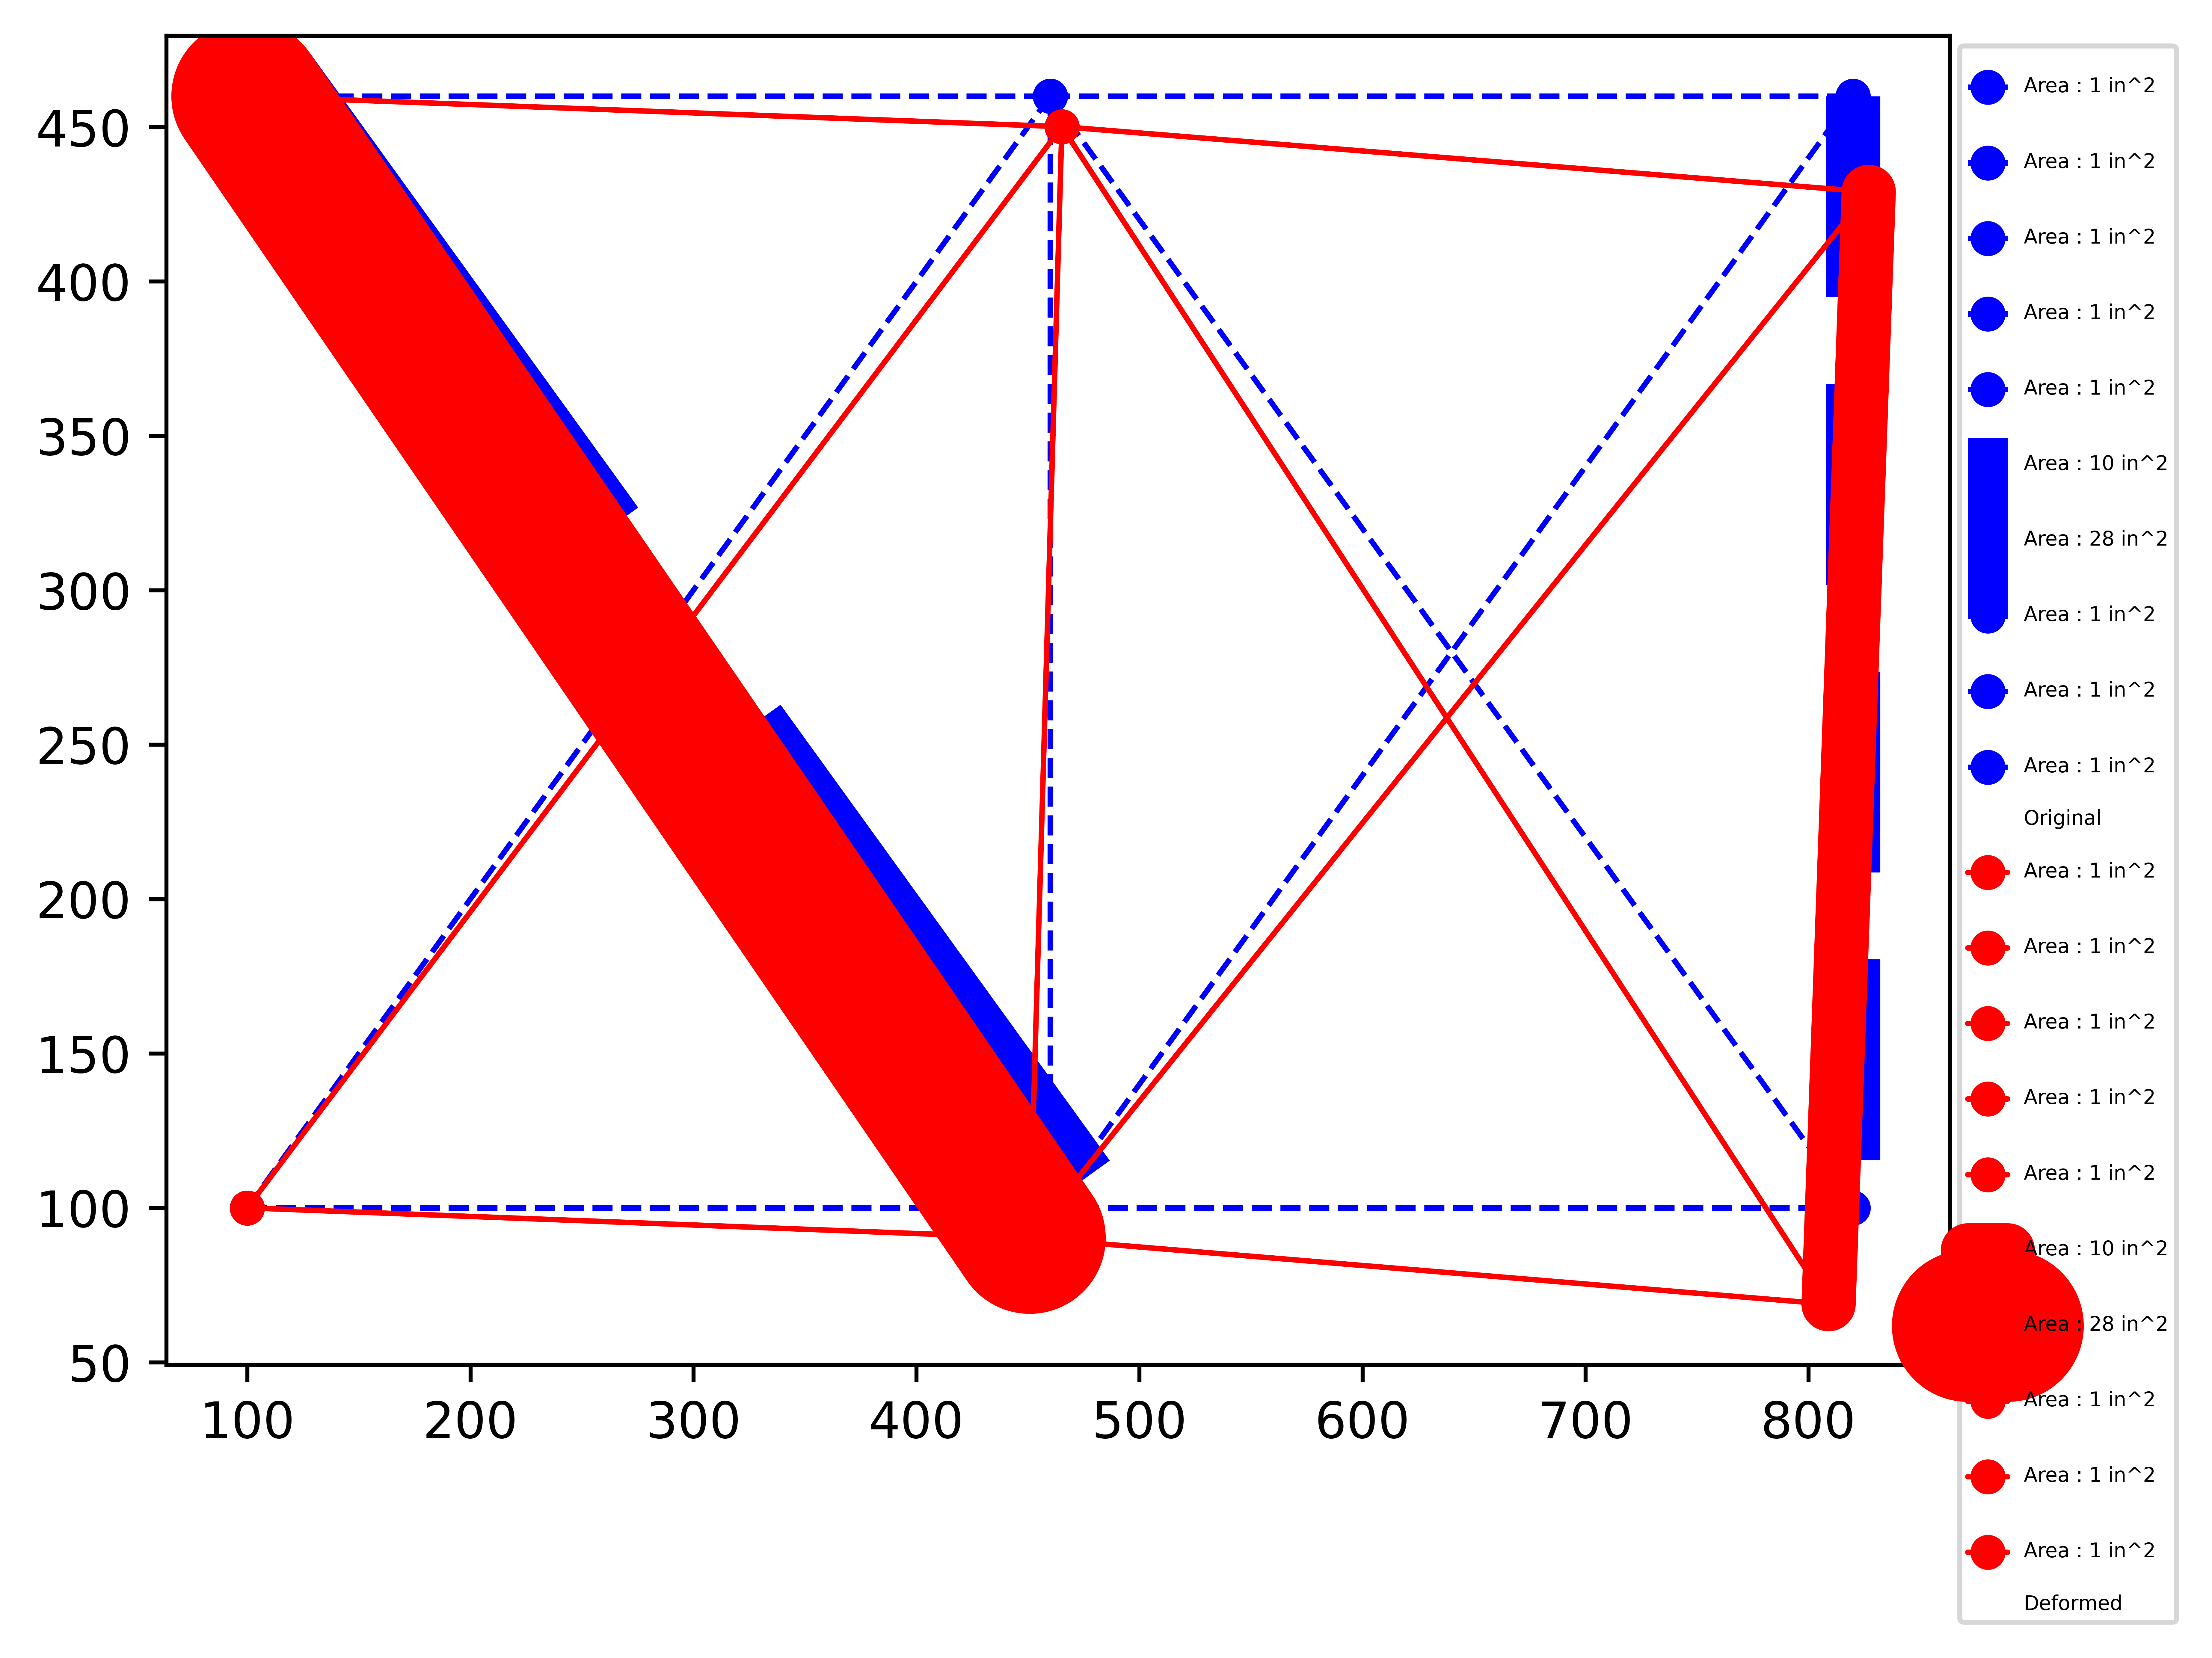

In [32]:
basic.Plot(nodes, 'b', '--',a, 'Original')
scale = 1
Dnodes=  Truss.TrussAnalysis(a, nodes, bars)[2]*scale + nodes
basic.Plot(Dnodes, 'r', '-',a, 'Deformed')